In [11]:
import numpy as np
import pandas as pd
import shutil
import math
import joblib
import os
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
google_drive_path = "data/"

In [13]:
!pip install kaggle

kaggle_key = "YOUR_KAGGLE_KEY"
kaggle_username = "YOUR_KAGGLE_USERNAME"

os.environ["KAGGLE_KEY"] = kaggle_key
os.environ["KAGGLE_USERNAME"] = kaggle_username

dataset_zip_path = "nslkdd.zip"
extracted_files = [
    "KDDTest+.arff", "KDDTest+.txt", "KDDTest-21.arff", "KDDTest-21.txt",
    "KDDTest1.jpg", "KDDTrain+.arff", "KDDTrain+.txt",
    "KDDTrain+_20Percent.arff", "KDDTrain+_20Percent.txt",
    "KDDTrain1.jpg", "index.html"
]
nsl_kdd_folder = "nsl-kdd"

if os.path.exists(dataset_zip_path):
    os.remove(dataset_zip_path)

for file_name in extracted_files:
    if os.path.exists(file_name):
        os.remove(file_name)

if os.path.exists(nsl_kdd_folder):
    shutil.rmtree(nsl_kdd_folder)



!kaggle datasets download -d hassan06/nslkdd
!unzip nslkdd.zip

Dataset URL: https://www.kaggle.com/datasets/hassan06/nslkdd
License(s): unknown
100%|██████████████████████████████████████| 13.9M/13.9M [00:05<00:00, 2.93MB/s]
100%|██████████████████████████████████████| 13.9M/13.9M [00:05<00:00, 2.56MB/s]
Archive:  nslkdd.zip
  inflating: KDDTest+.arff           
  inflating: KDDTest+.txt            
  inflating: KDDTest-21.arff         
  inflating: KDDTest-21.txt          
  inflating: KDDTest1.jpg            
  inflating: KDDTrain+.arff          
  inflating: KDDTrain+.txt           
  inflating: KDDTrain+_20Percent.arff  
  inflating: KDDTrain+_20Percent.txt  
  inflating: KDDTrain1.jpg           
  inflating: index.html              
  inflating: nsl-kdd/KDDTest+.arff   
  inflating: nsl-kdd/KDDTest+.txt    
  inflating: nsl-kdd/KDDTest-21.arff  
  inflating: nsl-kdd/KDDTest-21.txt  
  inflating: nsl-kdd/KDDTest1.jpg    
  inflating: nsl-kdd/KDDTrain+.arff  
  inflating: nsl-kdd/KDDTrain+.txt   
  inflating: nsl-kdd/KDDTrain+_20Percent.arff  


In [14]:
# data transformation functions

def load_data(train_path, test_path, col_names):
    train_data = pd.read_csv(train_path, header=None, names=col_names)
    test_data = pd.read_csv(test_path, header=None, names=col_names)
    return train_data, test_data

def create_attack_flag(df):
    return df.label.map(lambda a: 0 if a == 'normal' else 1)

def map_attack(attack):
    attack_type_dos = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
    attack_type_probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
    attack_type_privilege = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
    attack_type_access = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xclock', 'xsnoop']

    if attack in attack_type_dos:
        return 1
    elif attack in attack_type_probe:
        return 2
    elif attack in attack_type_privilege:
        return 3
    elif attack in attack_type_access:
        return 4
    else:
        return 0

def save_data(X, Y, filename):
  path = google_drive_path + filename
  joblib.dump((X, Y), path)
  print(f"Preprocessed data dumped successfully at path: {path}")

In [15]:
def create_attack_map(df):
    return df.label.apply(map_attack)

def create_preprocessing_pipeline(categorical_features, numeric_features):
    categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical_feature_encoder', categorical_transformer, categorical_features),
            ('numeric_feature_encoder', MinMaxScaler(), numeric_features)
        ])

    return Pipeline([
        ('preprocessor', preprocessor)
    ])

In [16]:

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty_level"]

train_data, test_data = load_data('nsl-kdd/KDDTrain+.txt', 'nsl-kdd/KDDTest+.txt', col_names)

train_data['attack_flag'] = create_attack_flag(train_data)
test_data['attack_flag'] = create_attack_flag(test_data)
train_data['attack_map'] = create_attack_map(train_data)
test_data['attack_map'] = create_attack_map(test_data)


In [6]:
print(train_data.head)

<bound method NDFrame.head of         duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst

In [7]:
def plot_boxplot(df):
    numeric_features = df.select_dtypes(include=[np.number])

    num_cols = len(numeric_features.columns)

    num_rows = int(np.ceil(np.sqrt(num_cols)))
    num_cols = int(np.ceil(num_cols / num_rows))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

    axes = axes.flatten()

    for i, column in enumerate(numeric_features.columns):
        numeric_features[column].plot(kind='box', ax=axes[i])
        axes[i].set_title(column)
        axes[i].set_xlabel('')

    for i in range(len(numeric_features.columns), len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Boxplots of Numeric Features", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

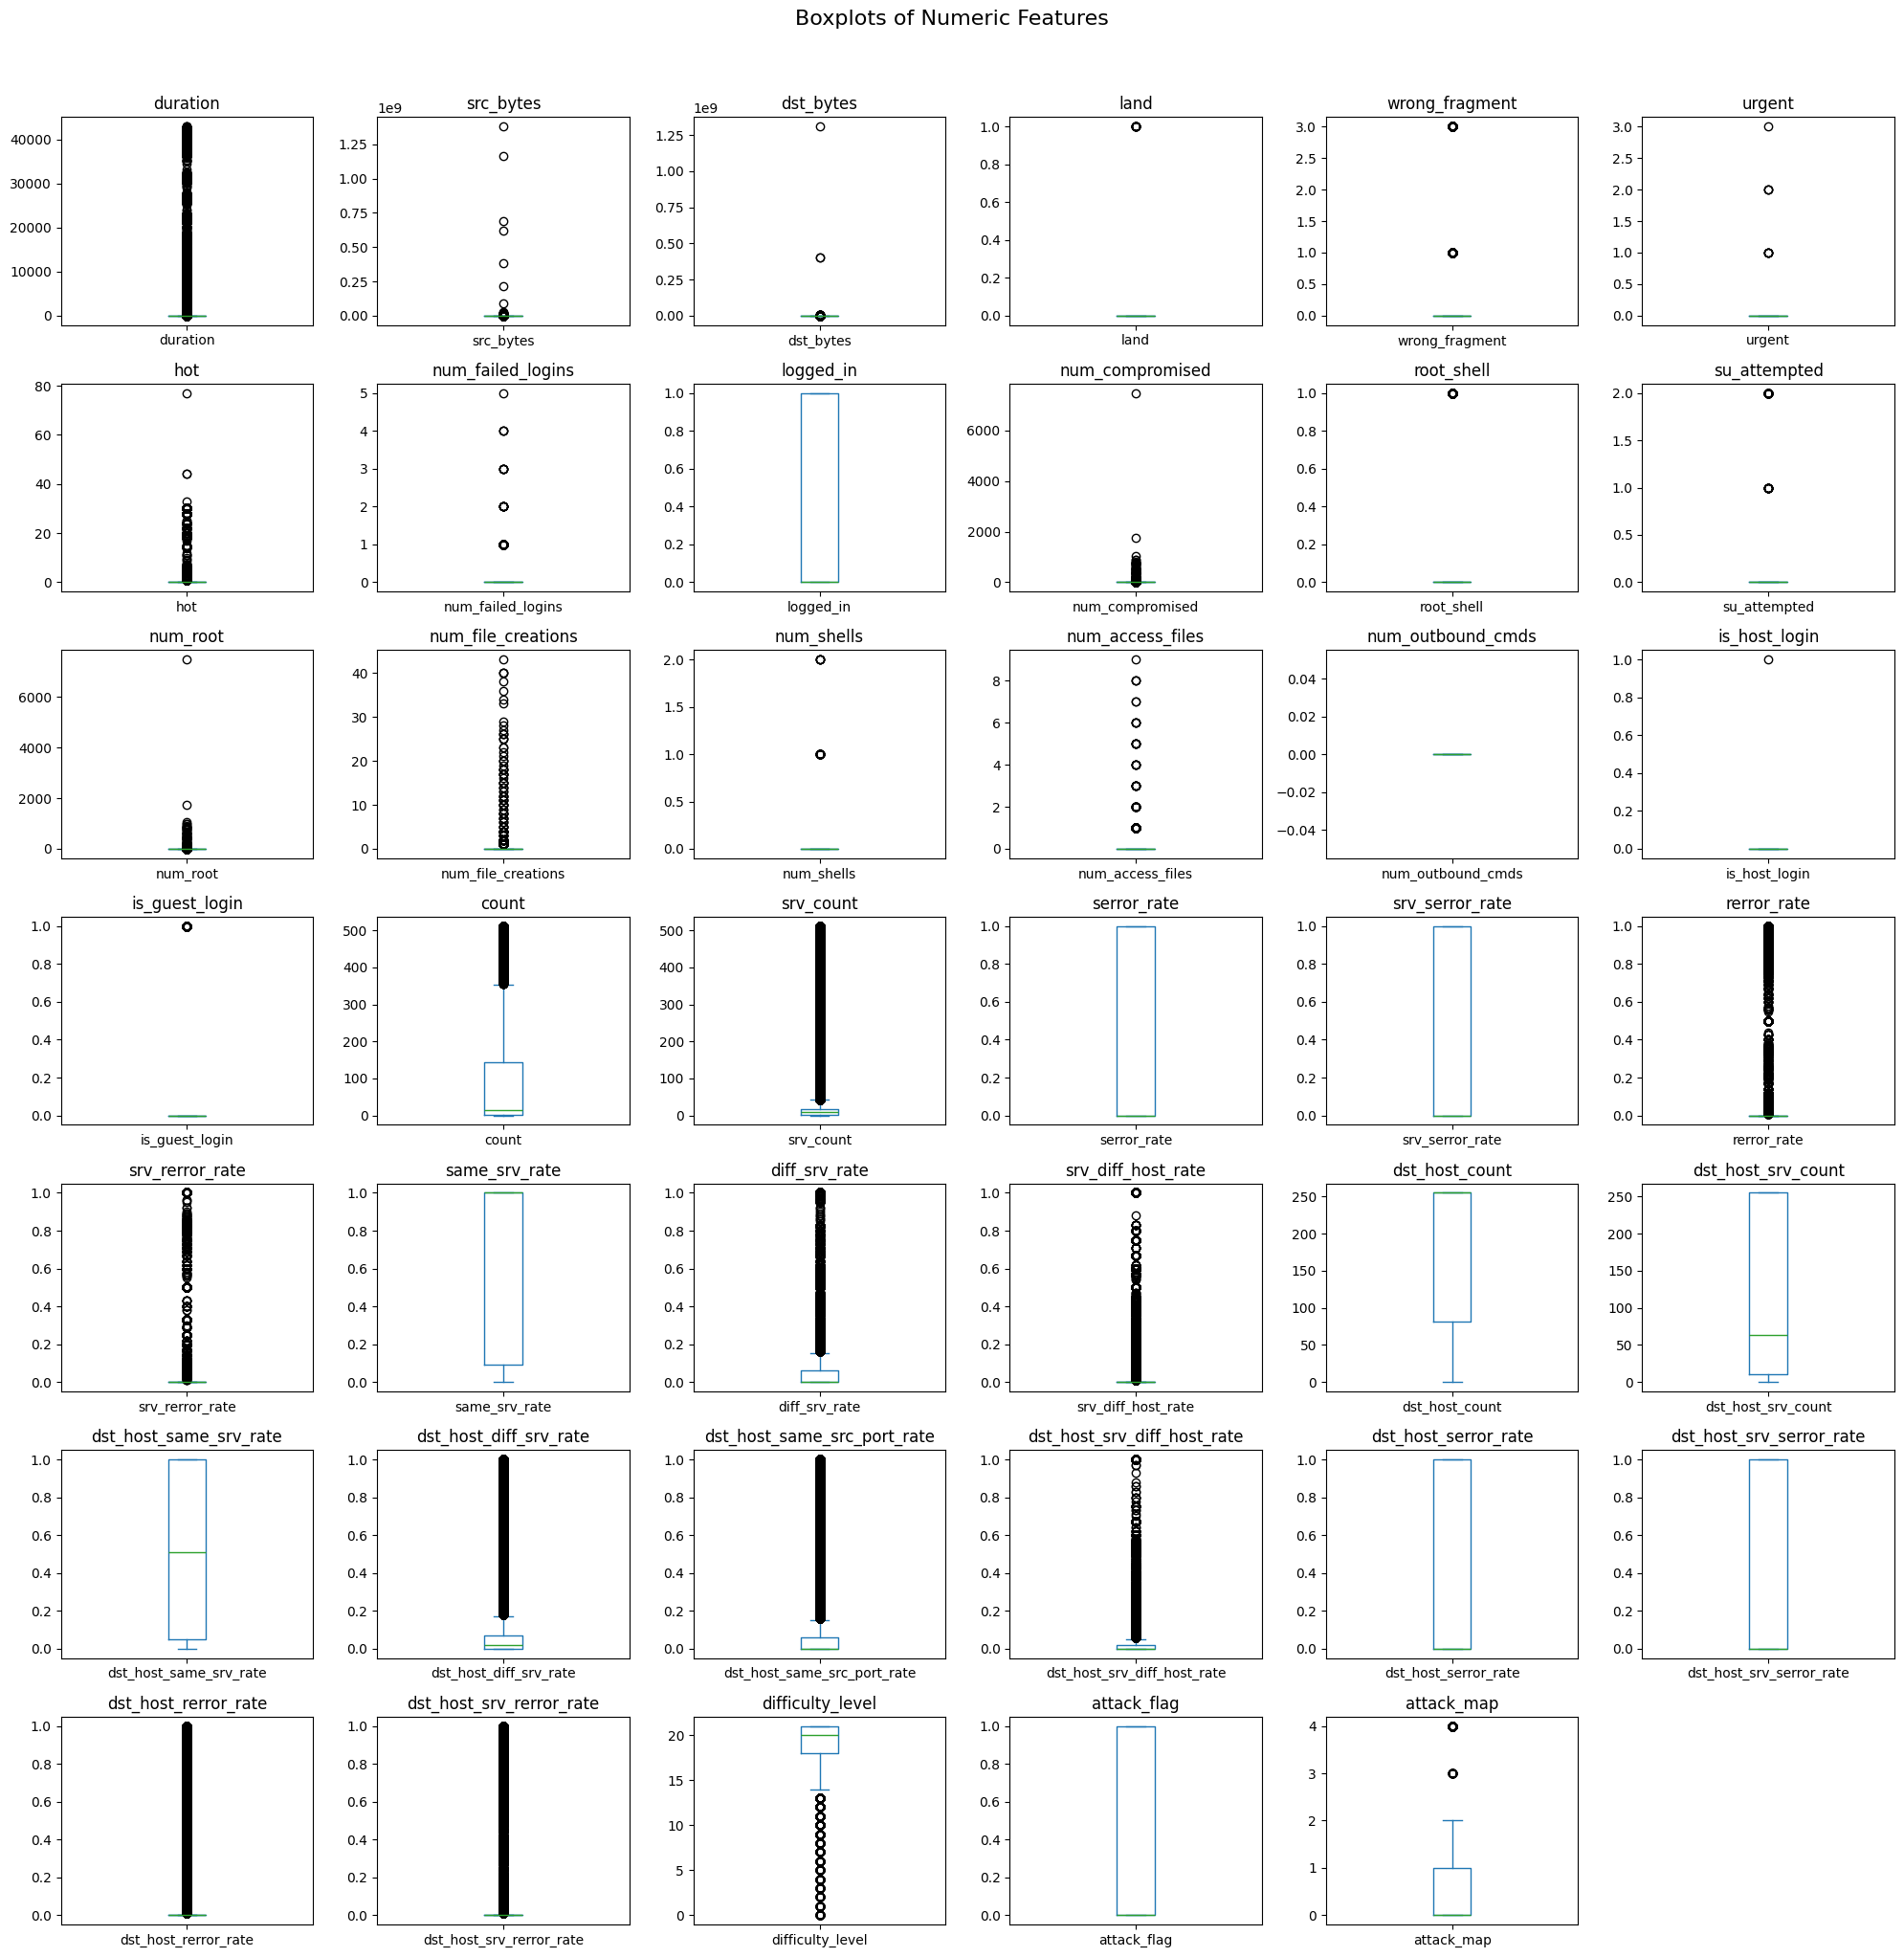

In [8]:
plot_boxplot(train_data)

In [9]:
print(train_data.head)
print(train_data.shape)

<bound method NDFrame.head of         duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0              0           tcp  ftp_data   SF        491          0     0   
1              0           udp     other   SF        146          0     0   
2              0           tcp   private   S0          0          0     0   
3              0           tcp      http   SF        232       8153     0   
4              0           tcp      http   SF        199        420     0   
...          ...           ...       ...  ...        ...        ...   ...   
125968         0           tcp   private   S0          0          0     0   
125969         8           udp   private   SF        105        145     0   
125970         0           tcp      smtp   SF       2231        384     0   
125971         0           tcp    klogin   S0          0          0     0   
125972         0           tcp  ftp_data   SF        151          0     0   

        wrong_fragment  urgent  hot  ...  dst

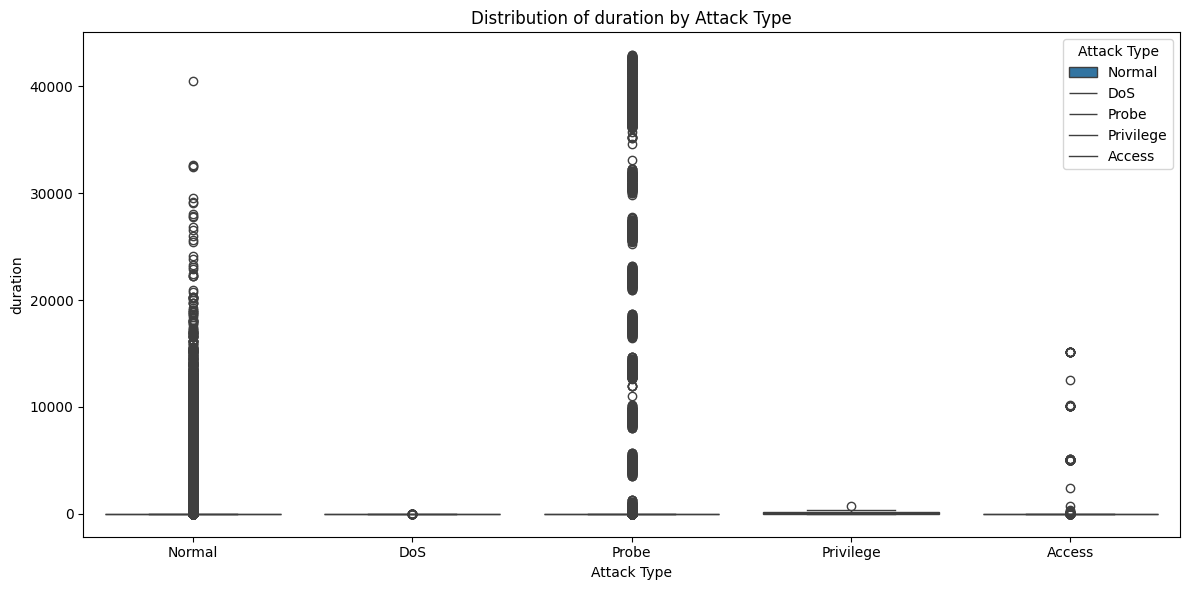

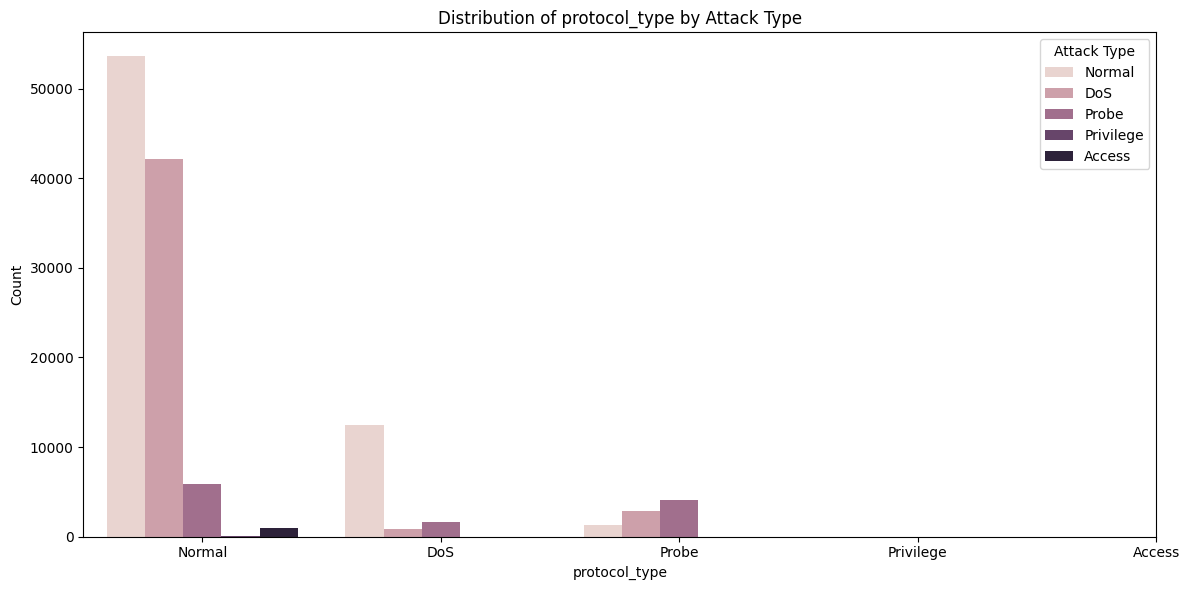

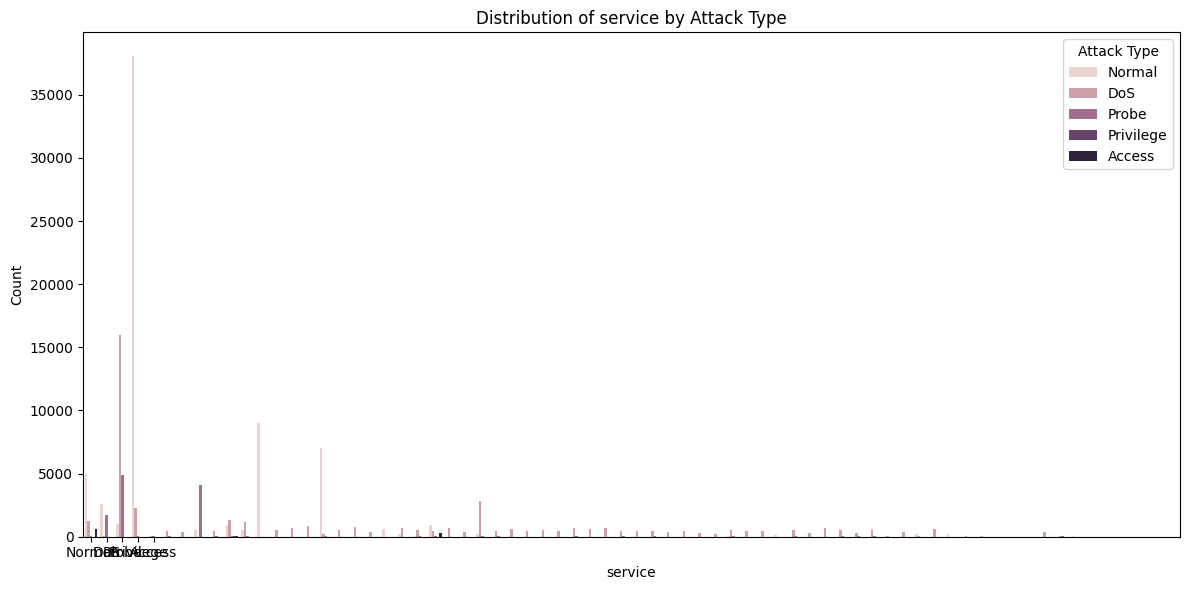

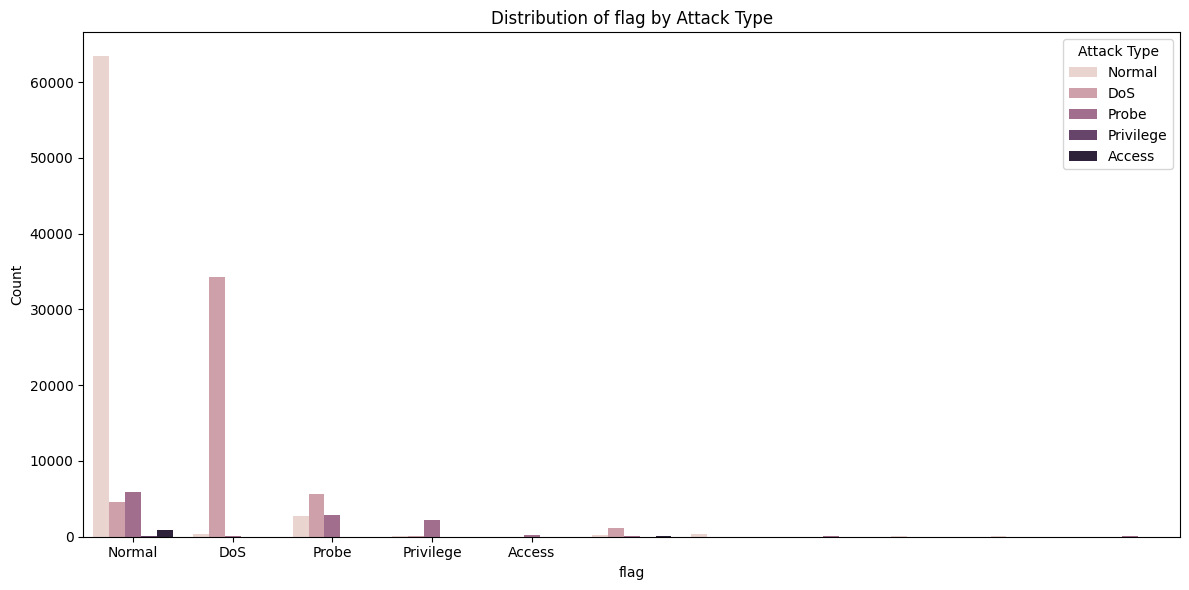

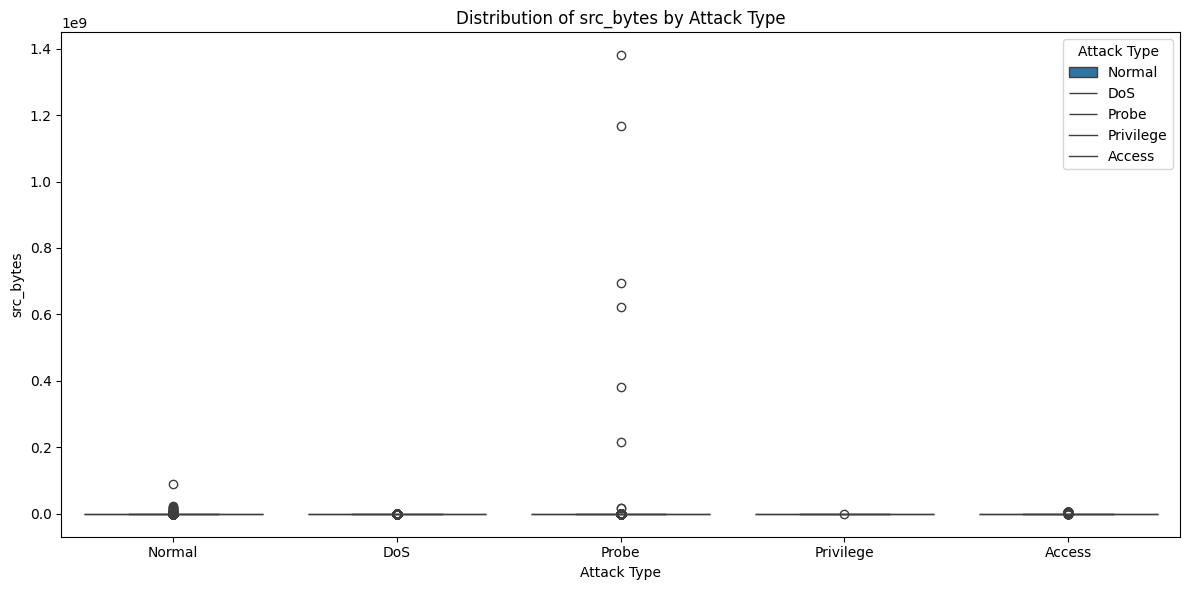

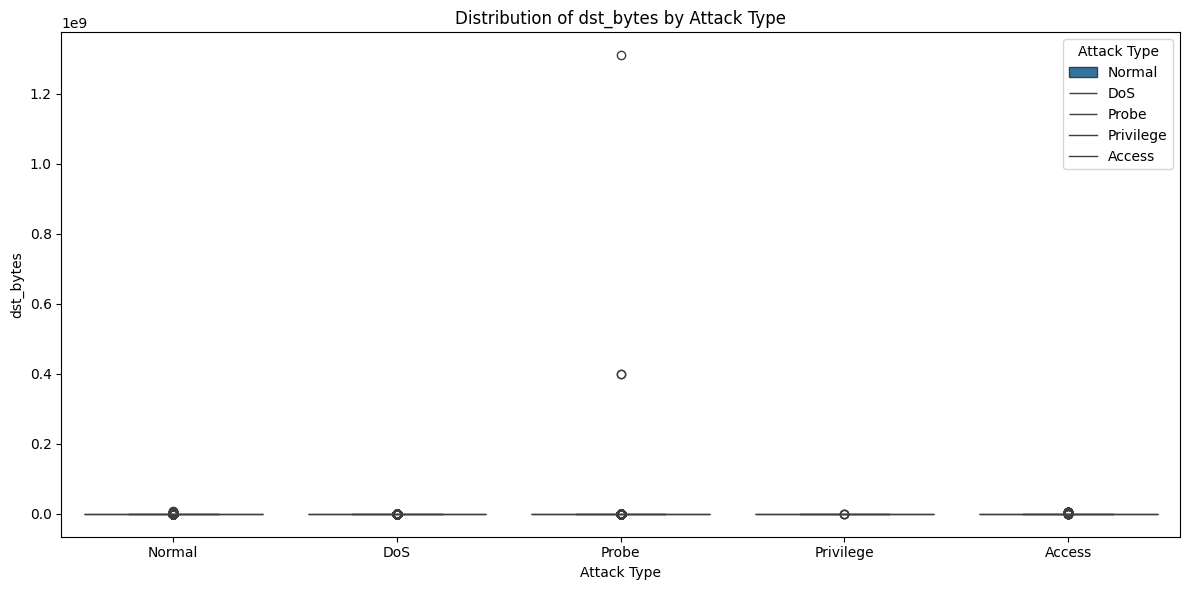

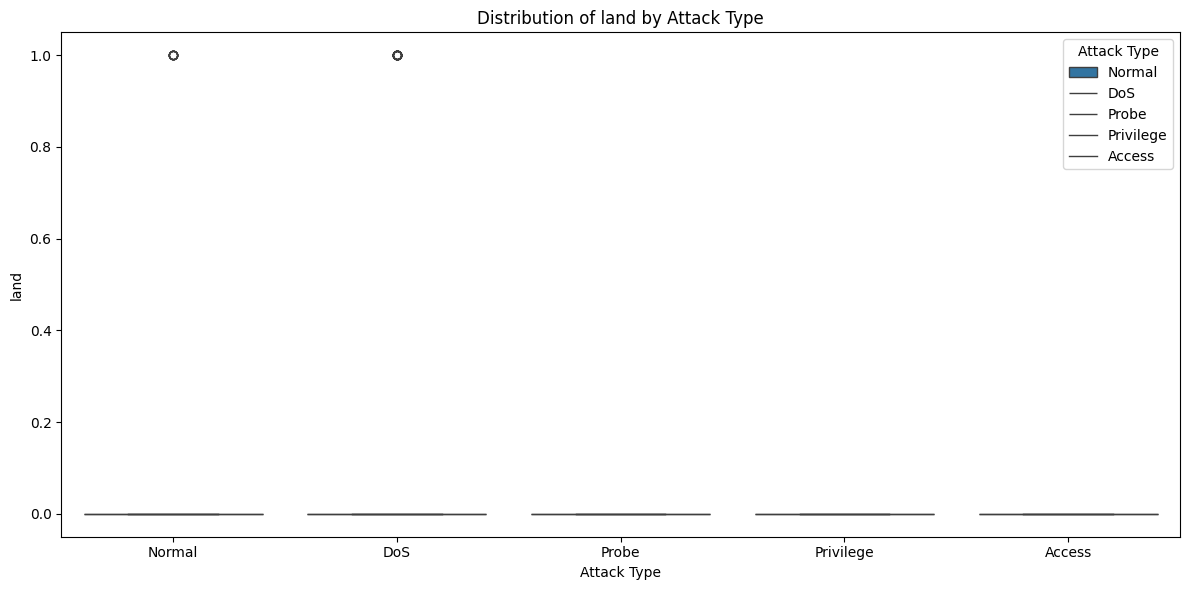

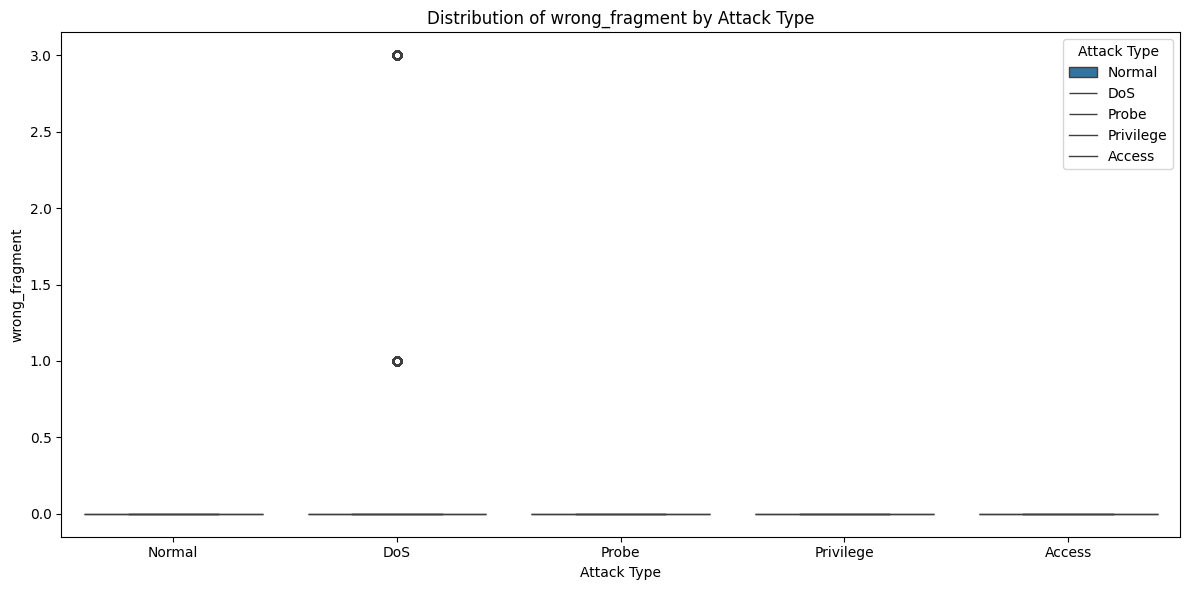

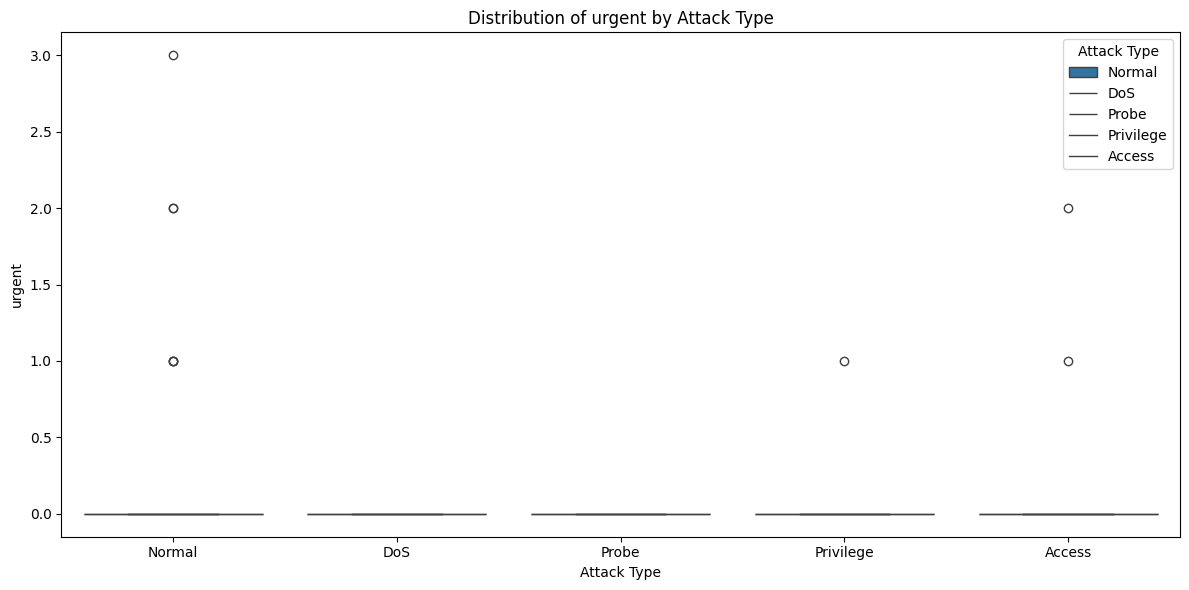

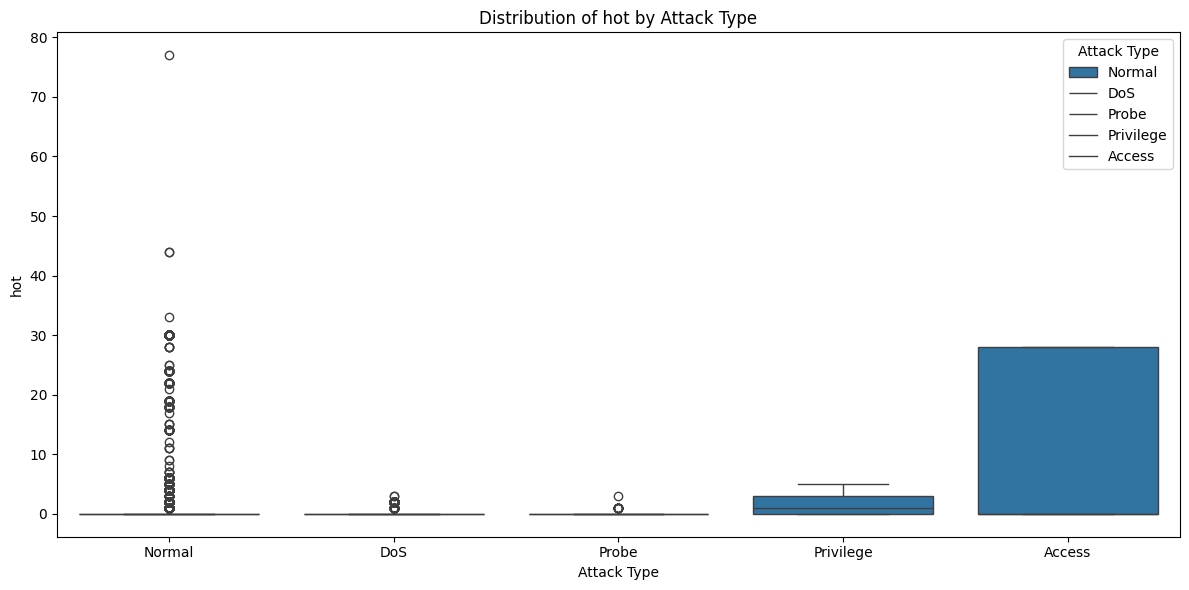

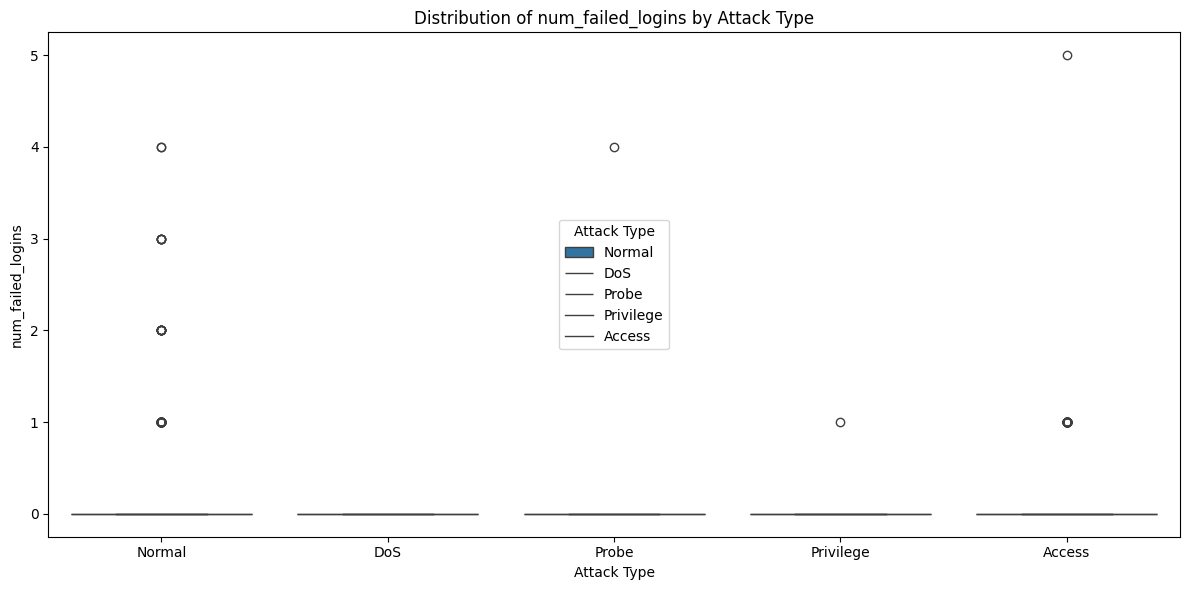

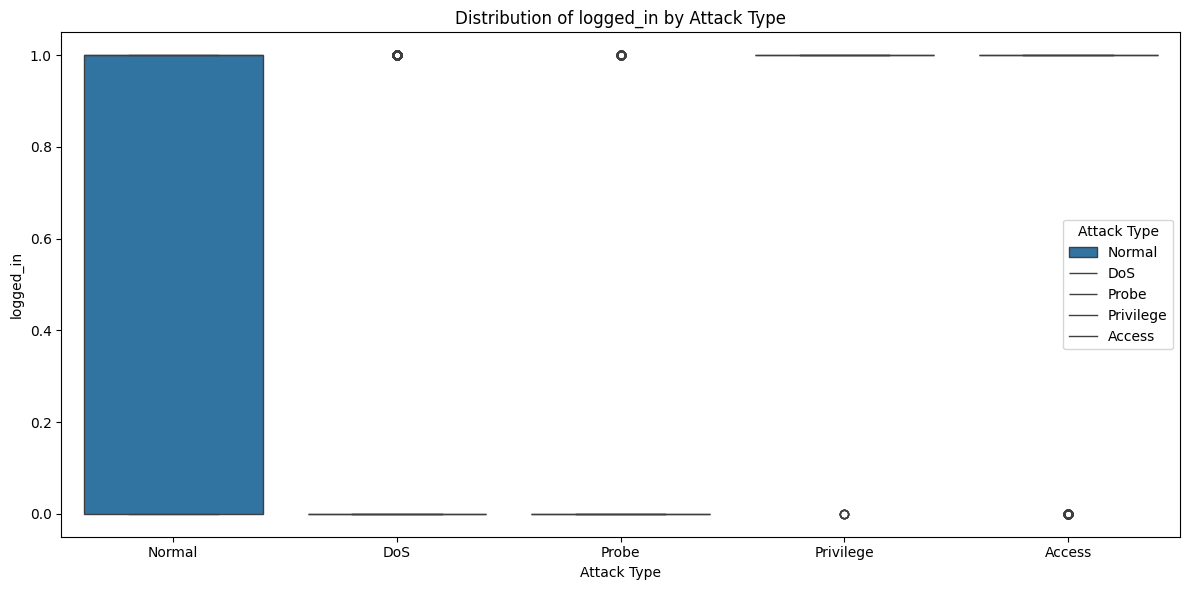

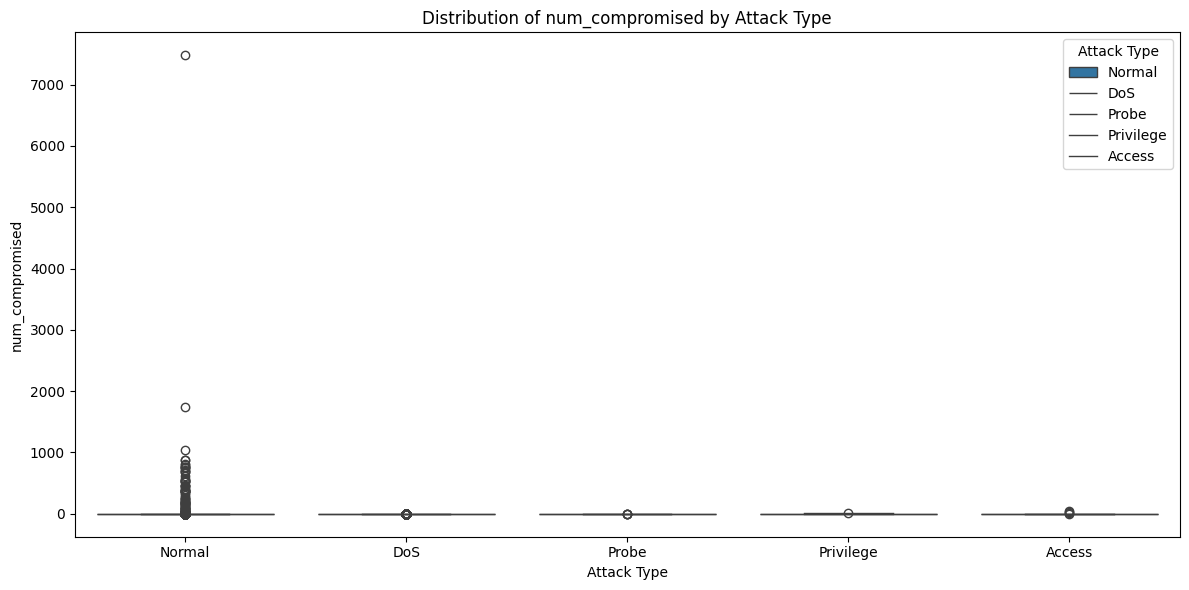

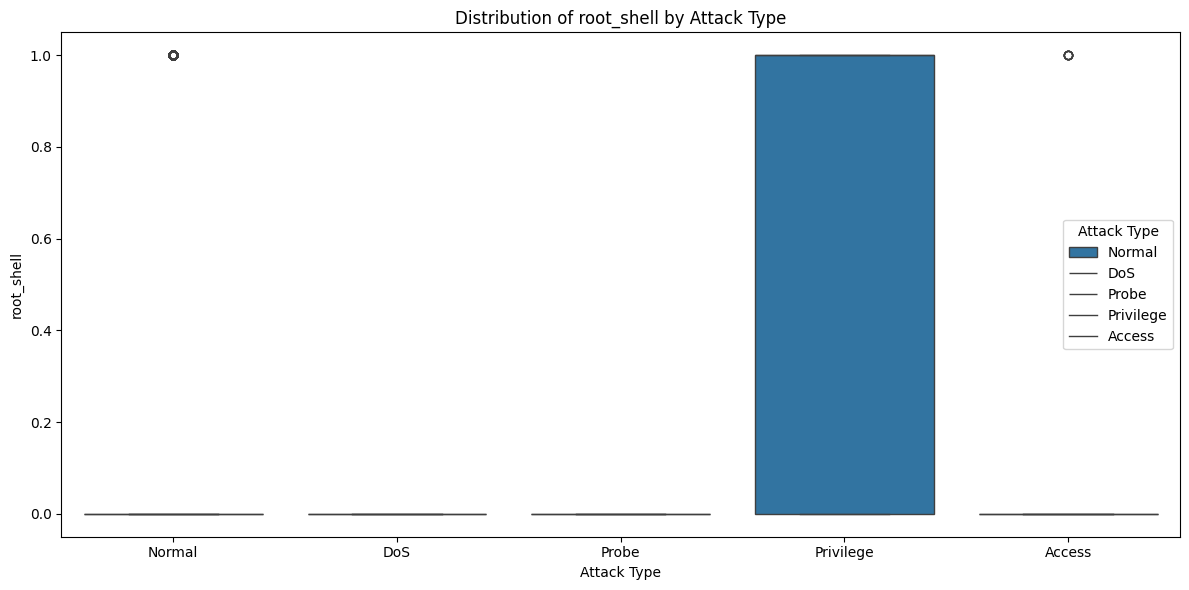

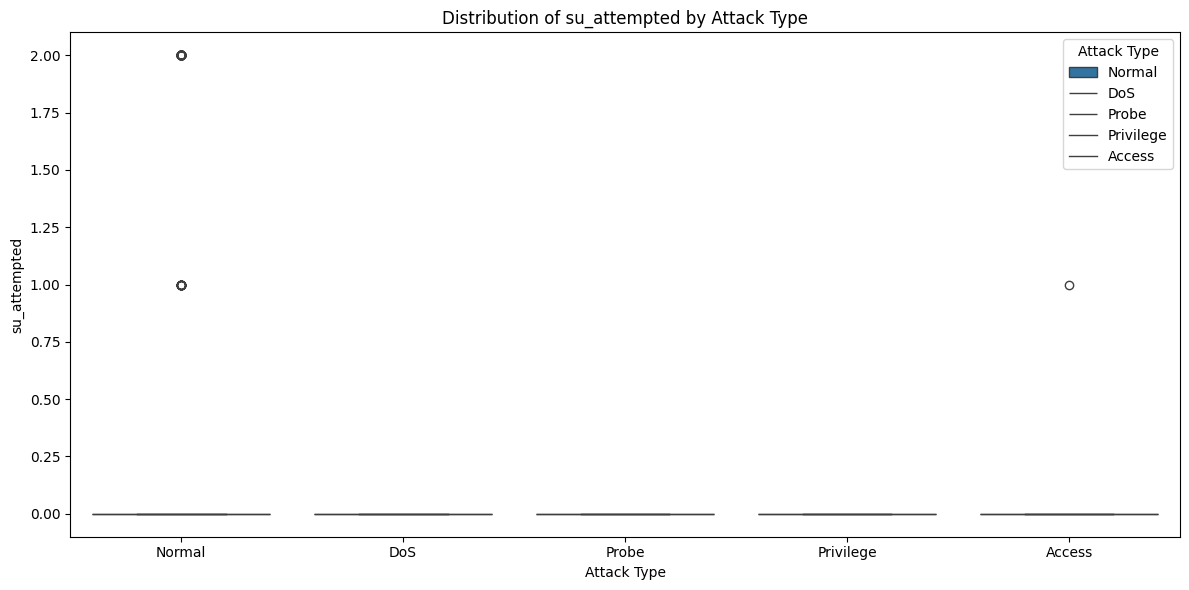

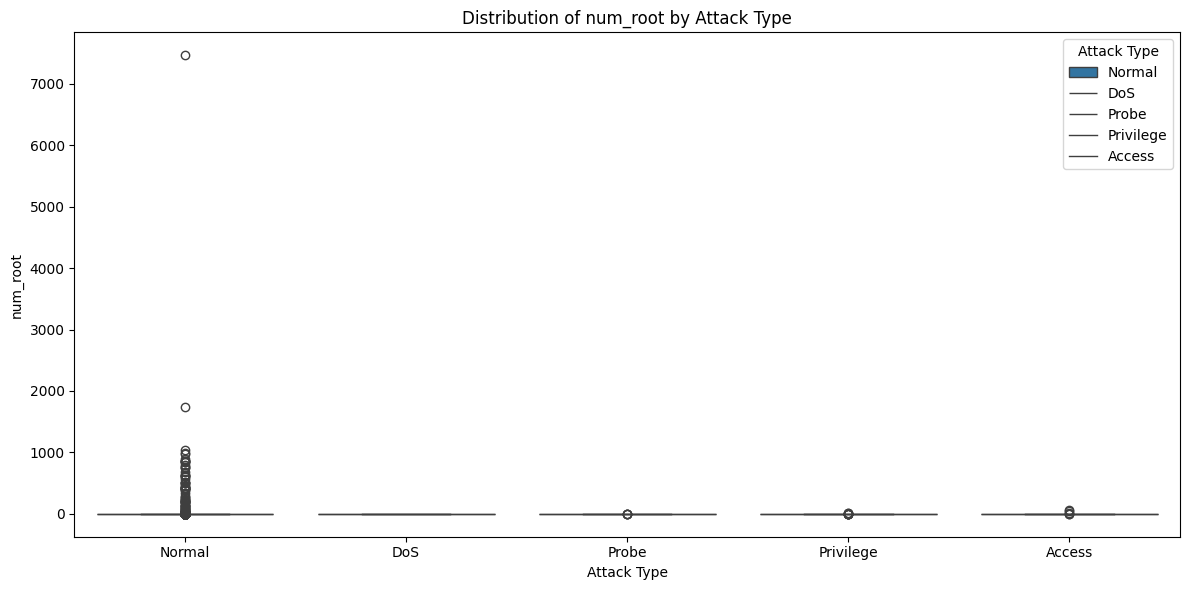

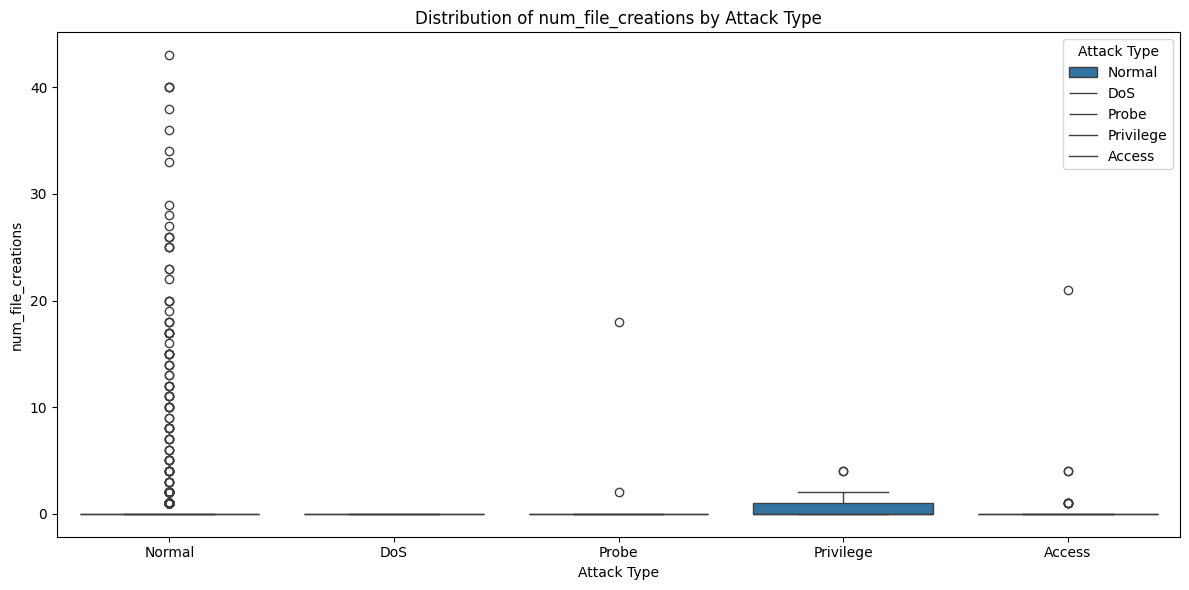

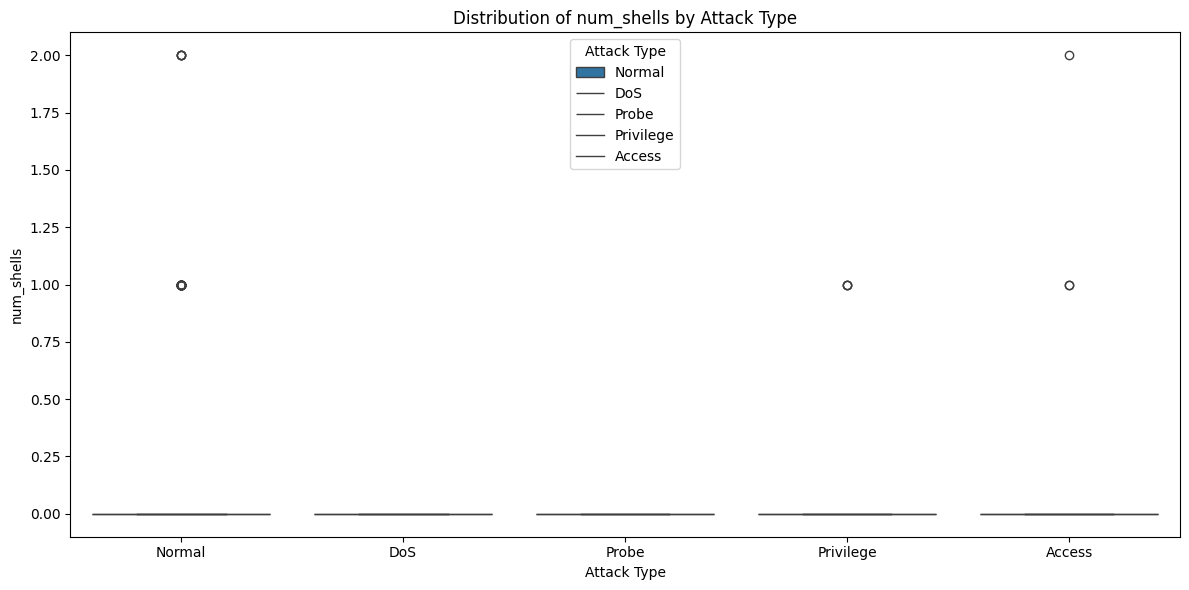

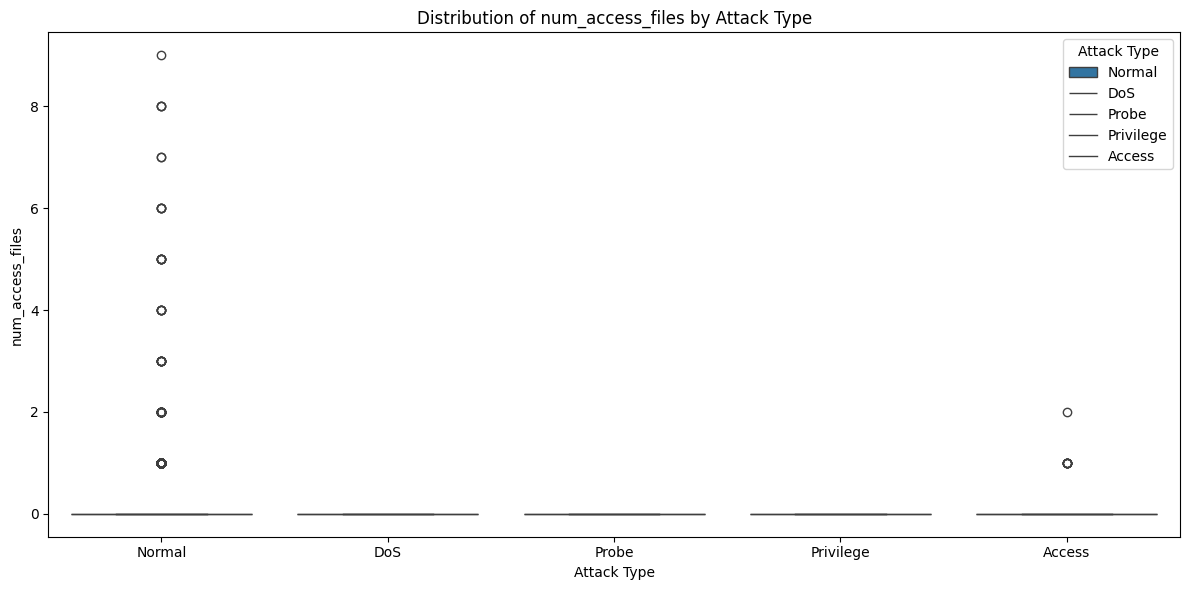

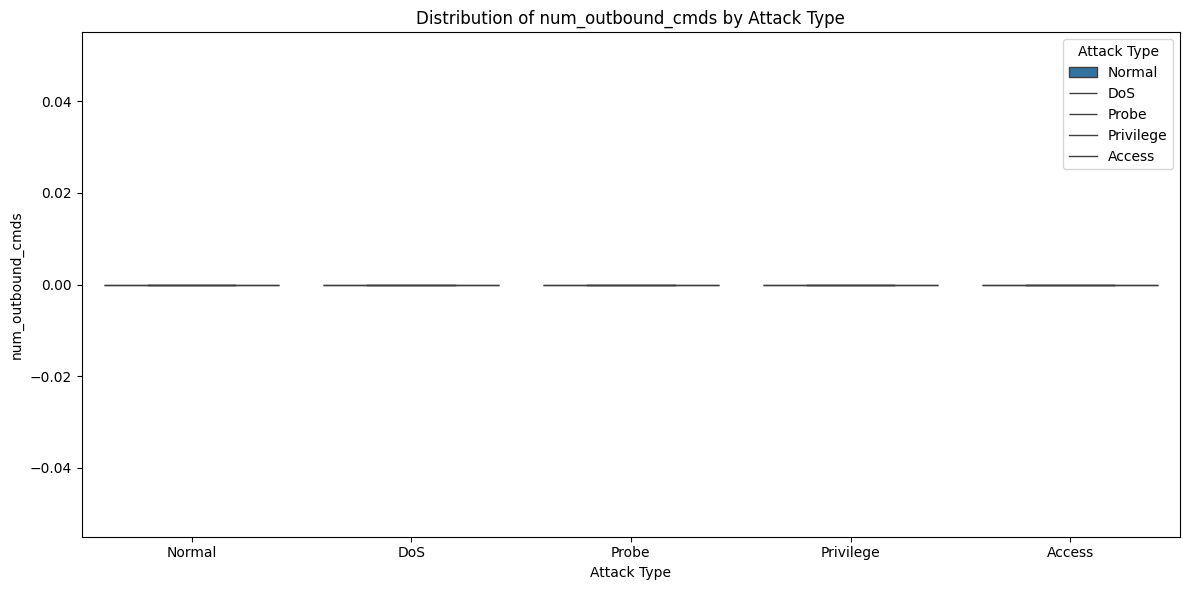

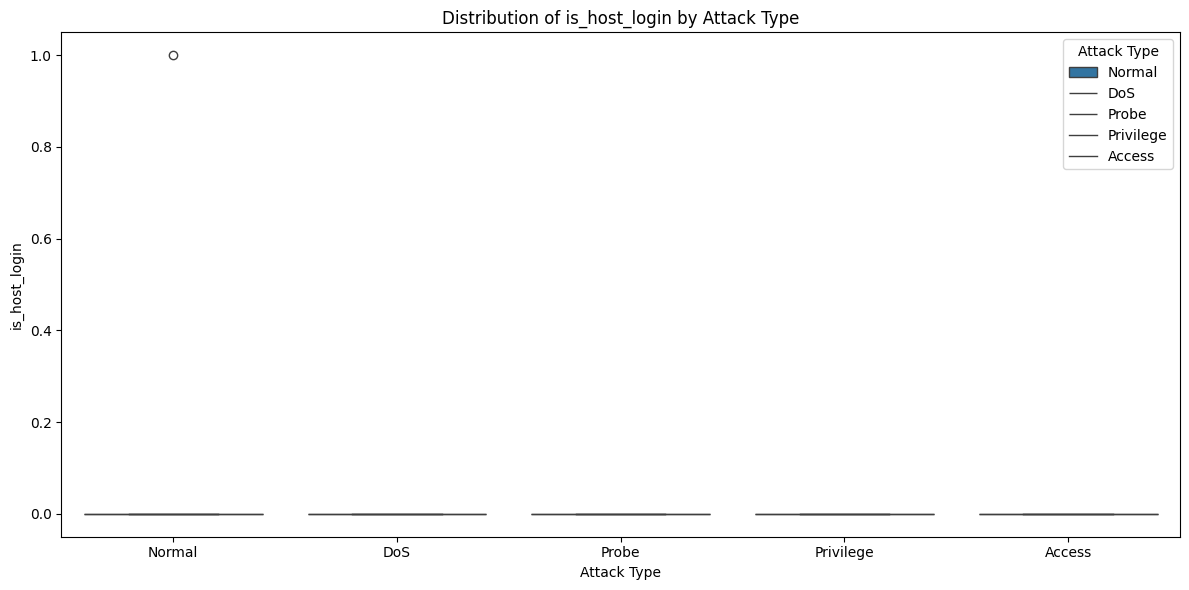

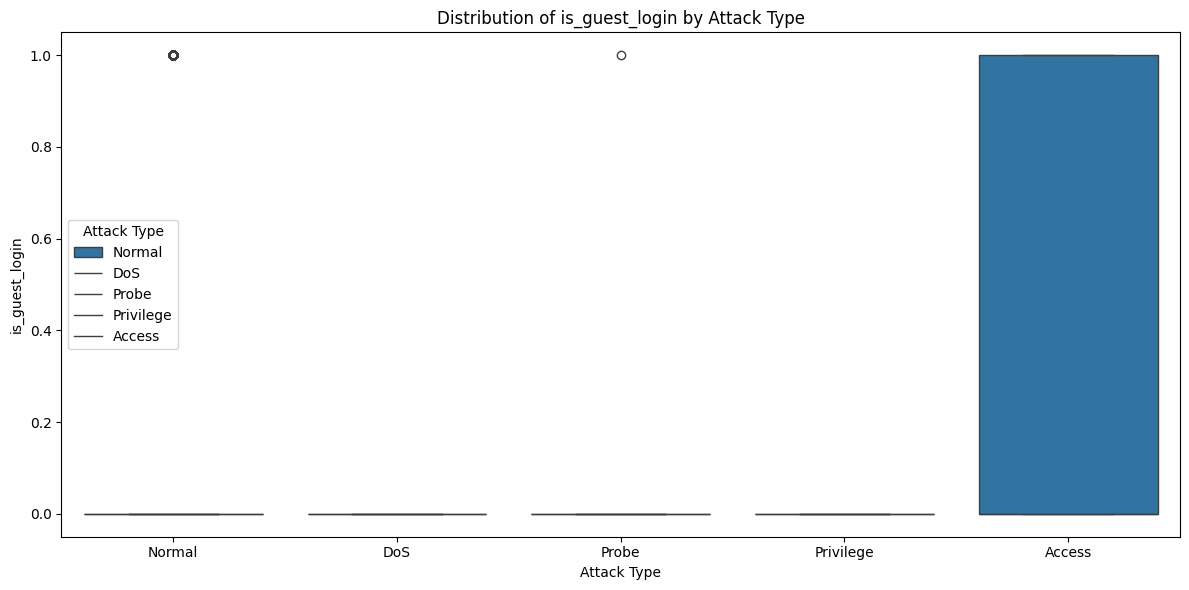

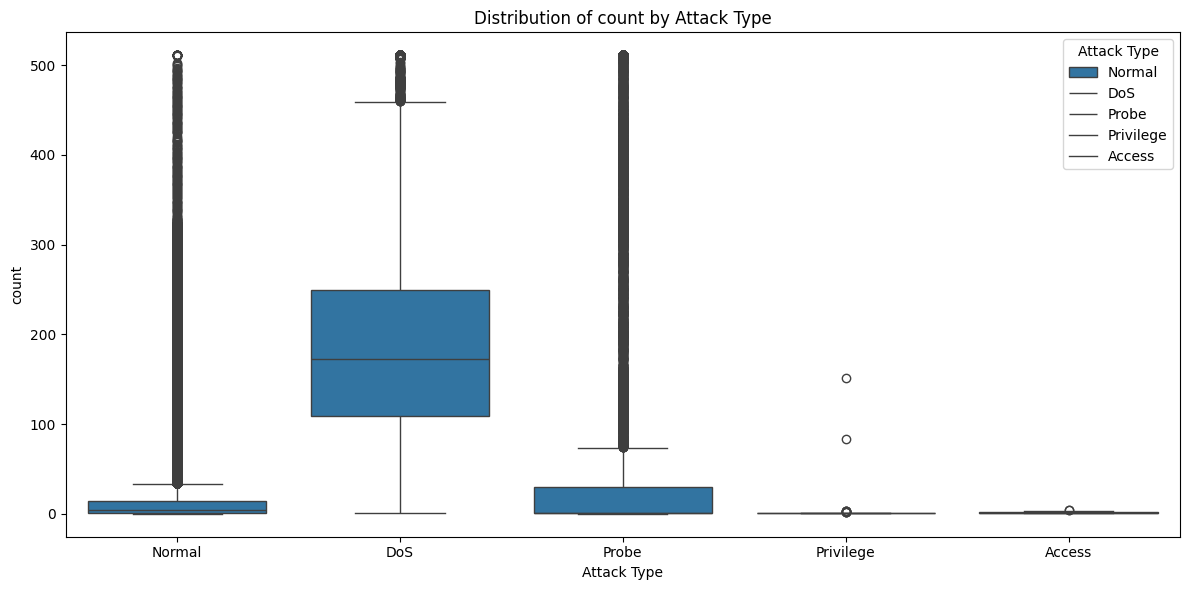

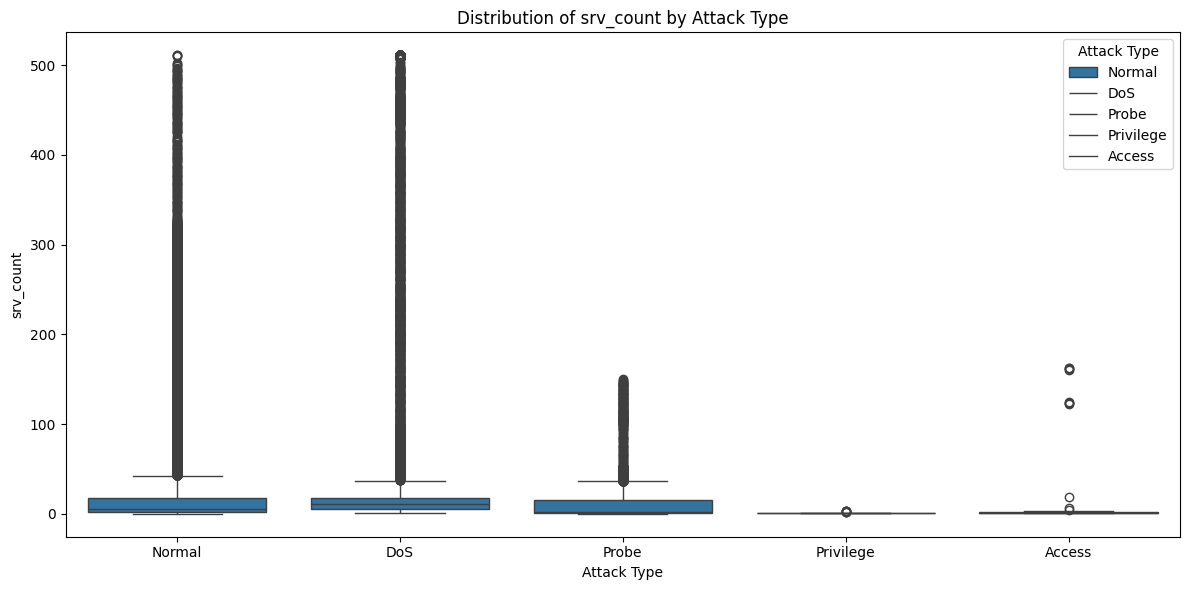

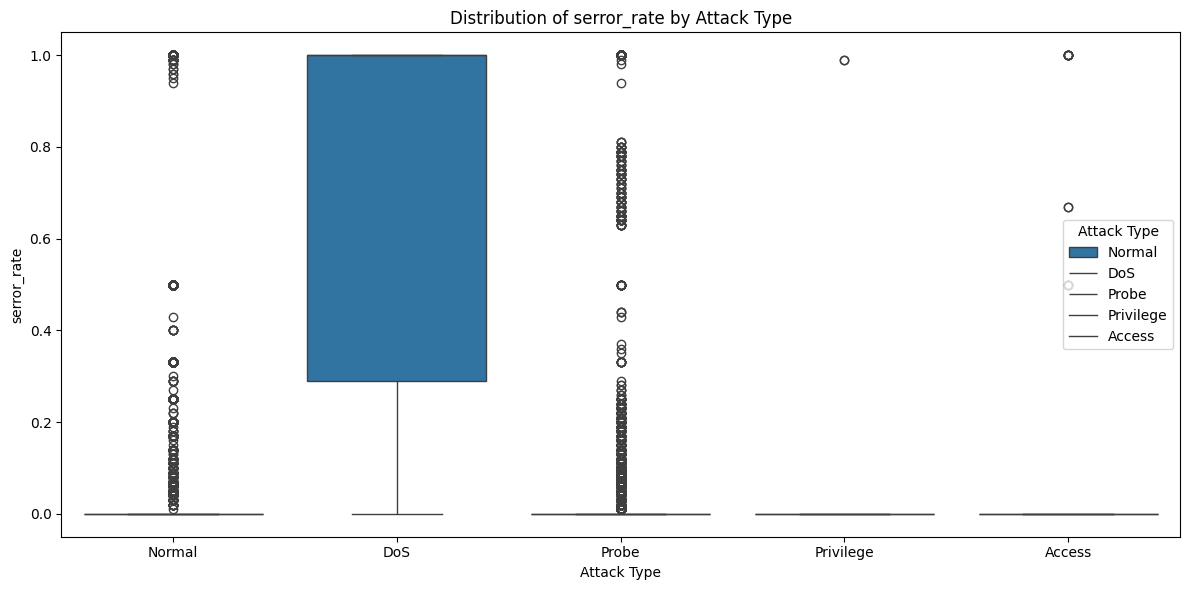

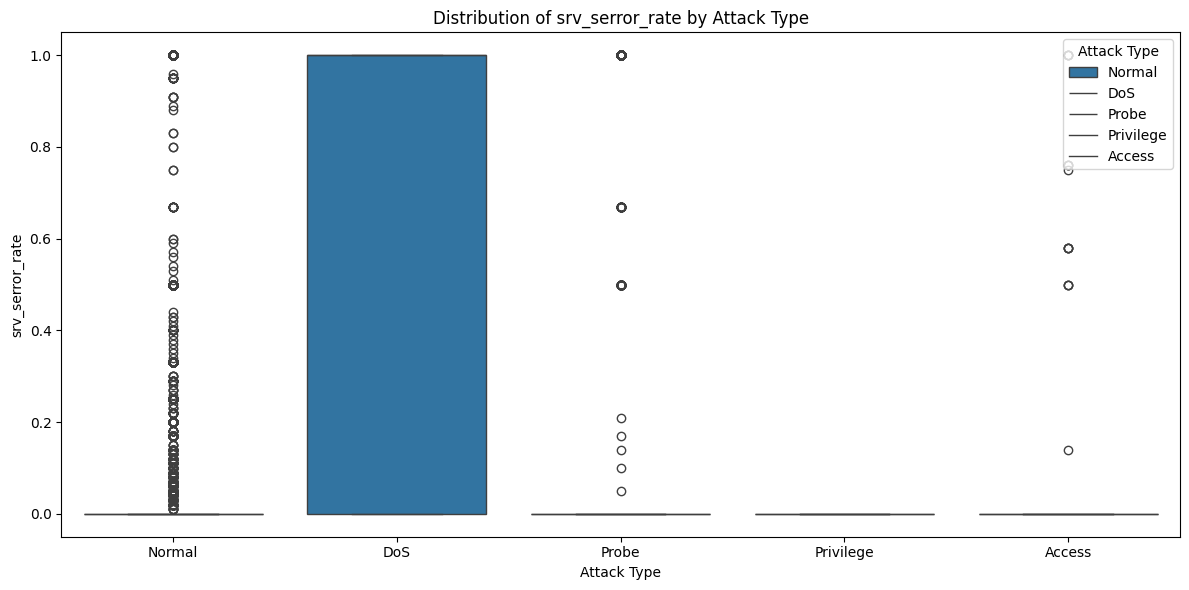

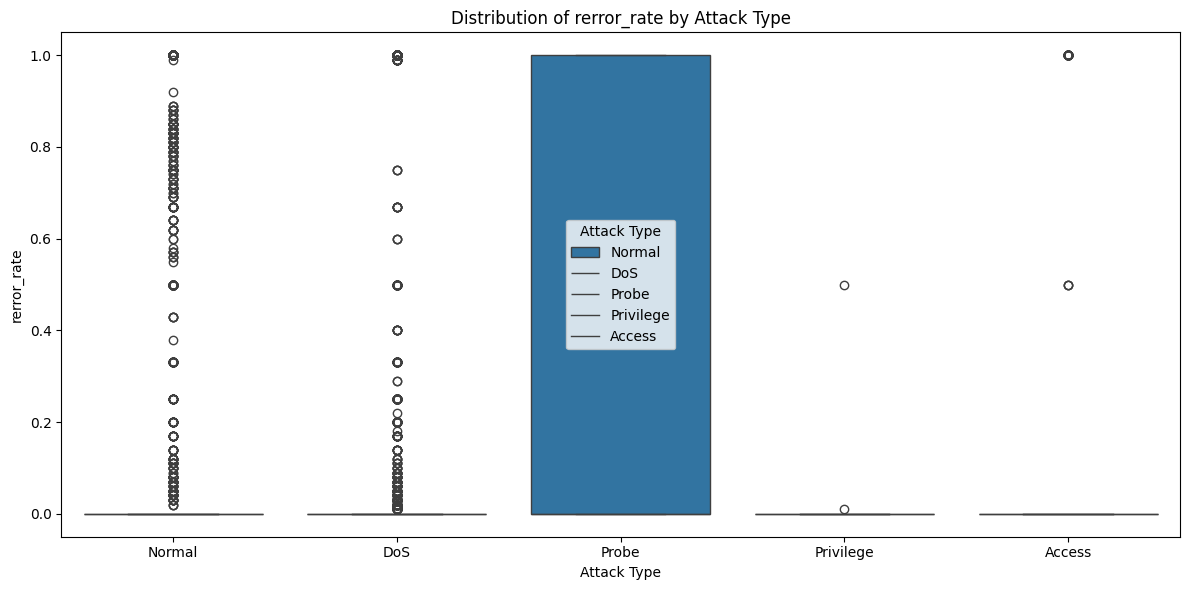

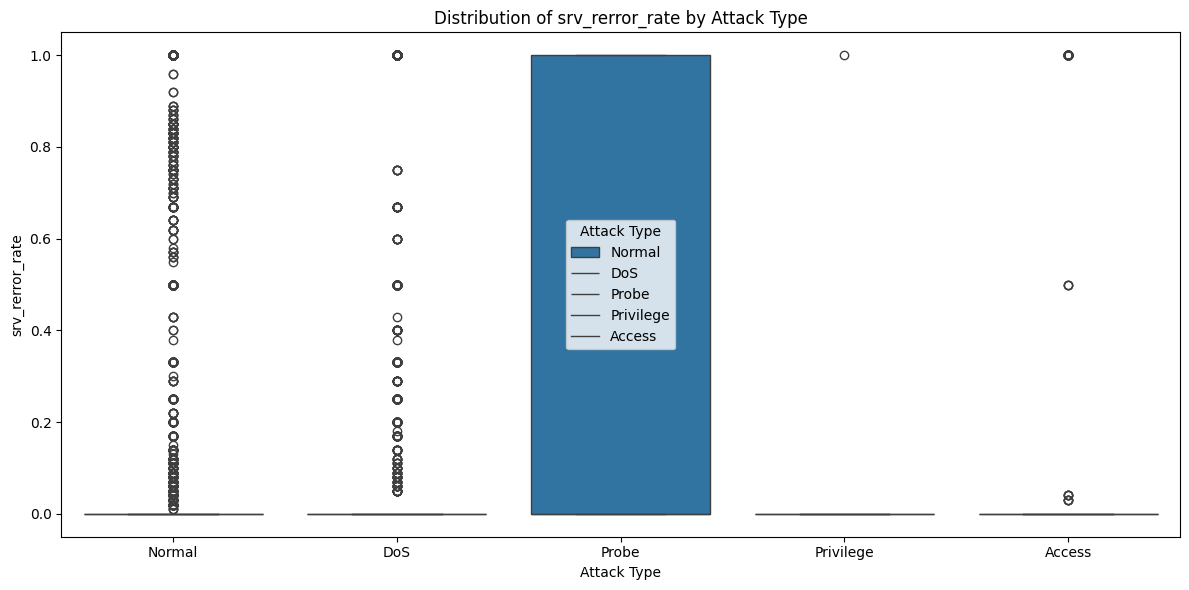

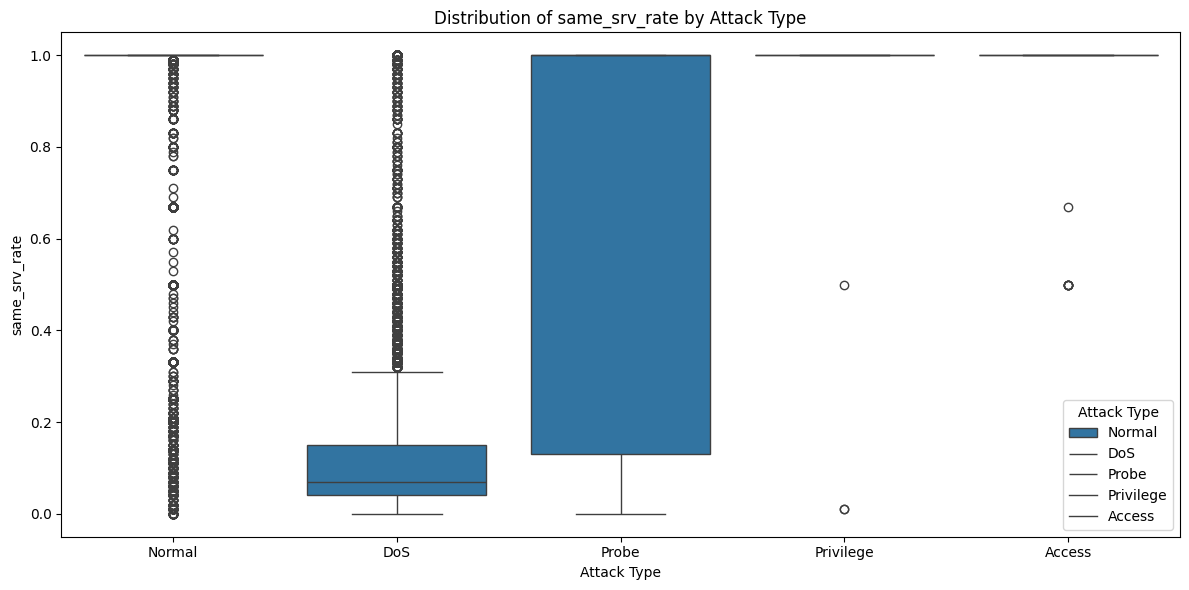

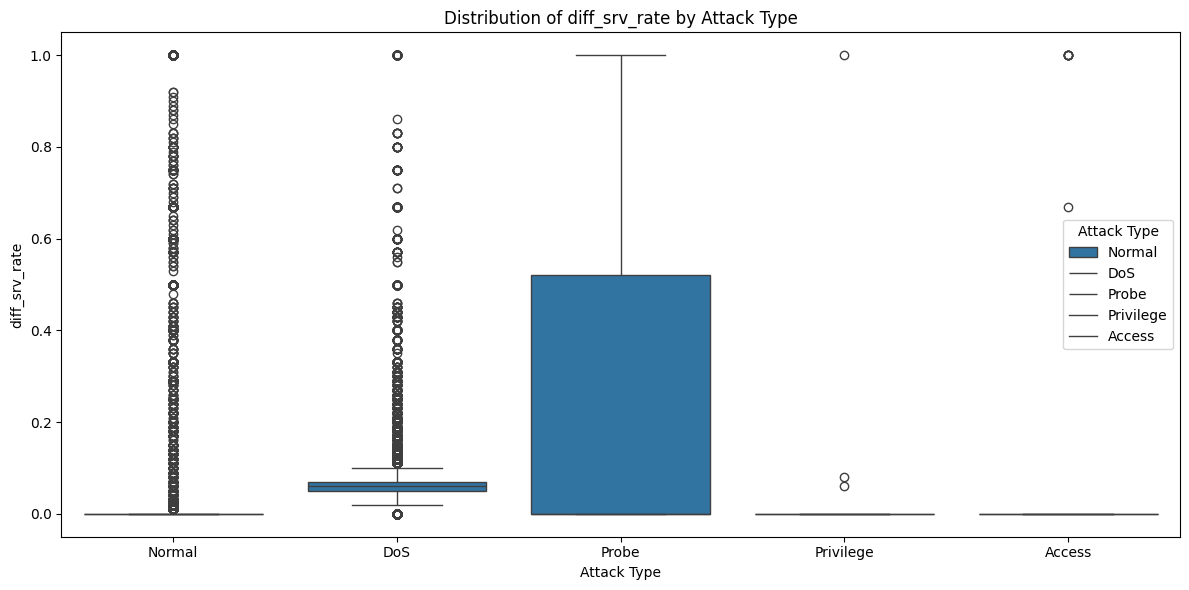

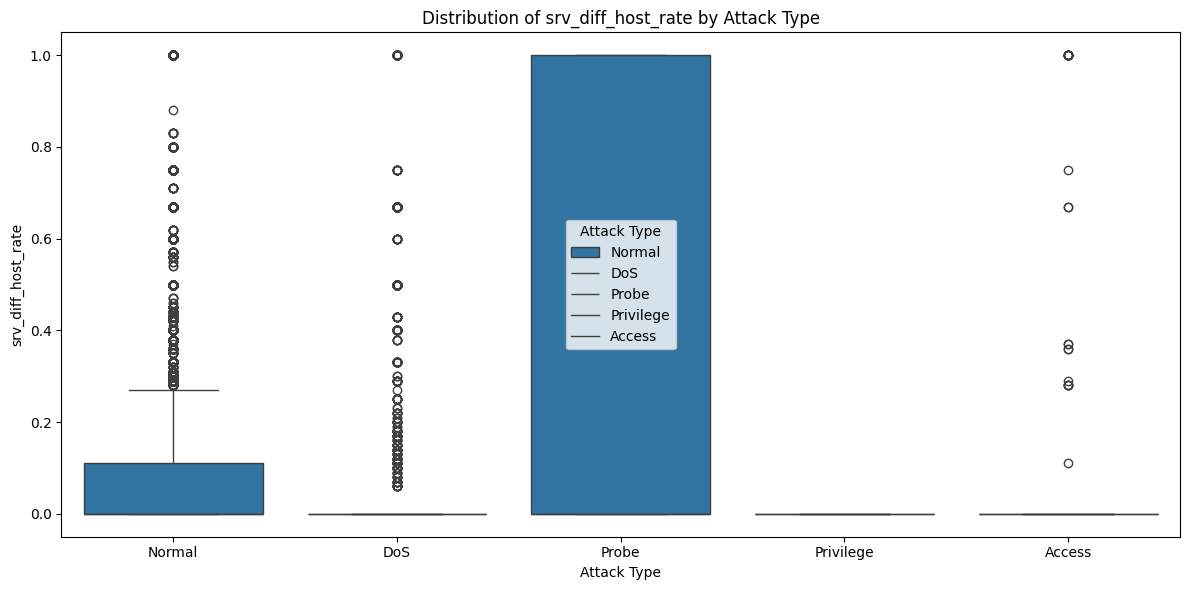

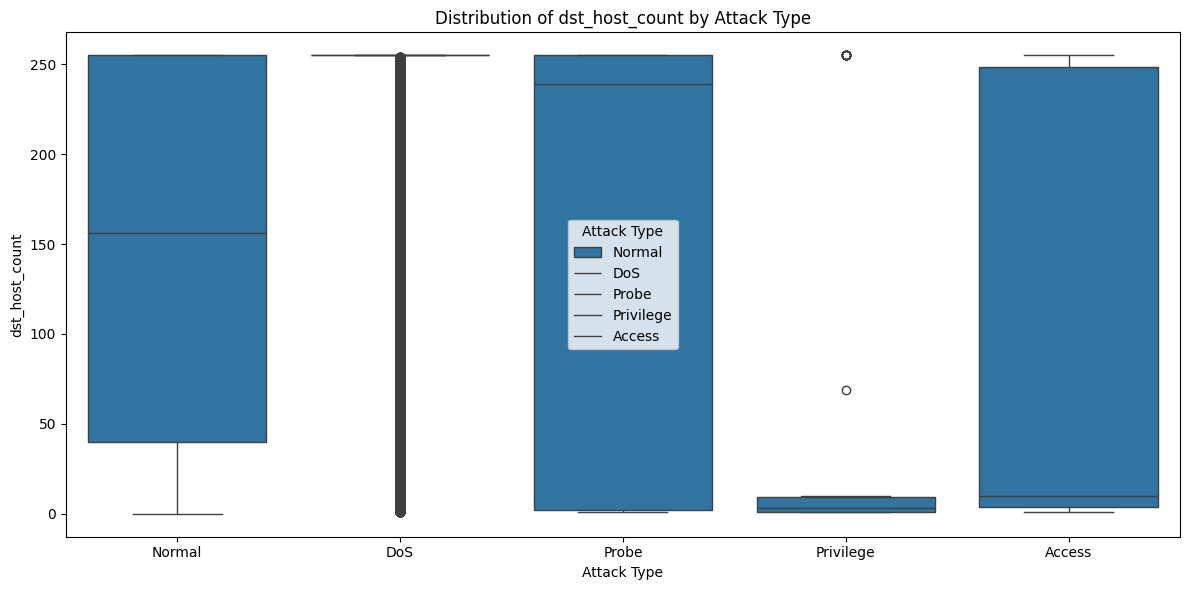

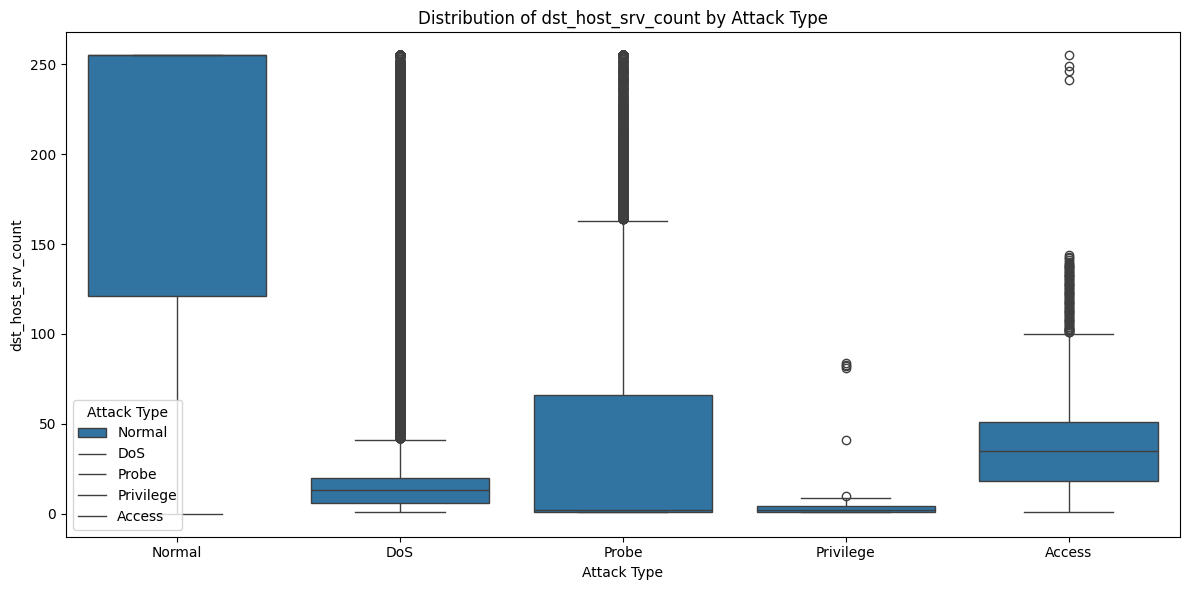

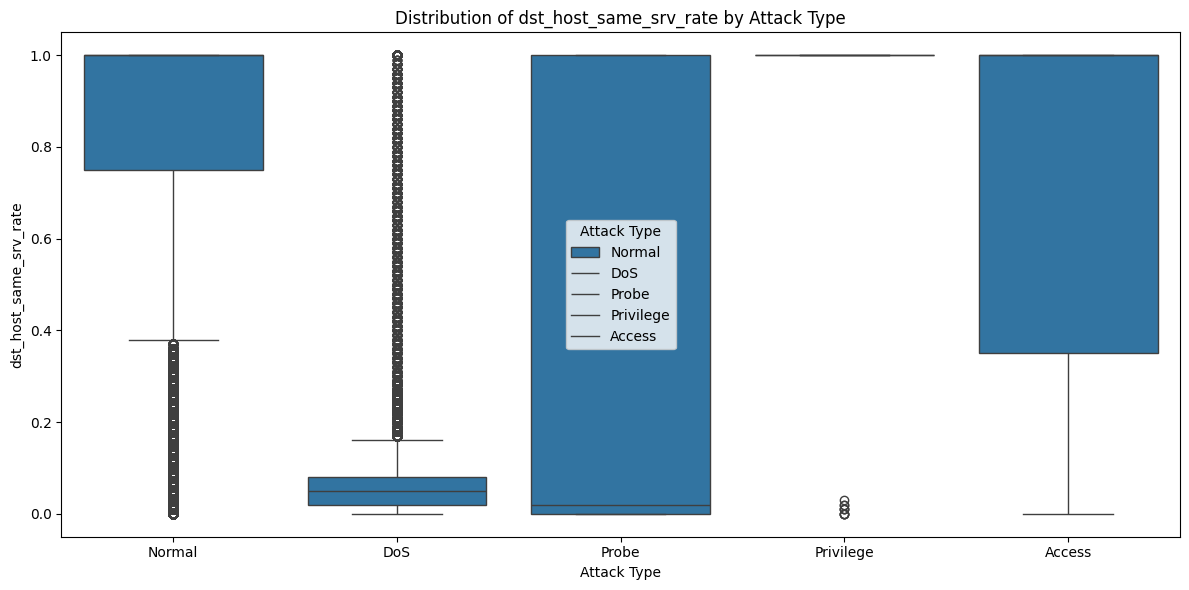

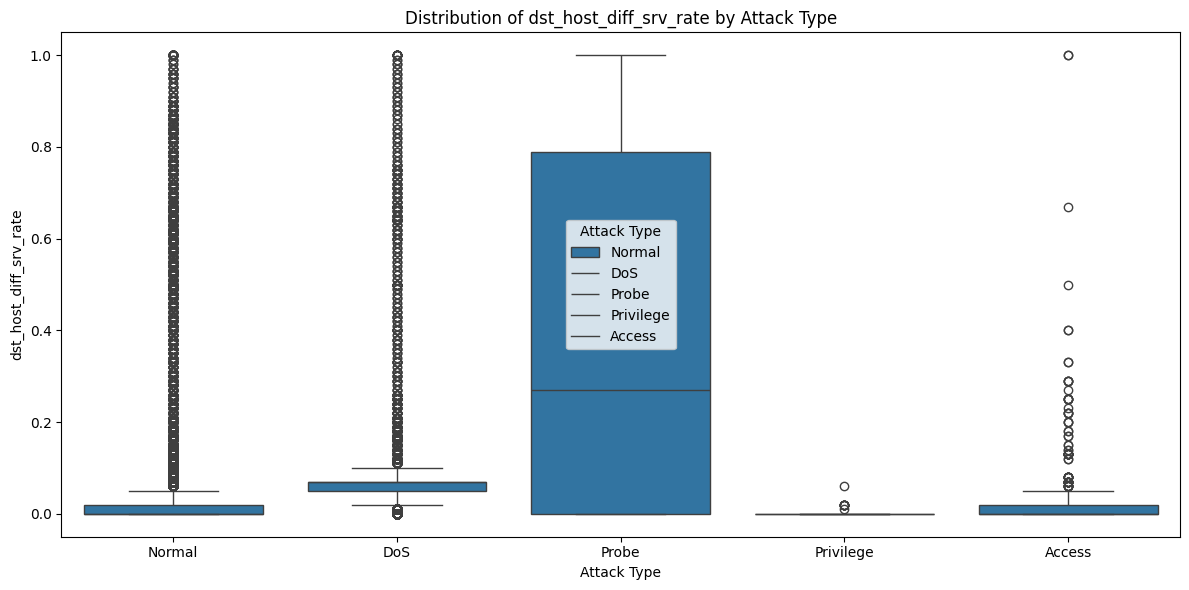

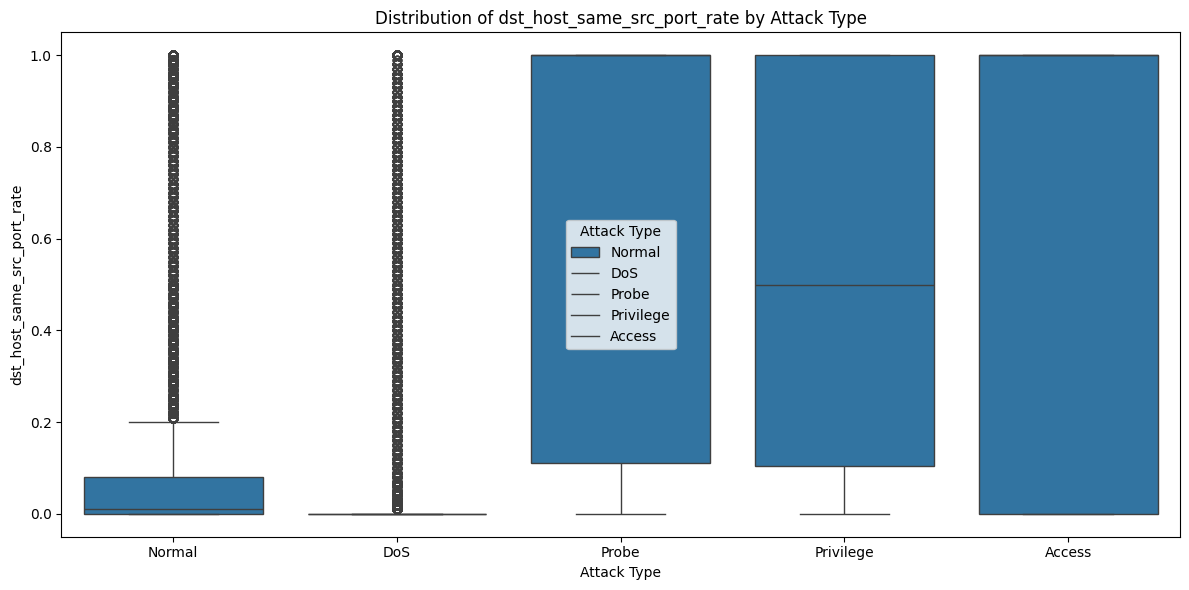

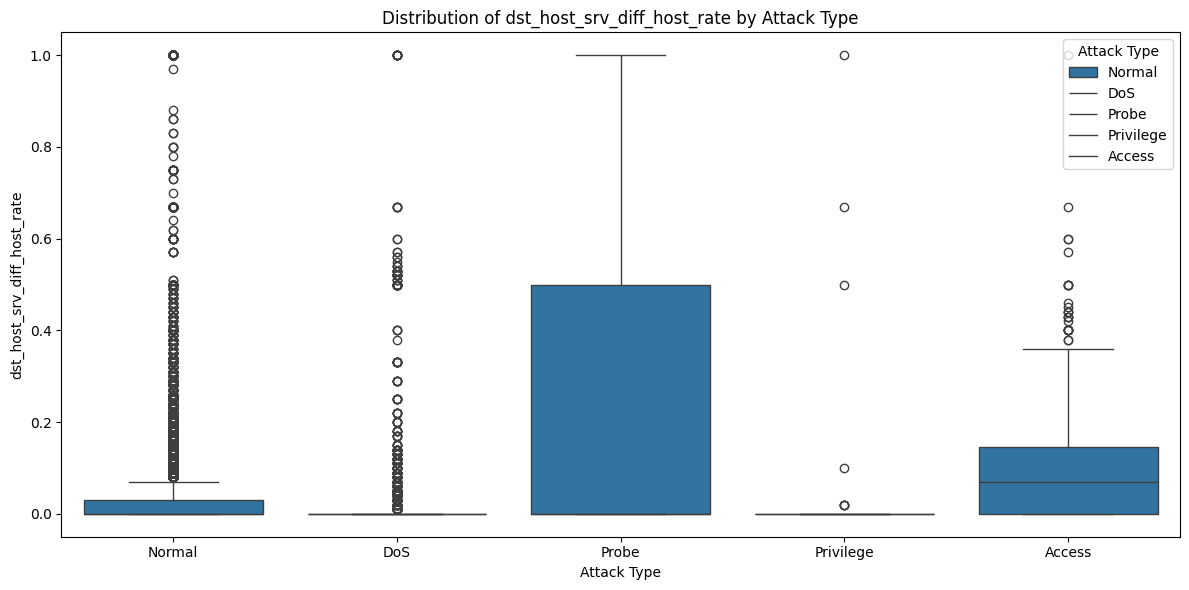

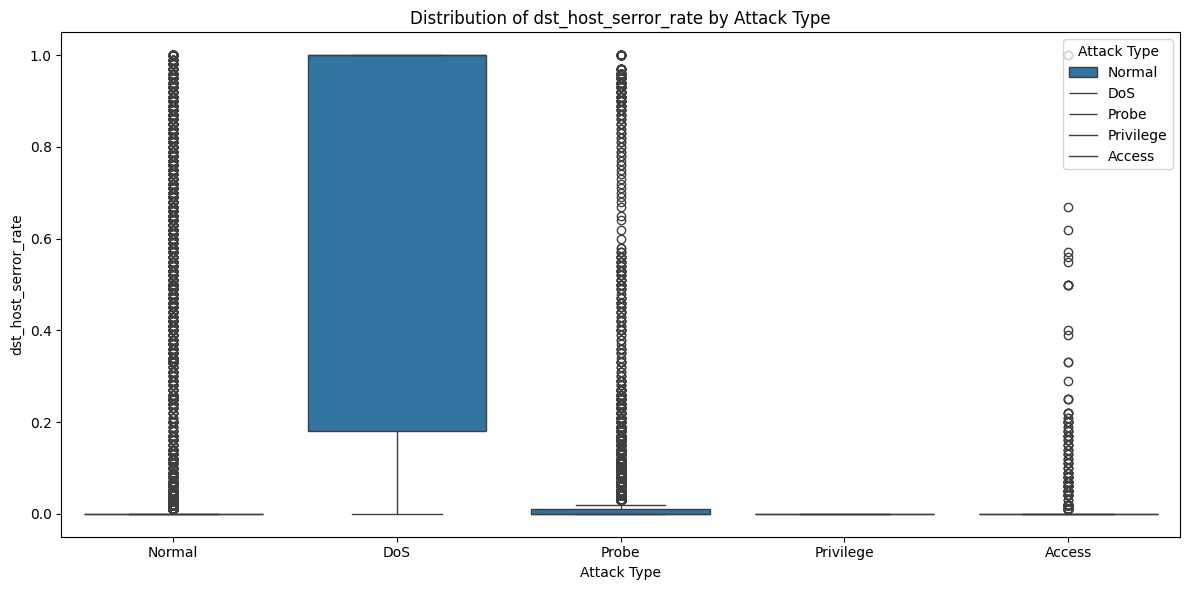

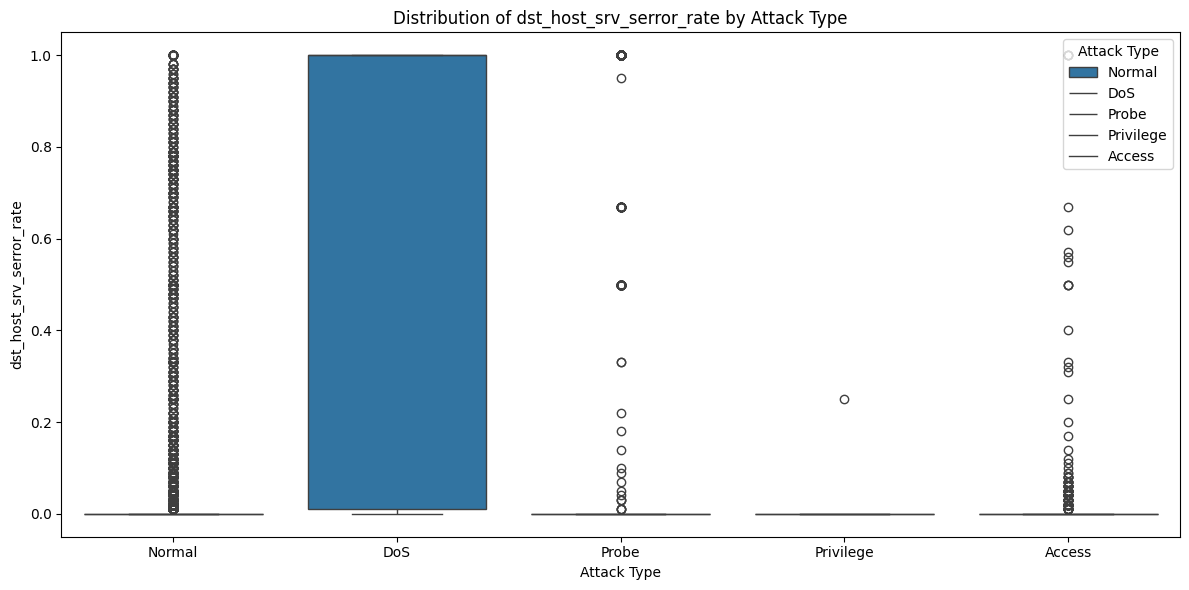

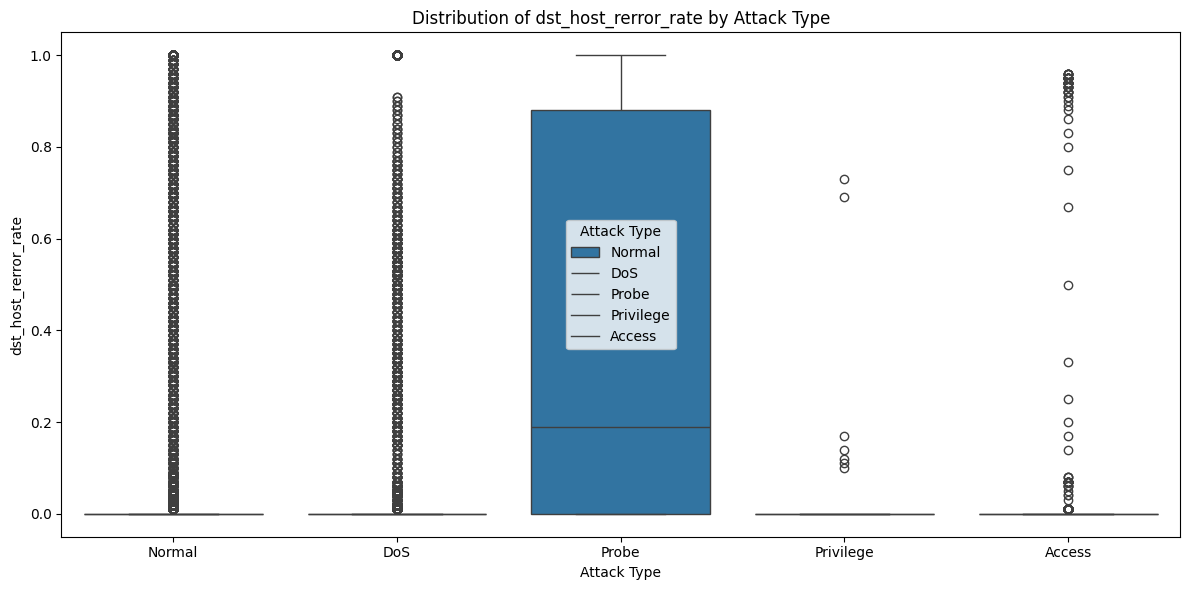

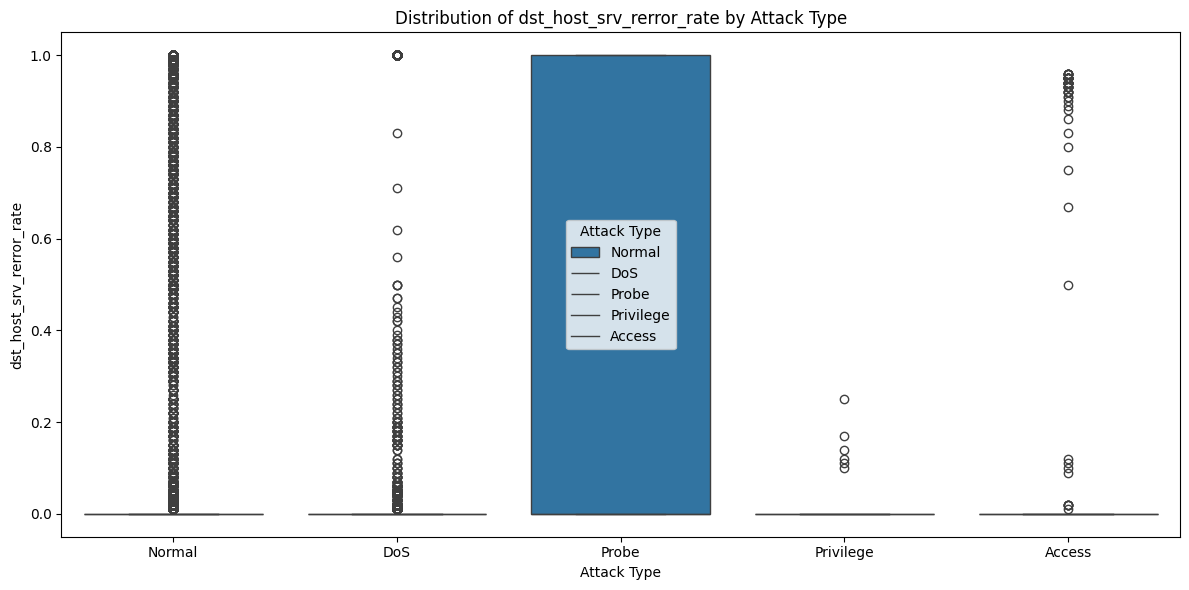

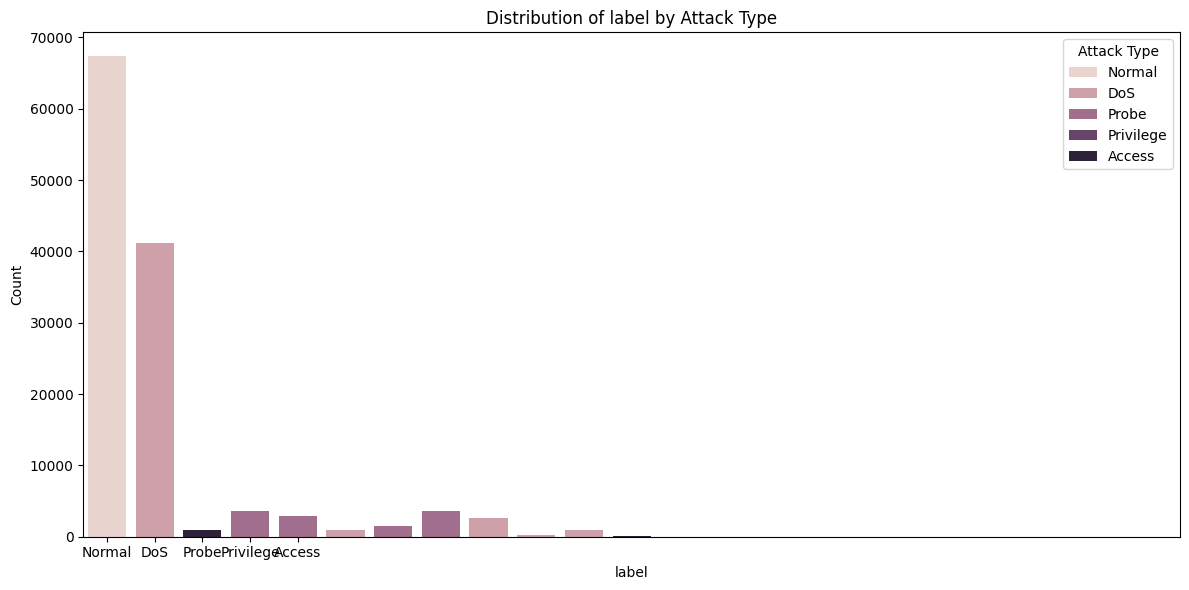

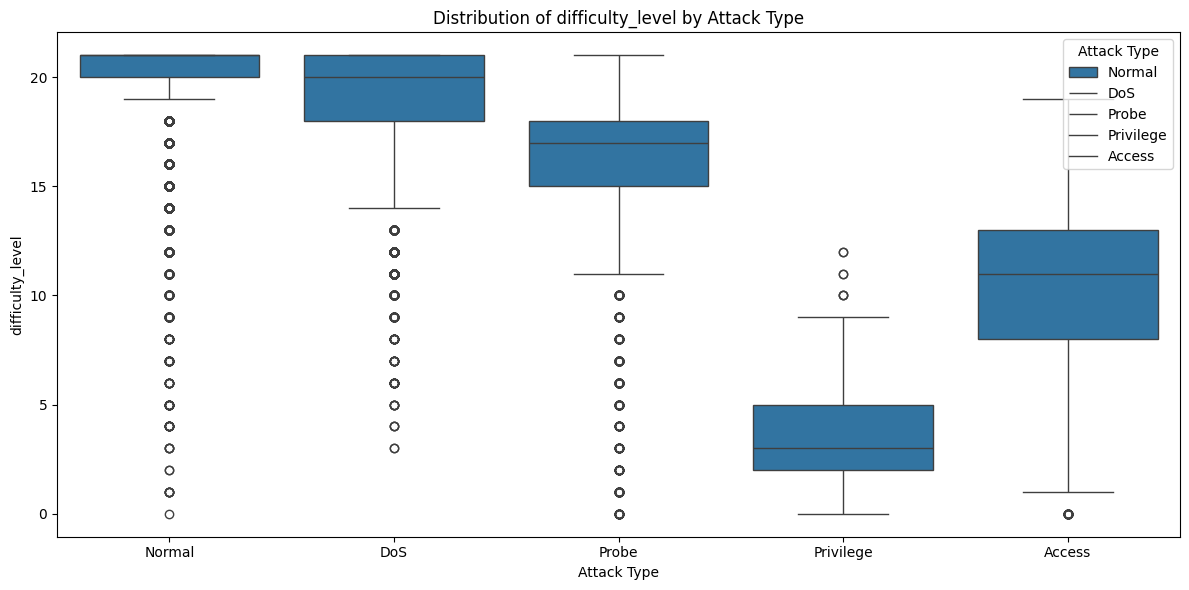

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(df, features, attack_map):
    attack_types = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Privilege', 4: 'Access'}

    for feature in features:
        plt.figure(figsize=(12, 6))

        if df[feature].dtype in ['int64', 'float64']:
            sns.boxplot(x='attack_map', y=feature, data=df, order=[0, 1, 2, 3, 4])
            plt.title(f'Distribution of {feature} by Attack Type')
            plt.xlabel('Attack Type')
            plt.ylabel(feature)
        else:
            sns.countplot(x=feature, hue='attack_map', data=df, hue_order=[0, 1, 2, 3, 4])
            plt.title(f'Distribution of {feature} by Attack Type')
            plt.xlabel(feature)
            plt.ylabel('Count')

        plt.xticks(range(5), [attack_types[i] for i in range(5)])
        plt.legend(title='Attack Type', labels=[attack_types[i] for i in range(5)])
        plt.tight_layout()
        plt.show()

features = train_data.columns.tolist()
features.remove('attack_flag')
features.remove('attack_map')

plot_feature_distributions(train_data, features, 'attack_map')

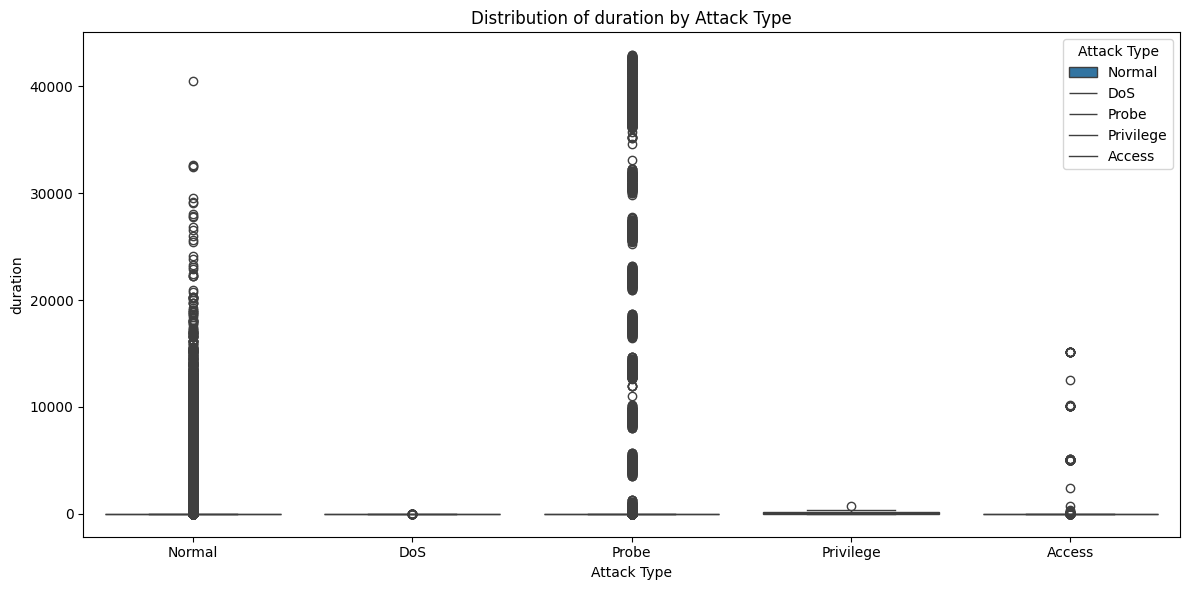

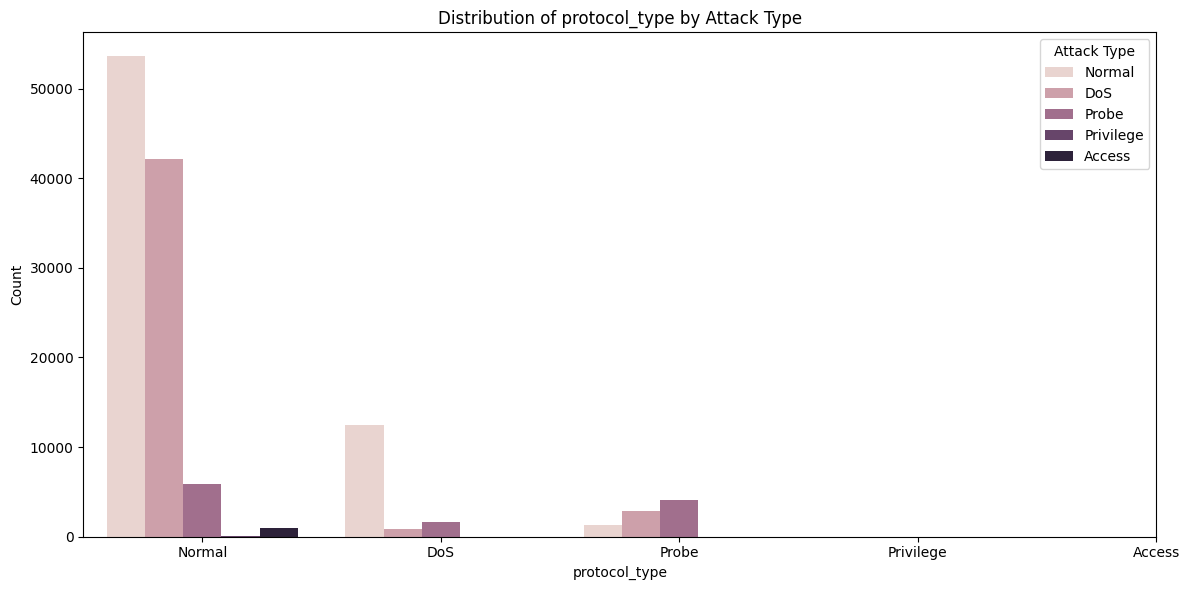

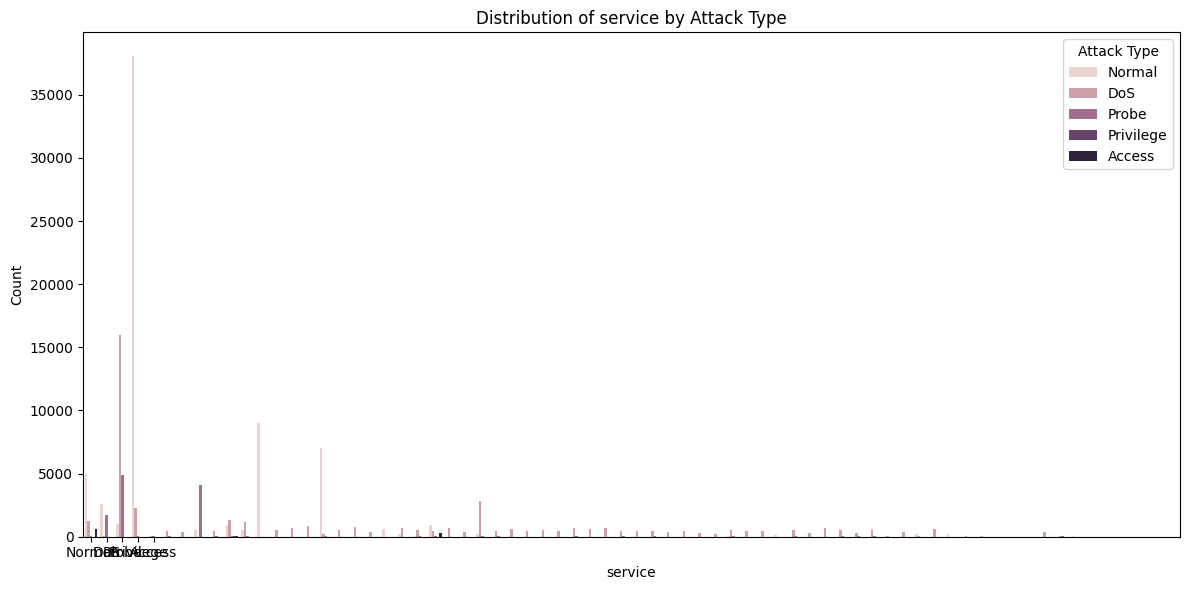

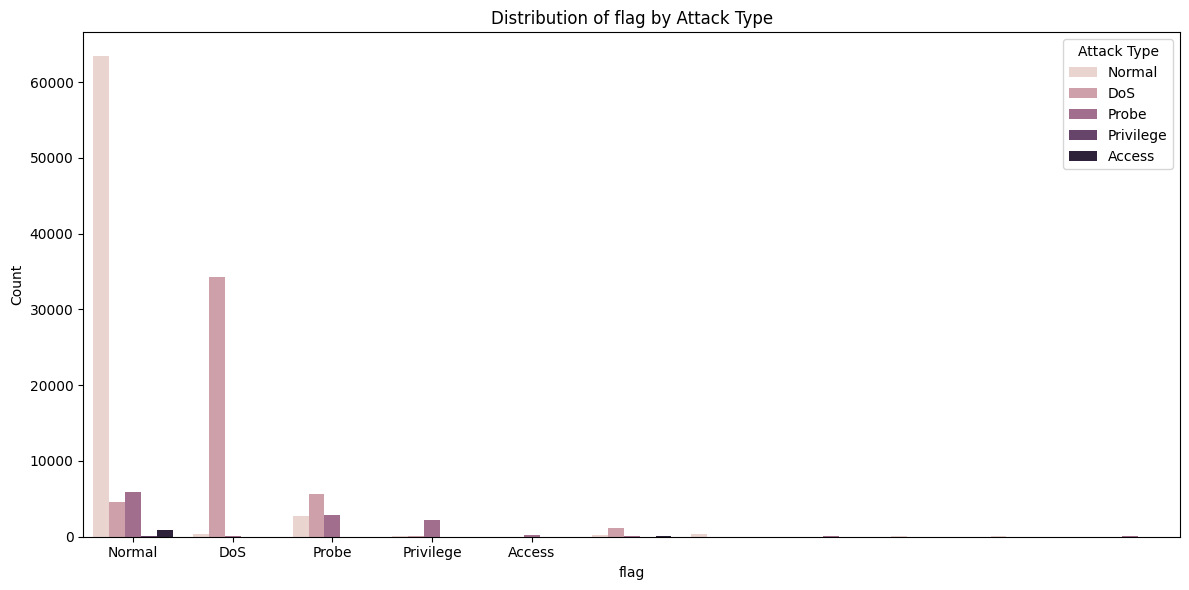

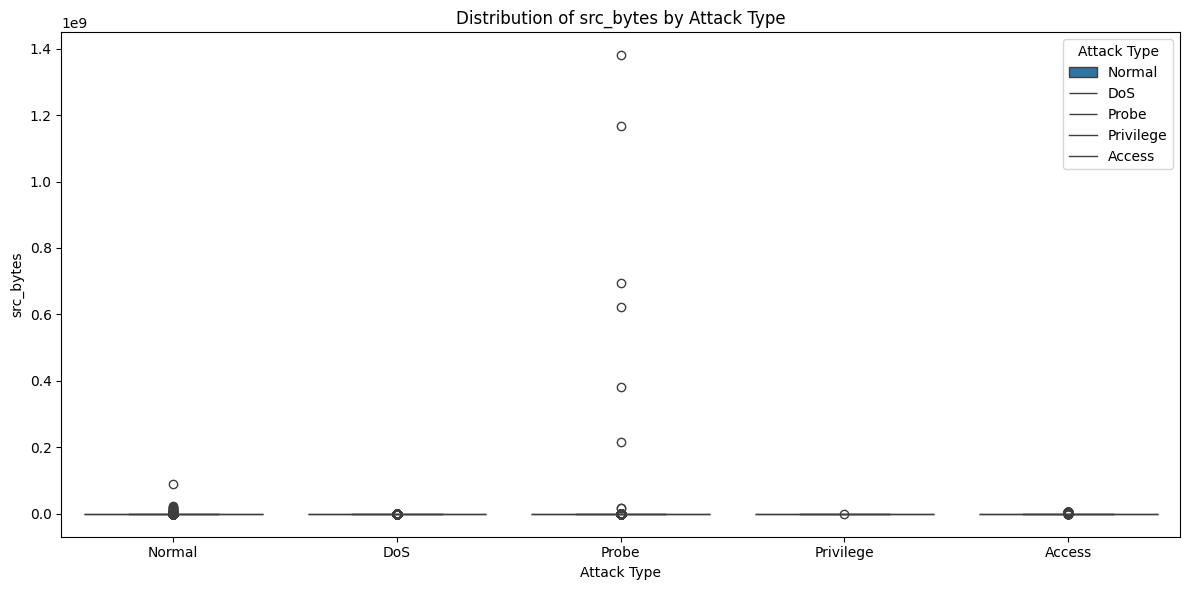

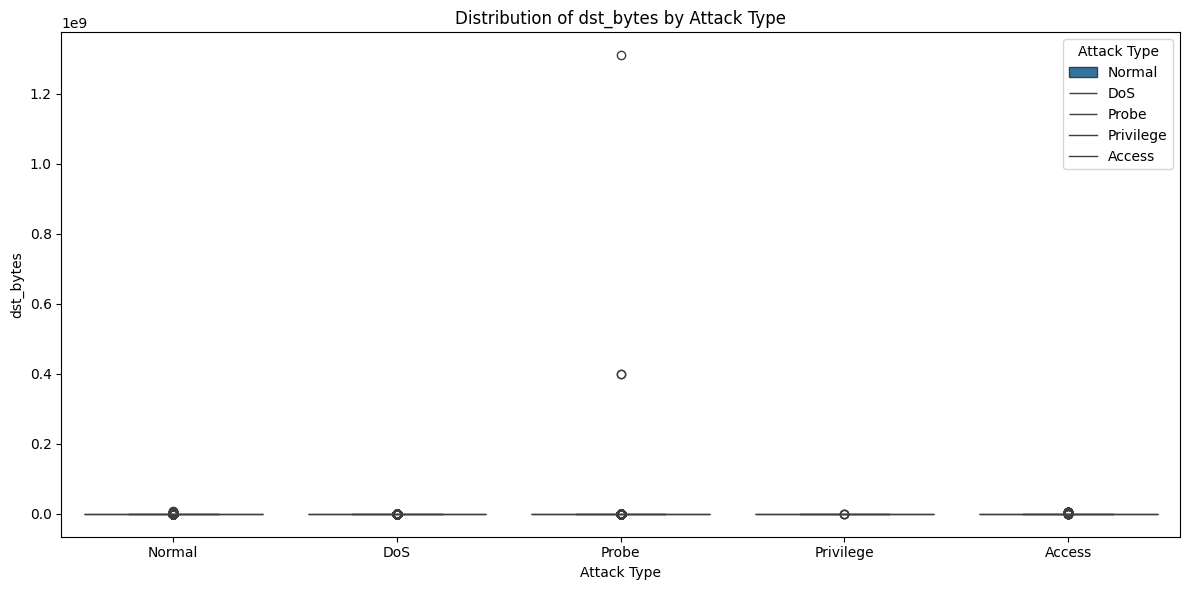

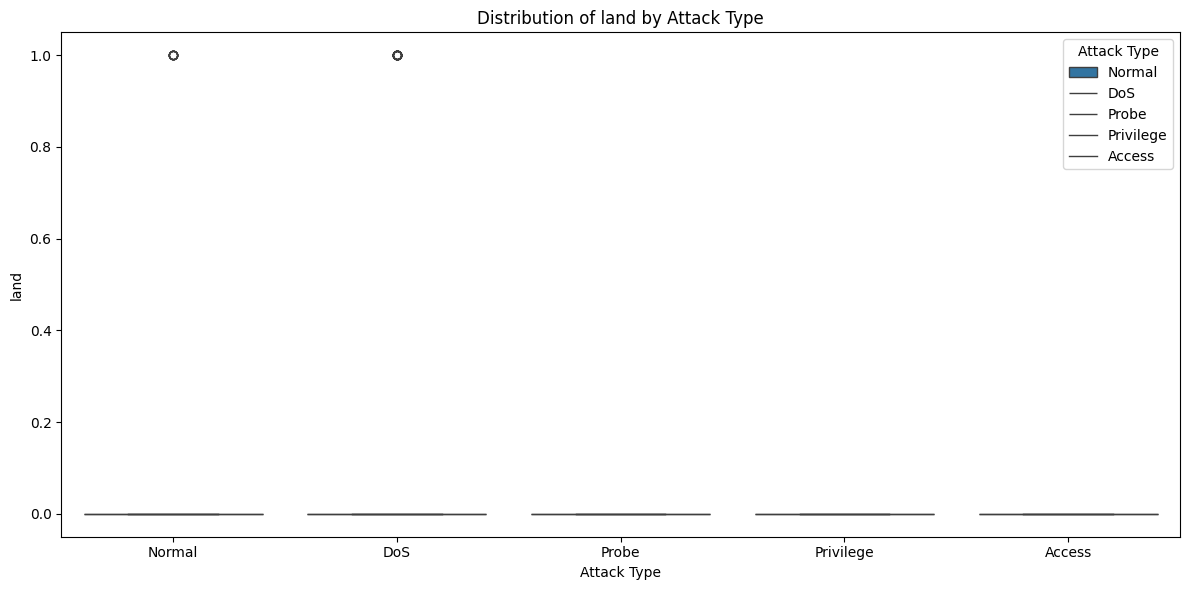

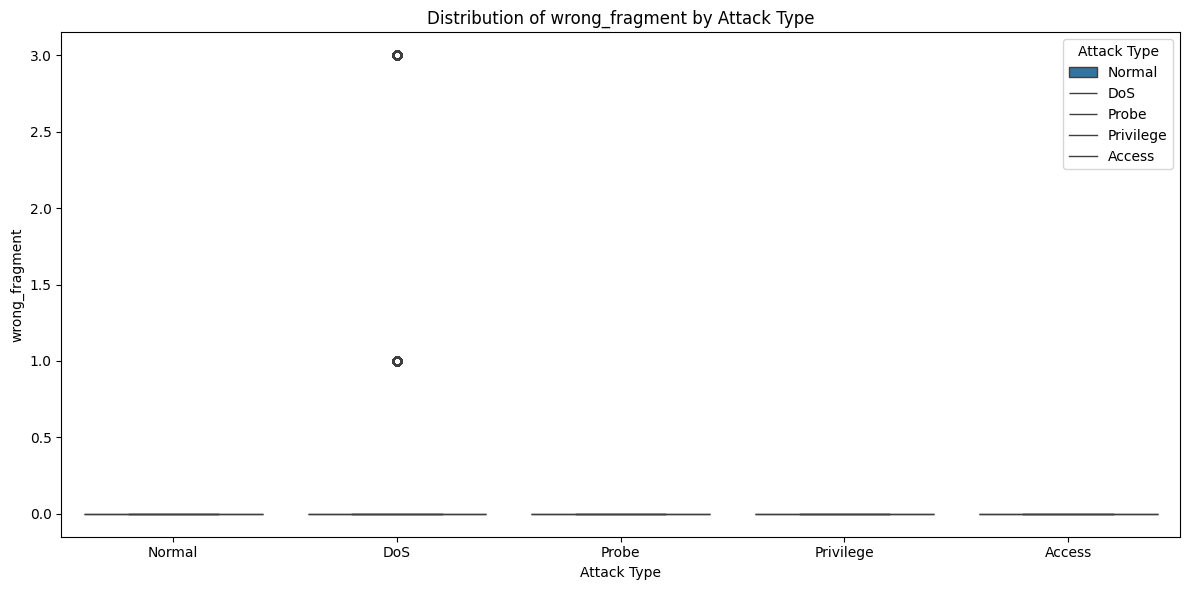

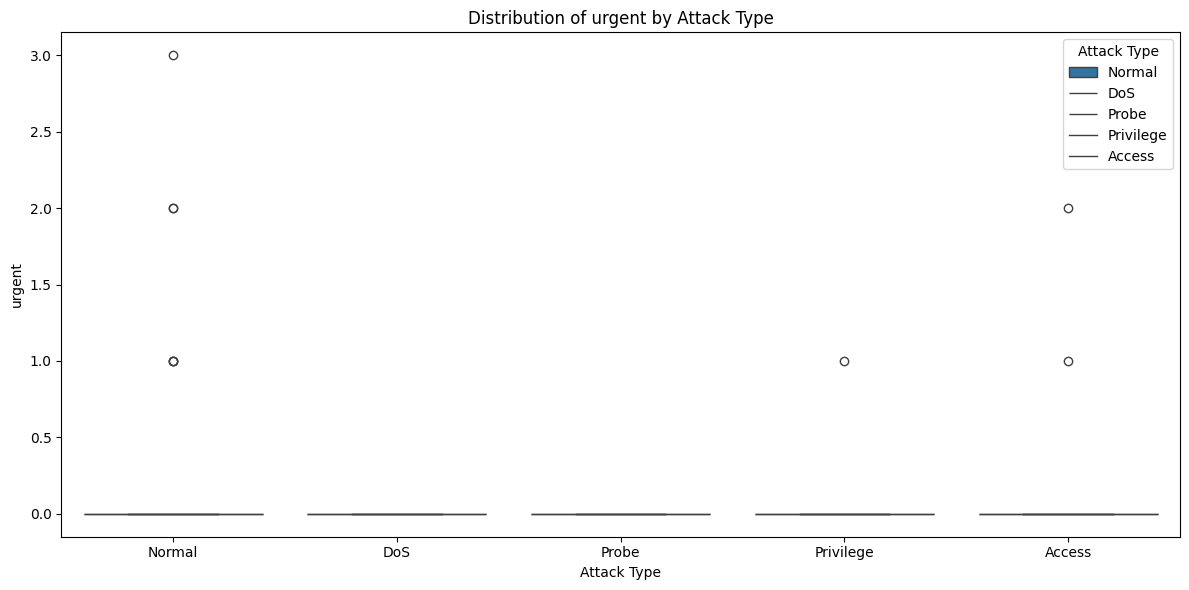

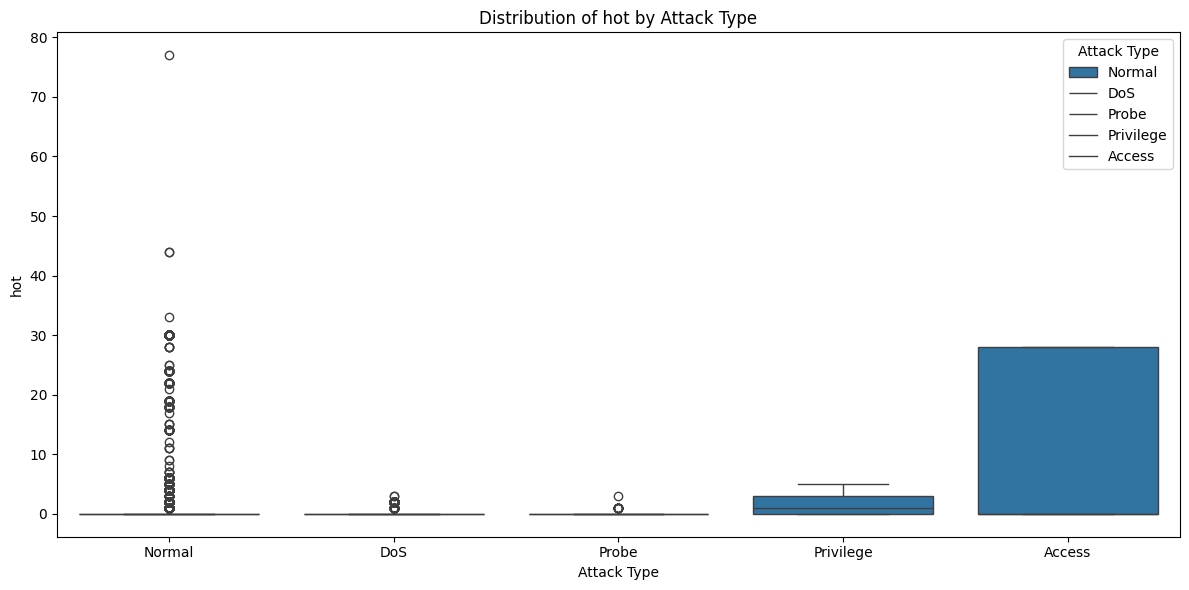

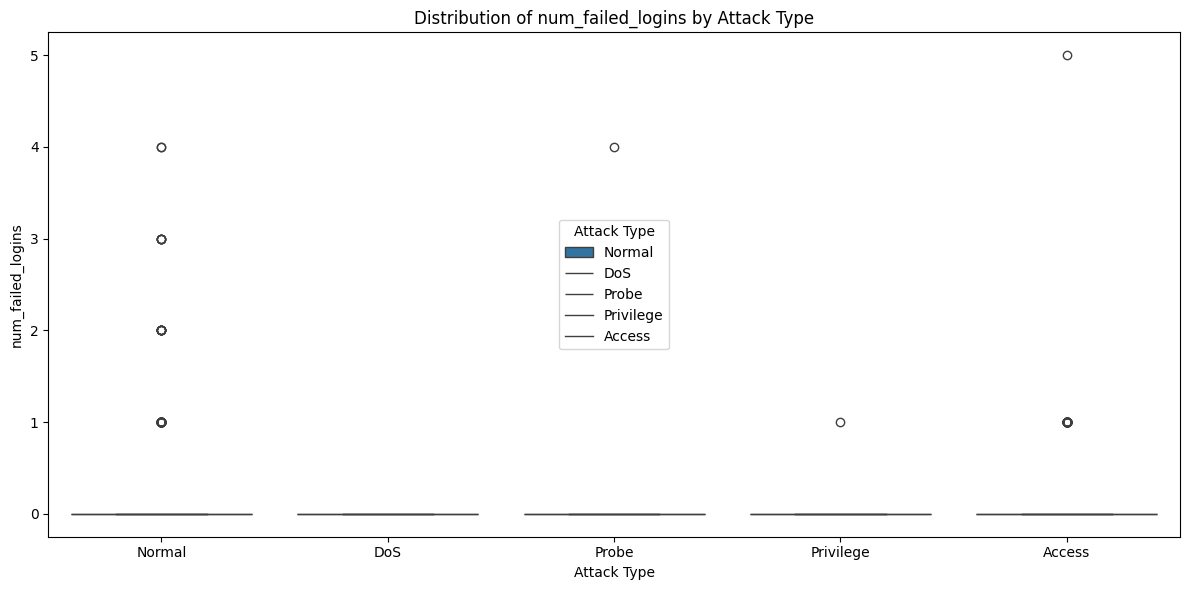

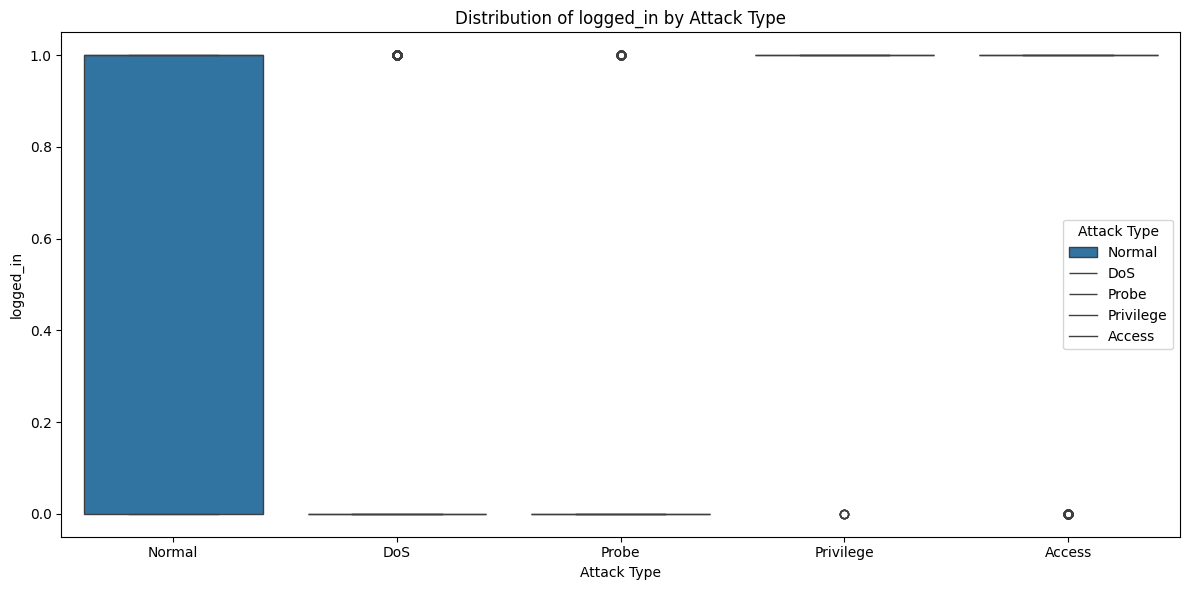

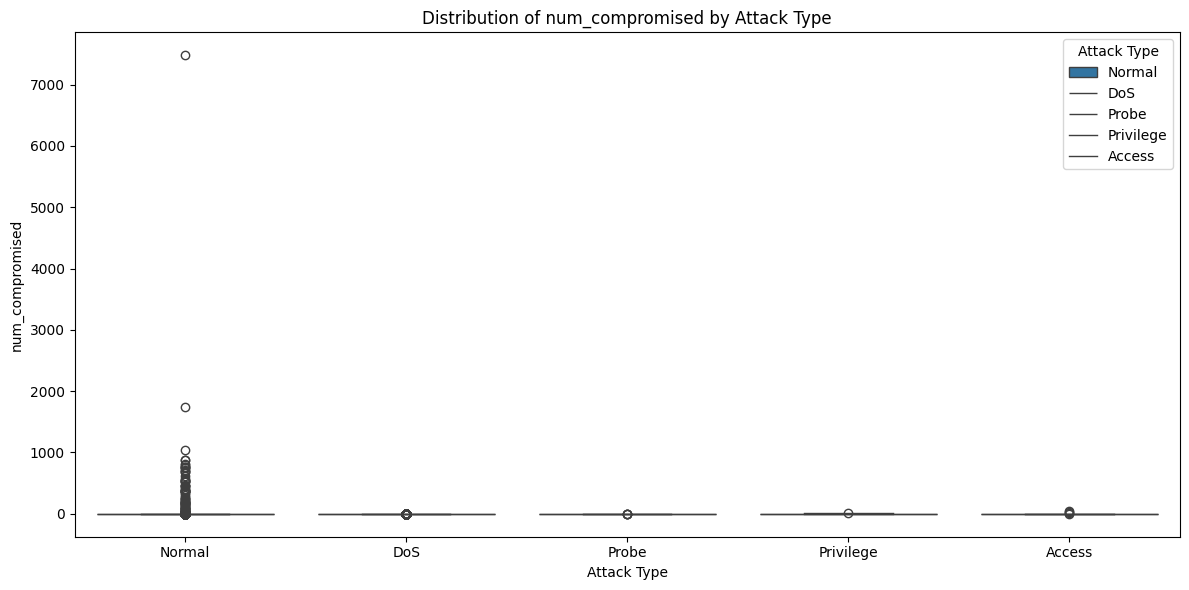

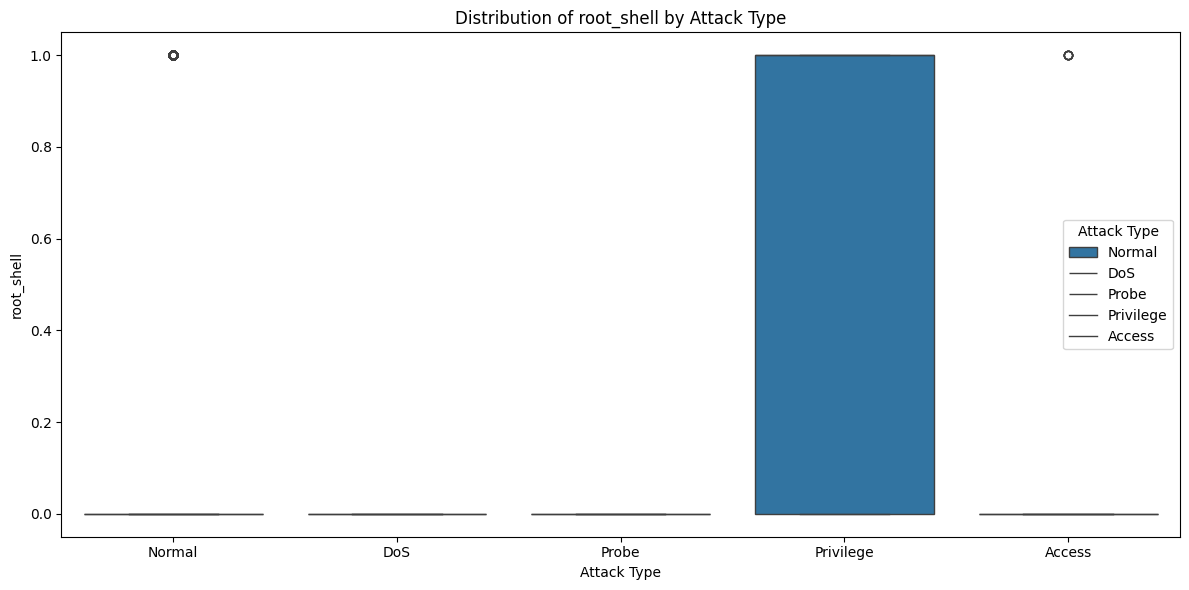

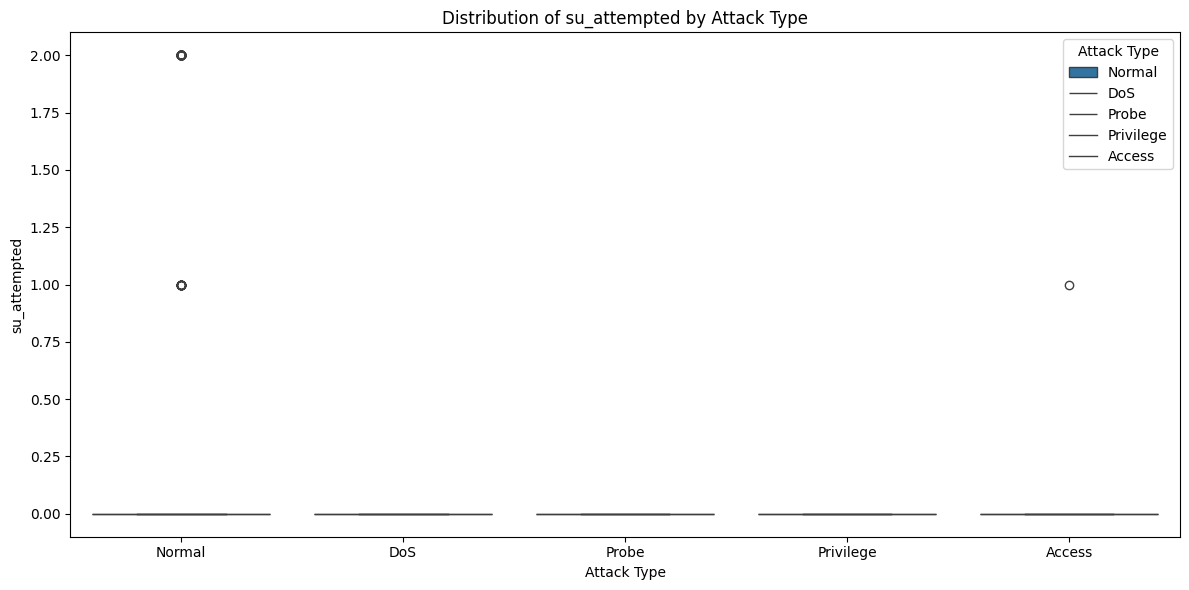

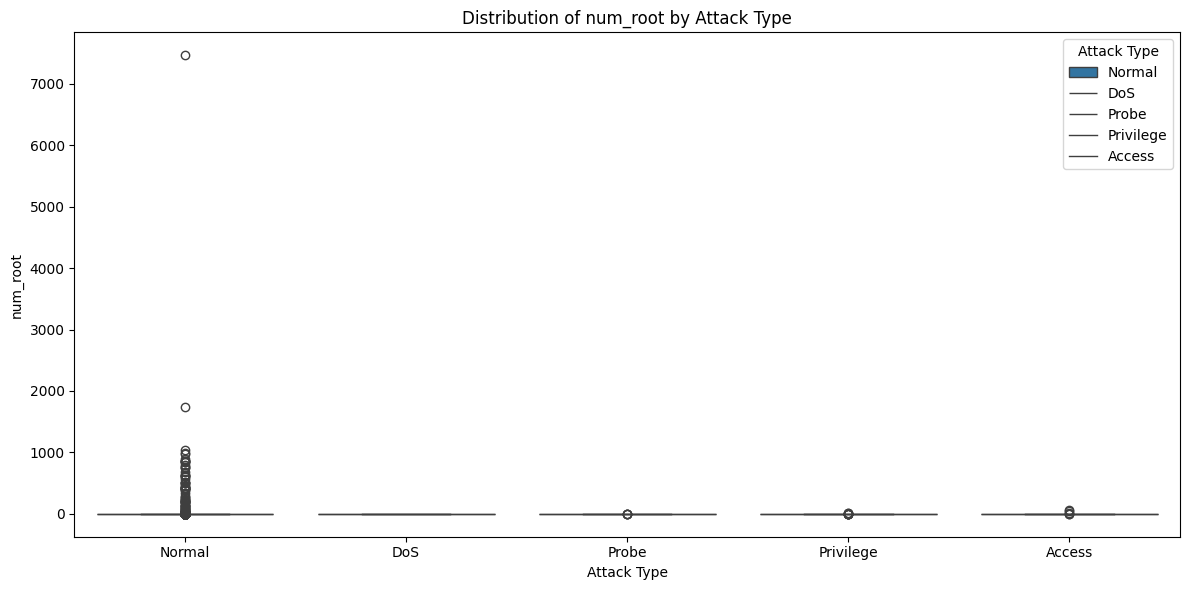

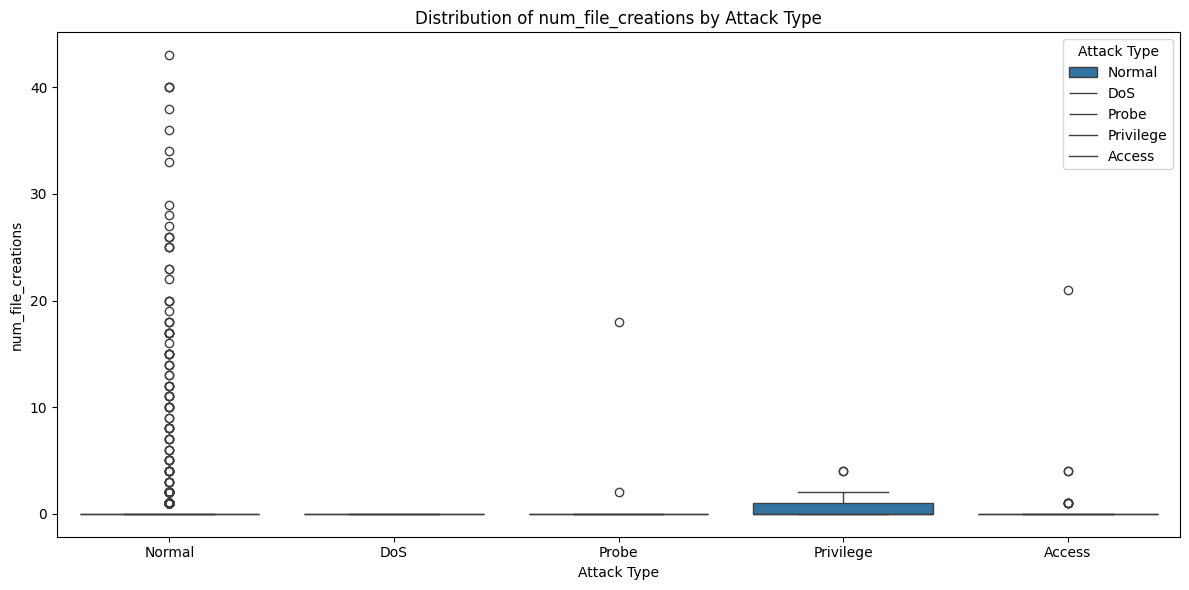

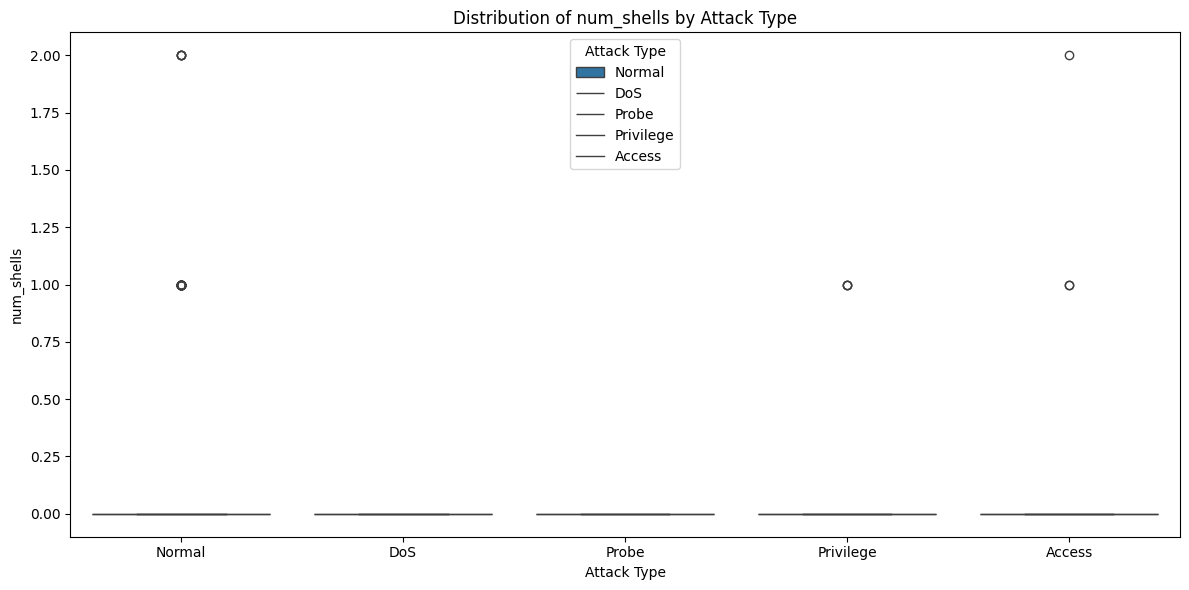

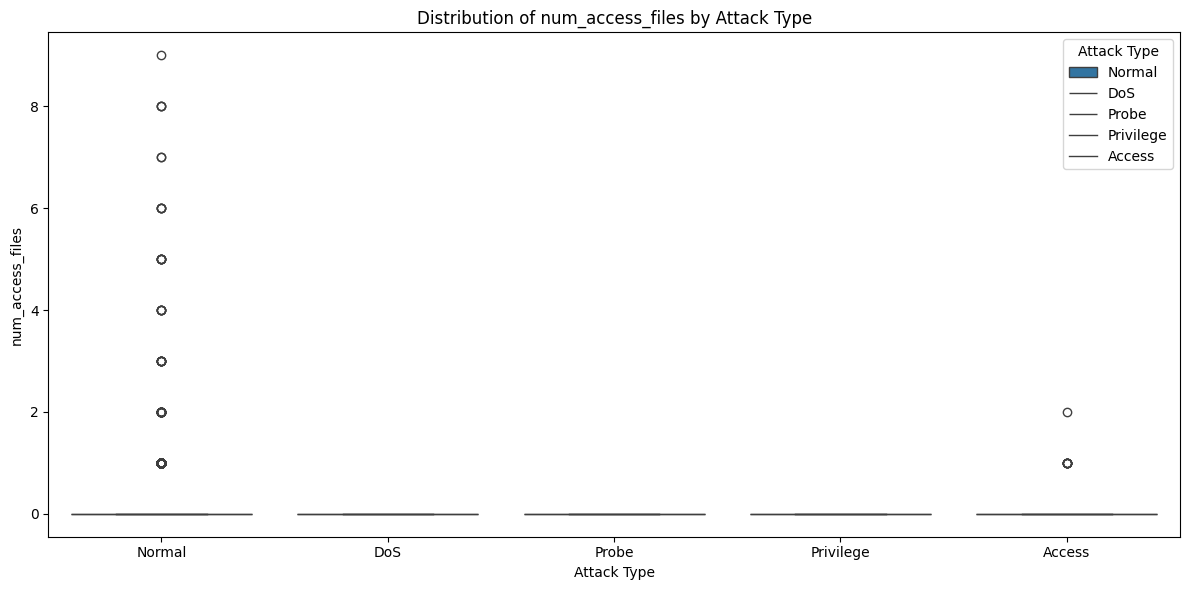

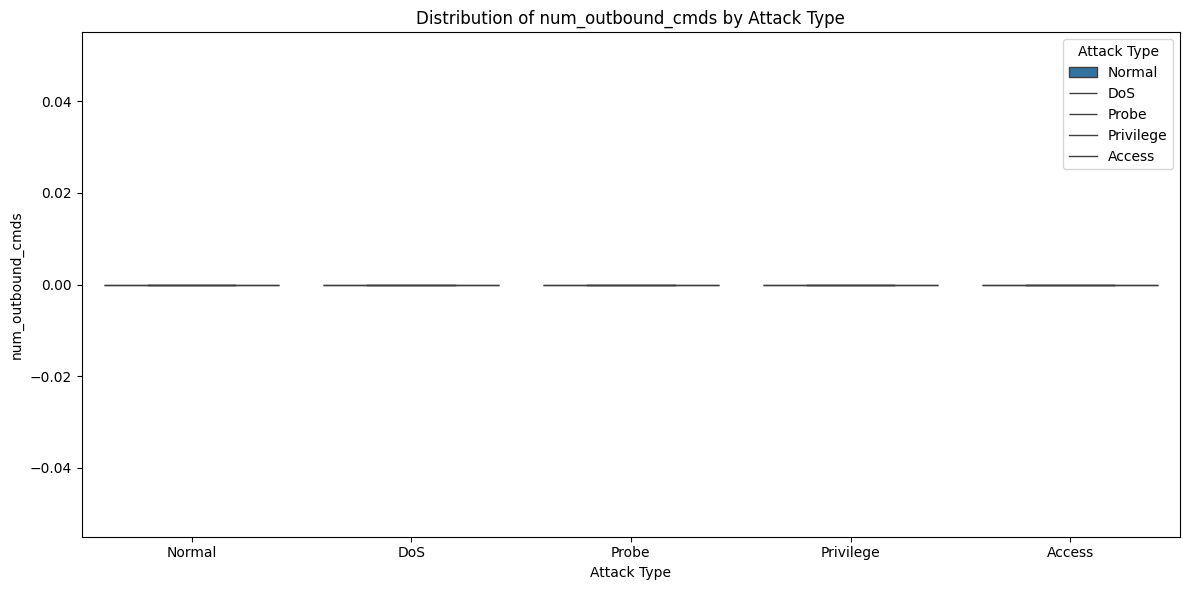

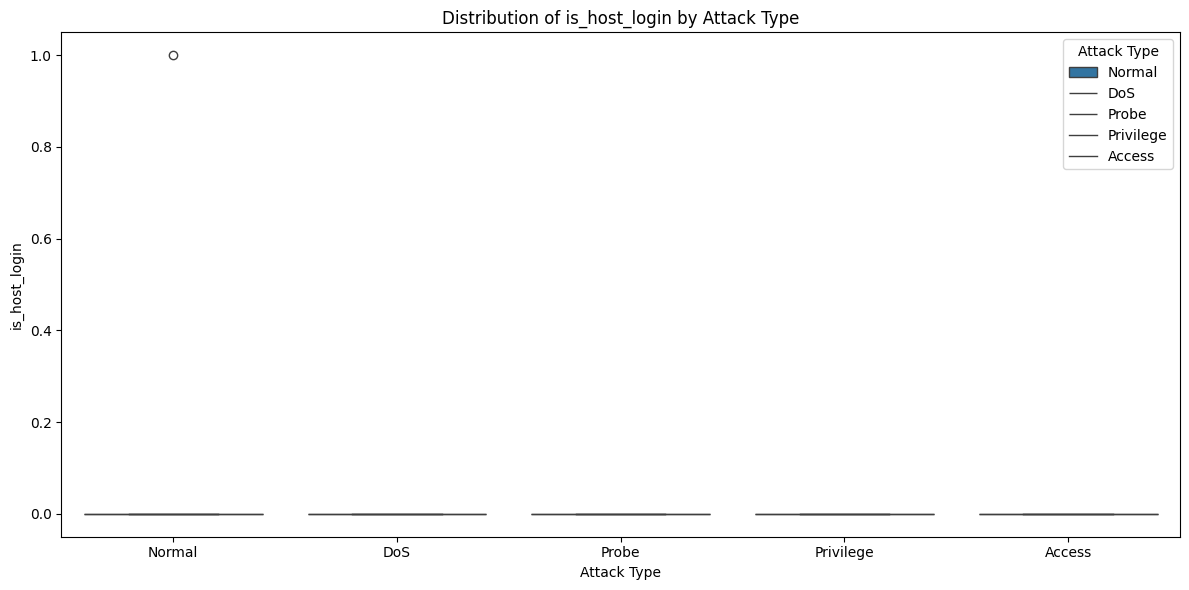

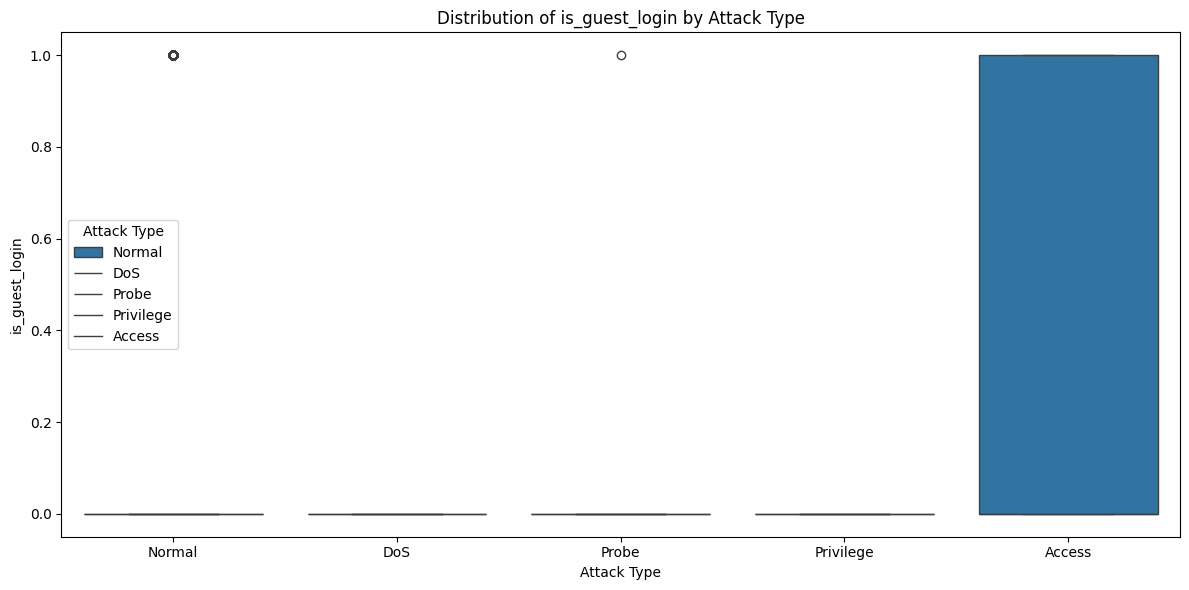

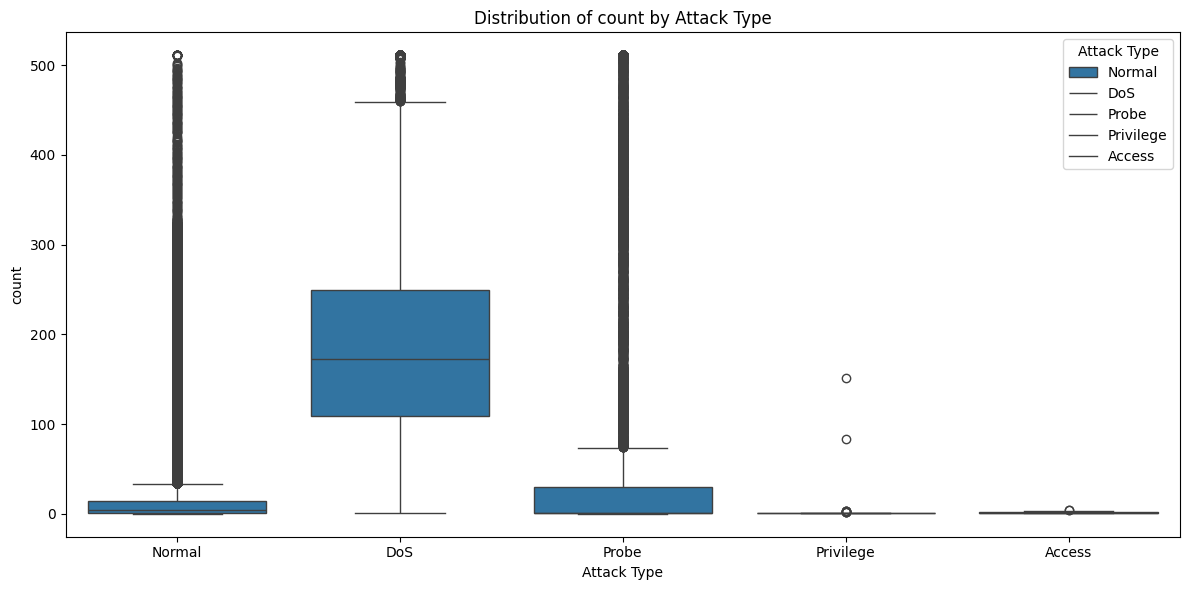

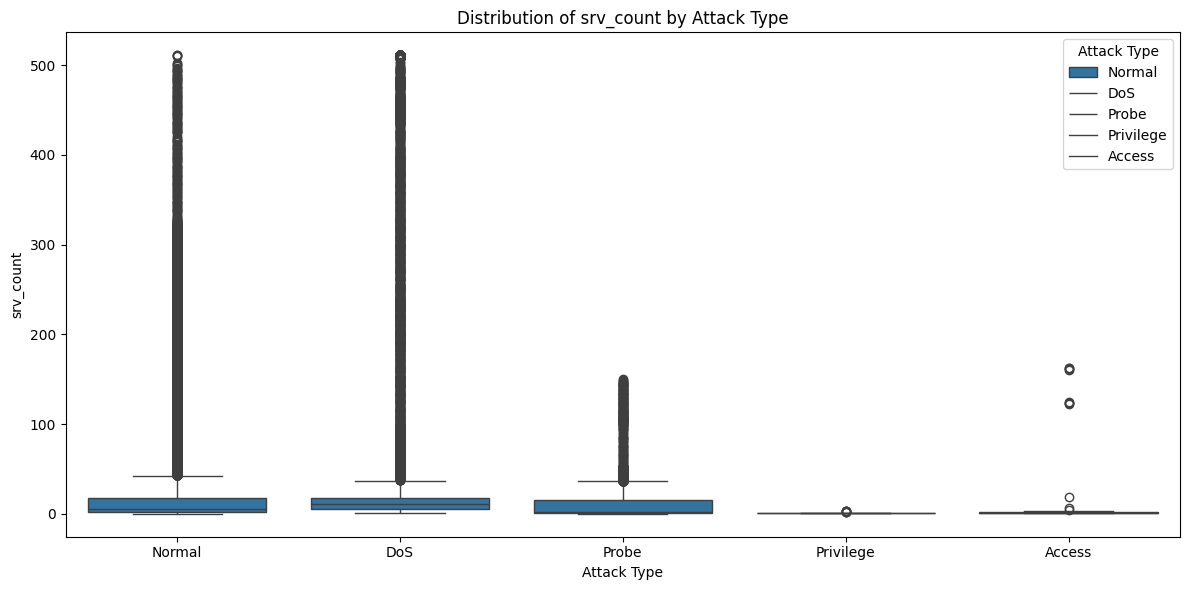

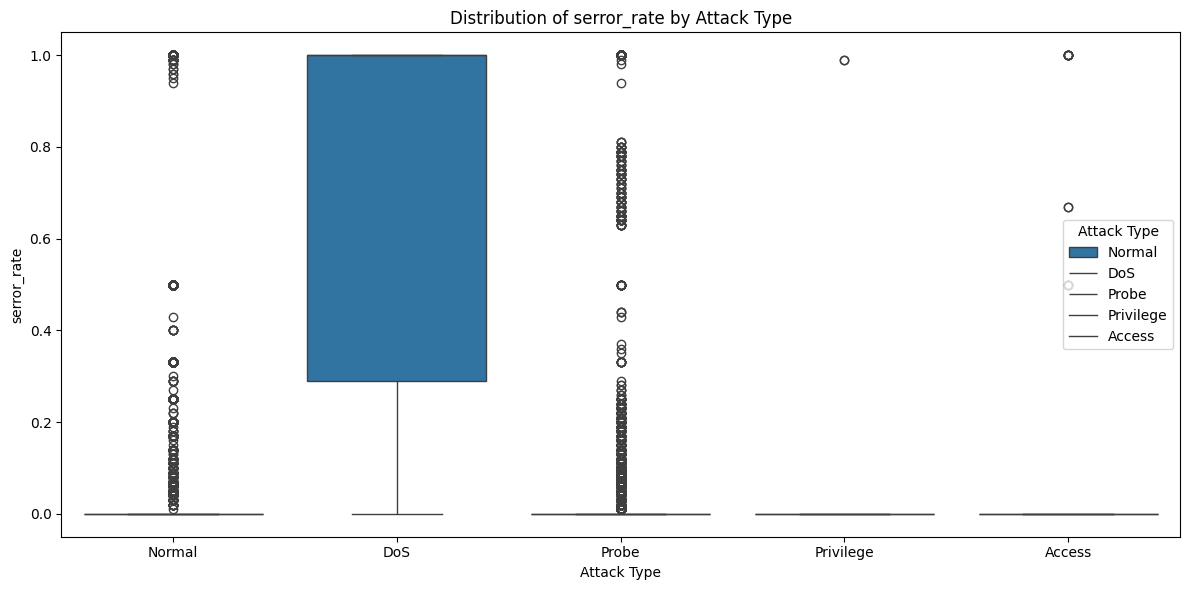

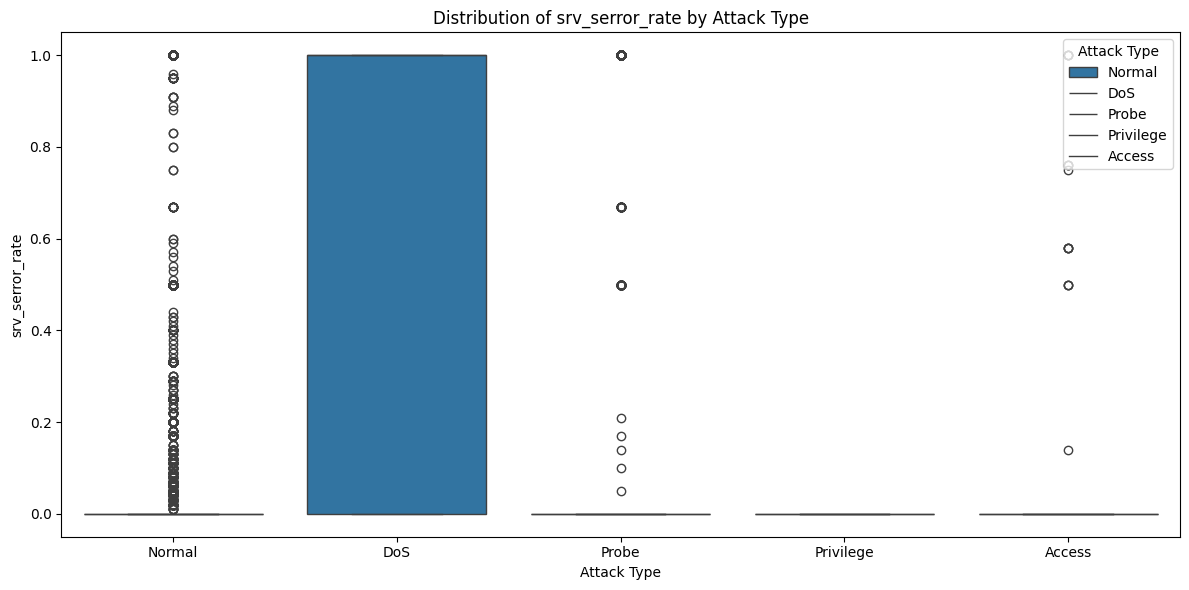

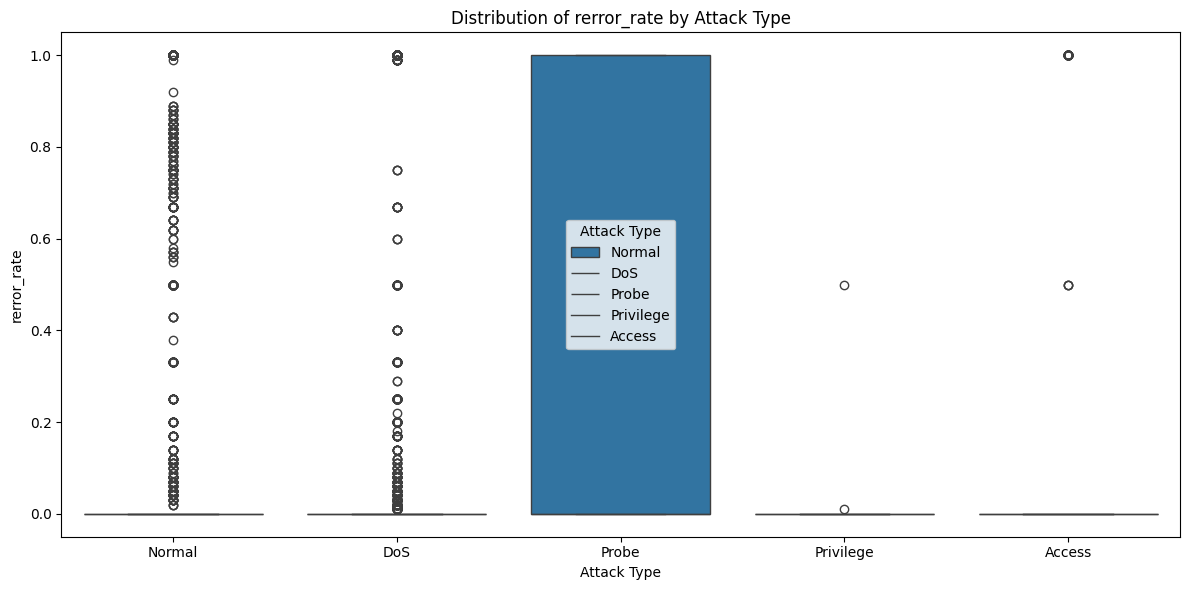

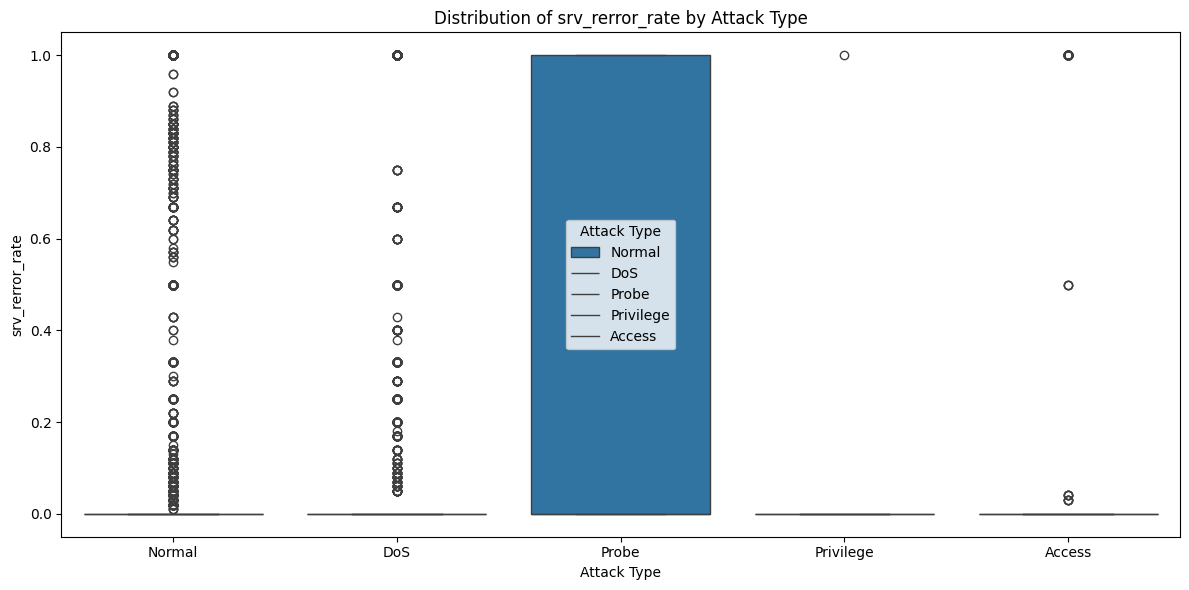

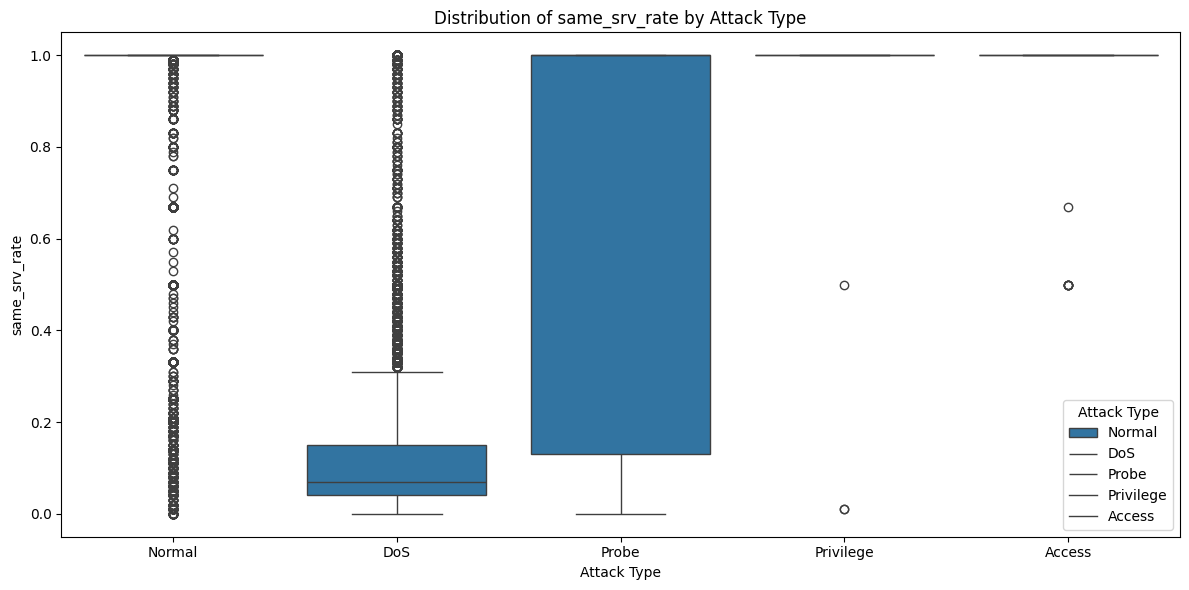

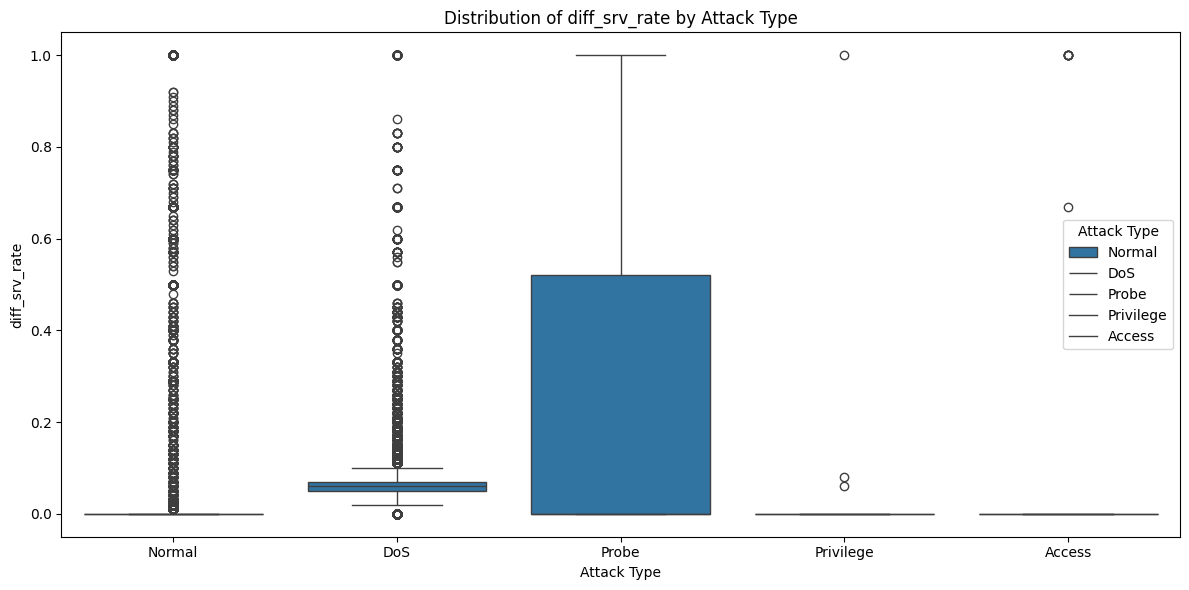

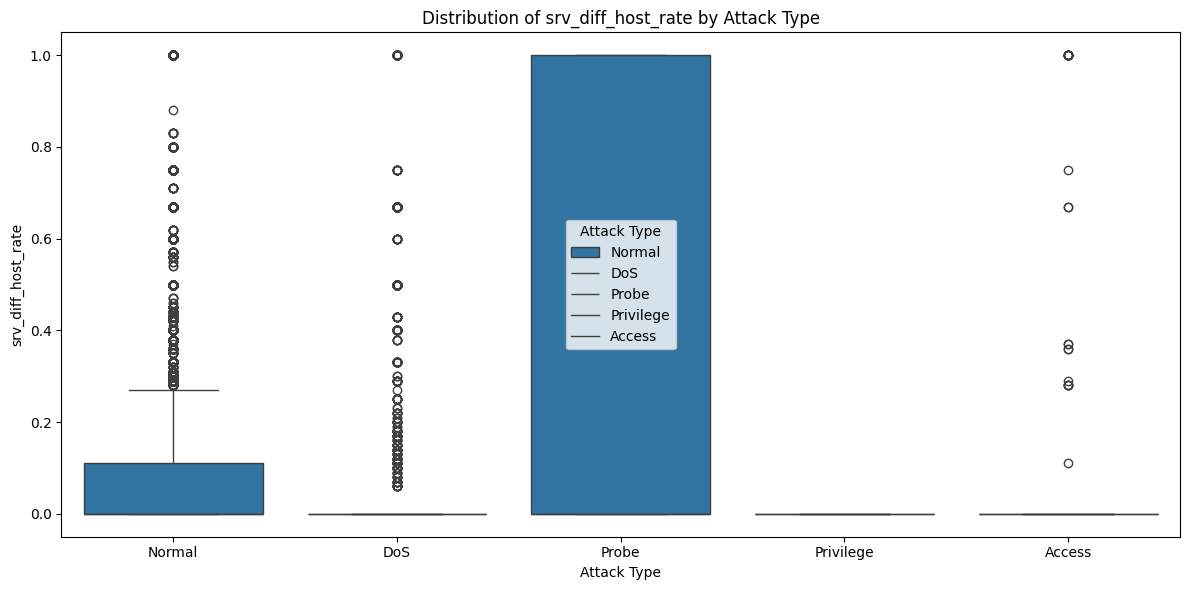

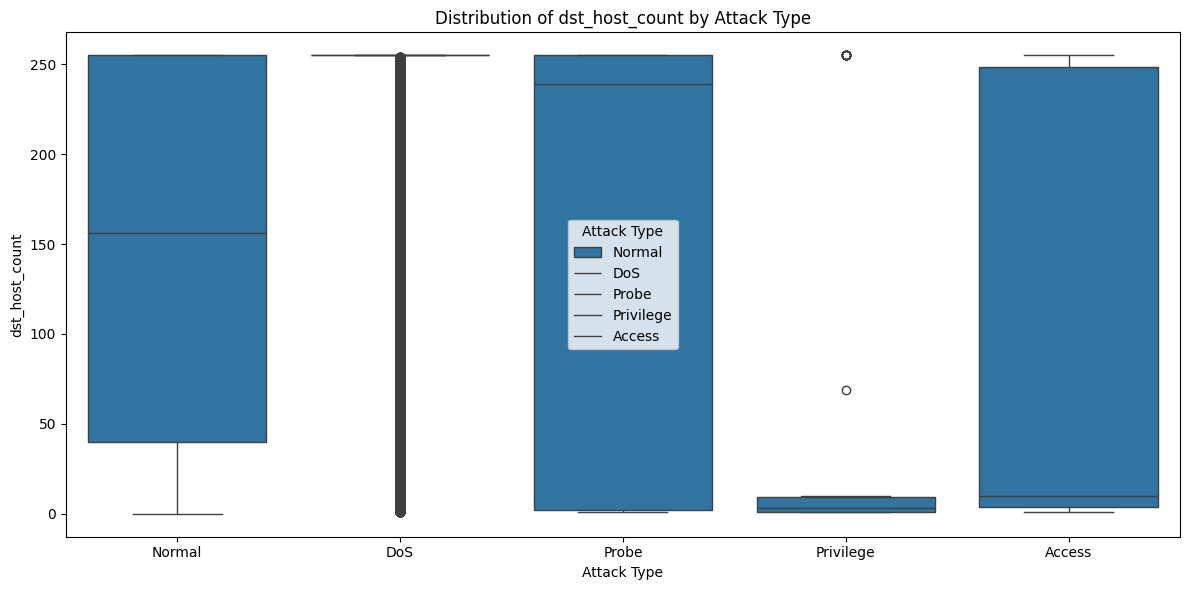

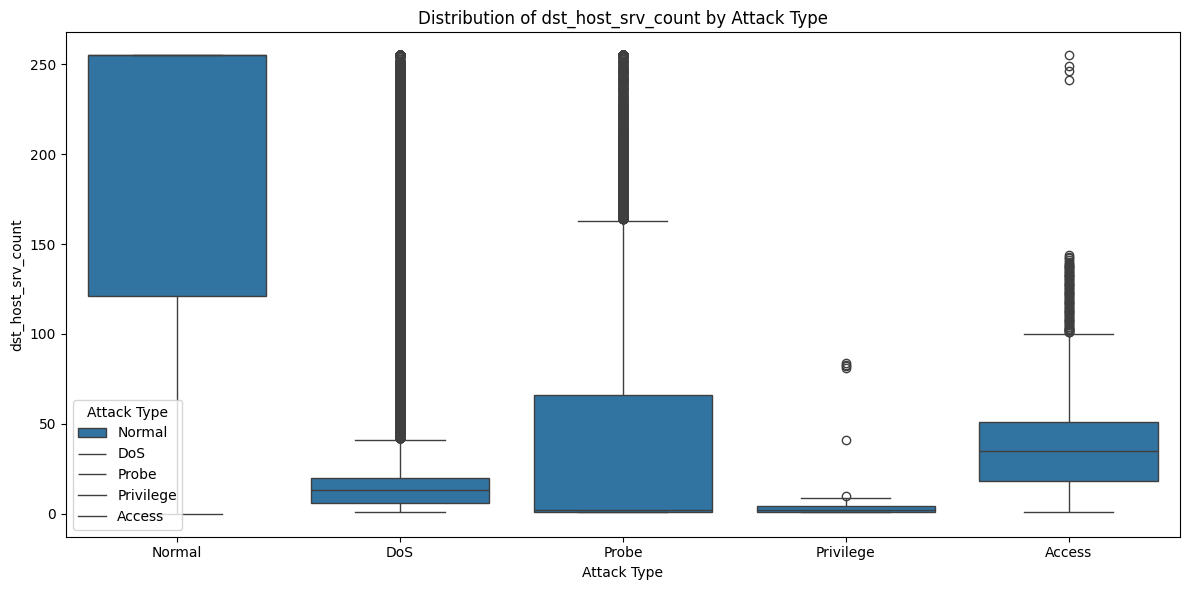

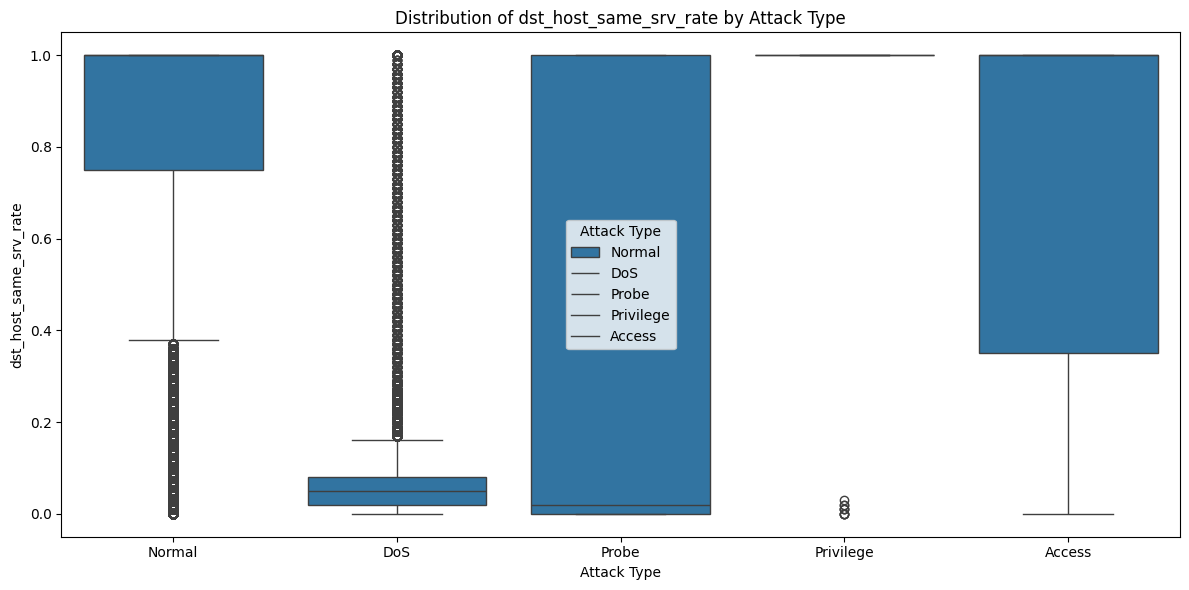

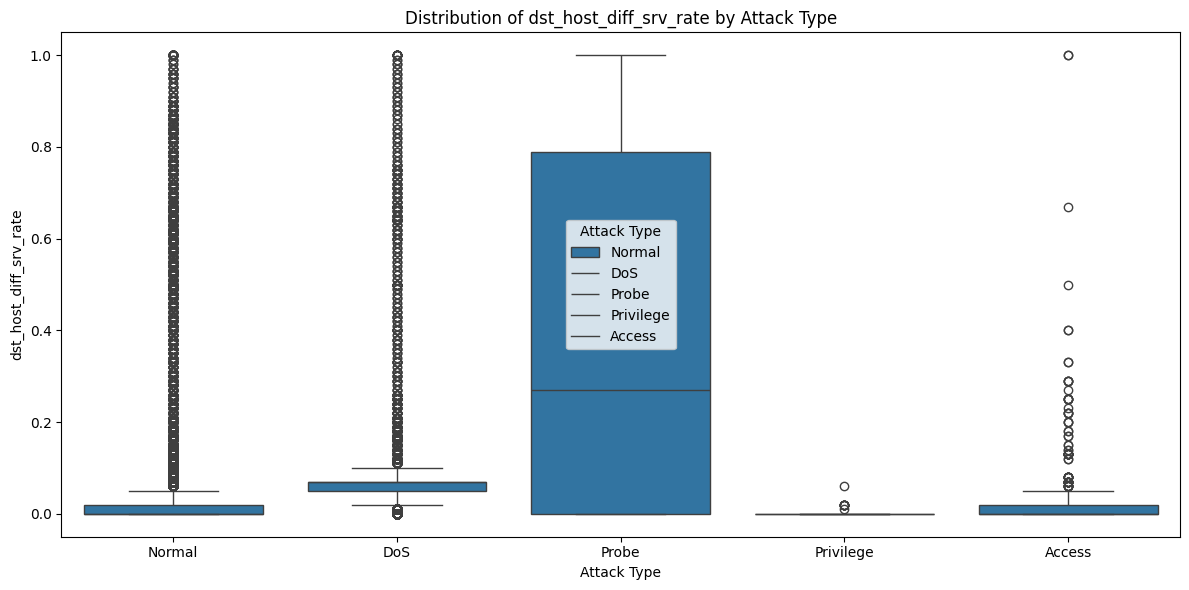

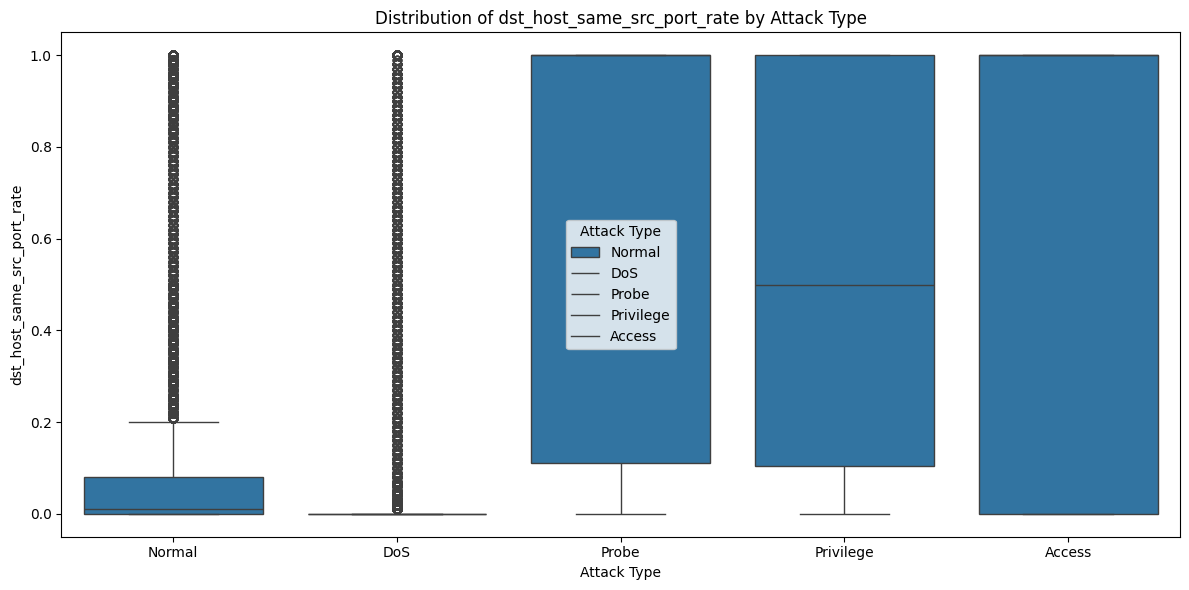

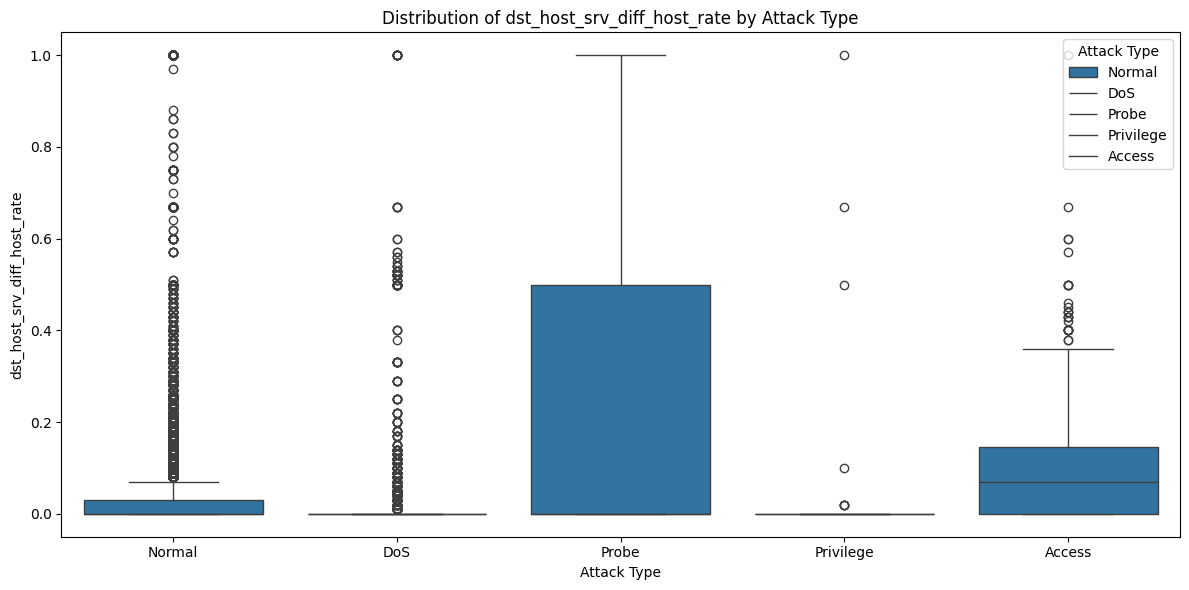

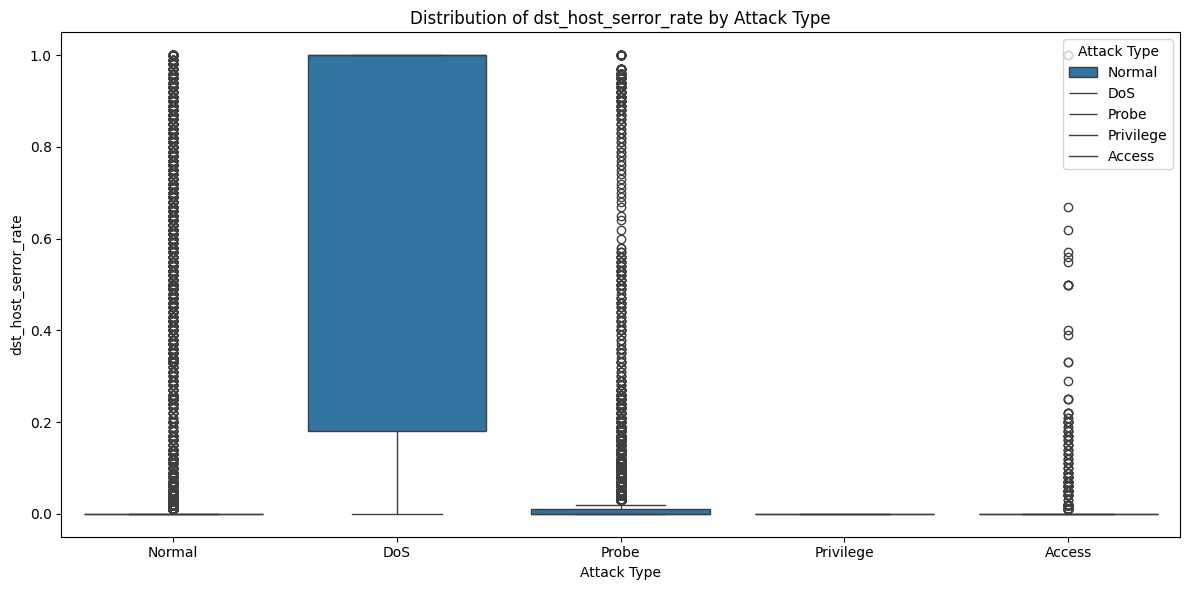

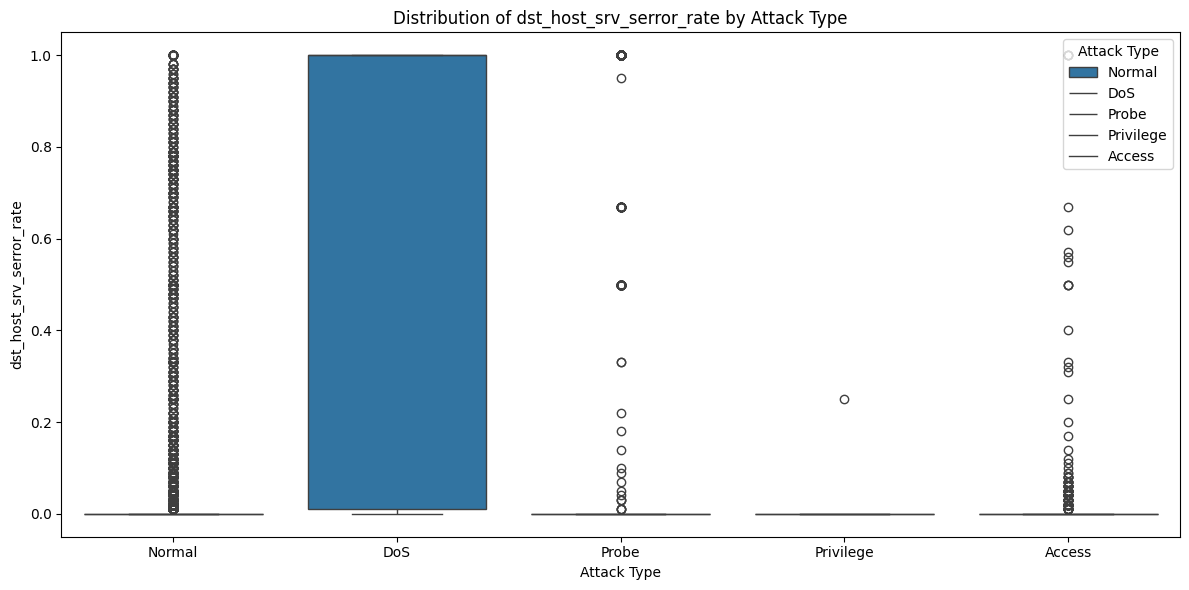

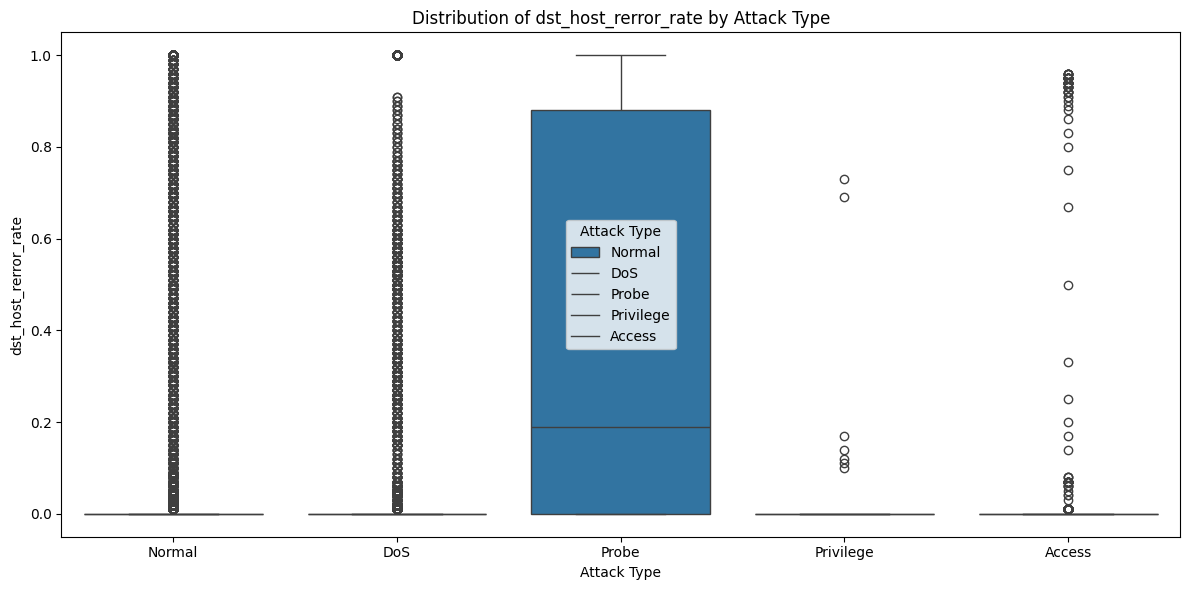

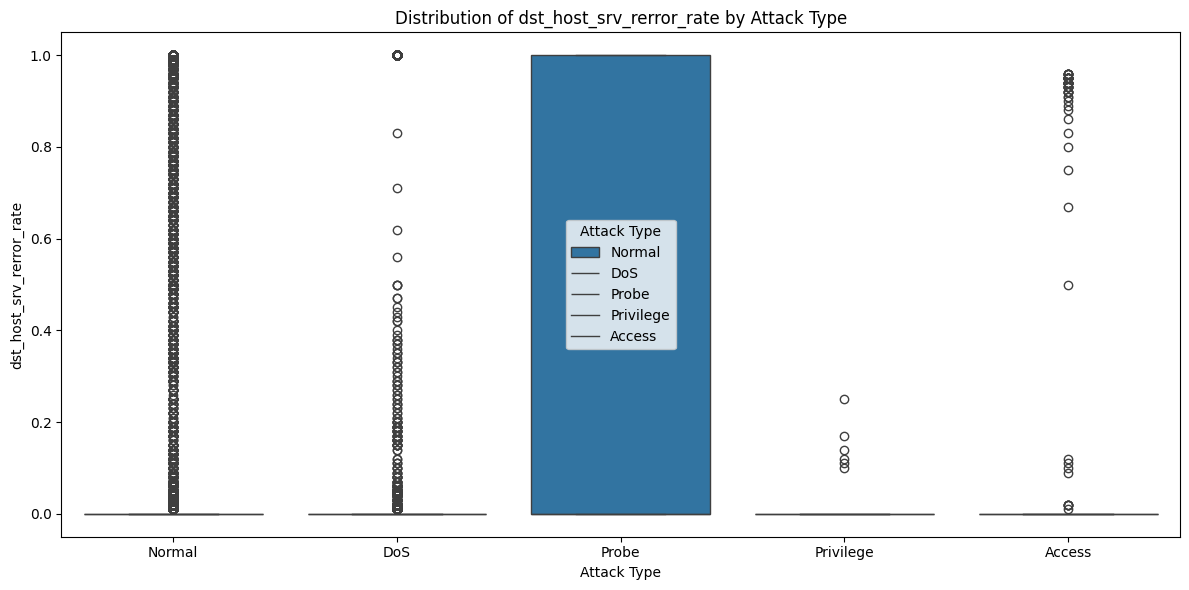

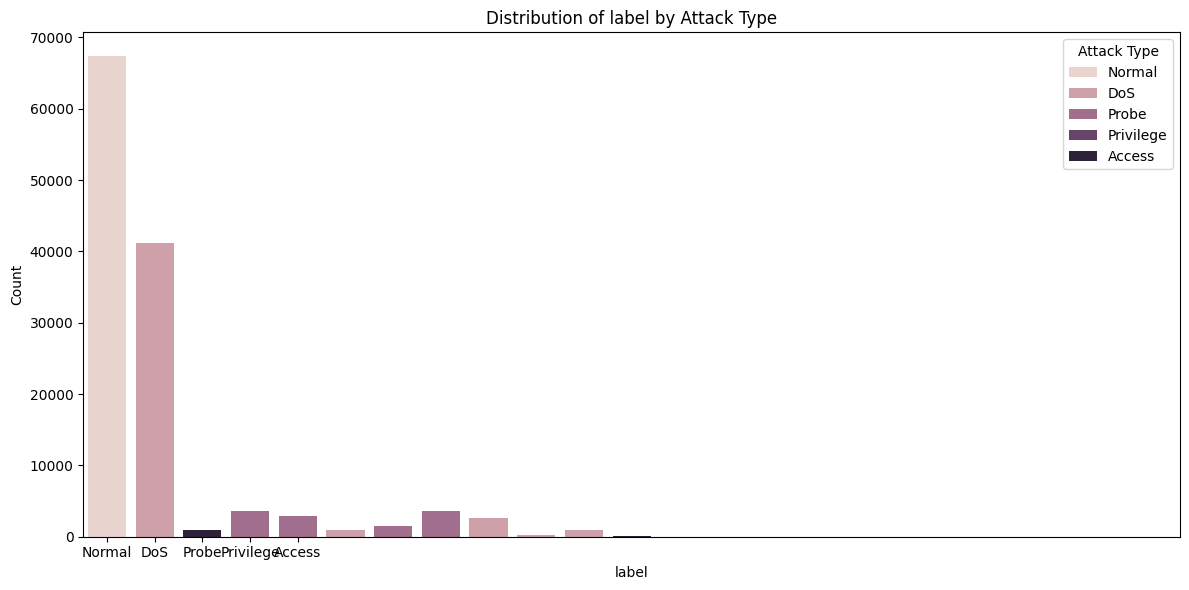

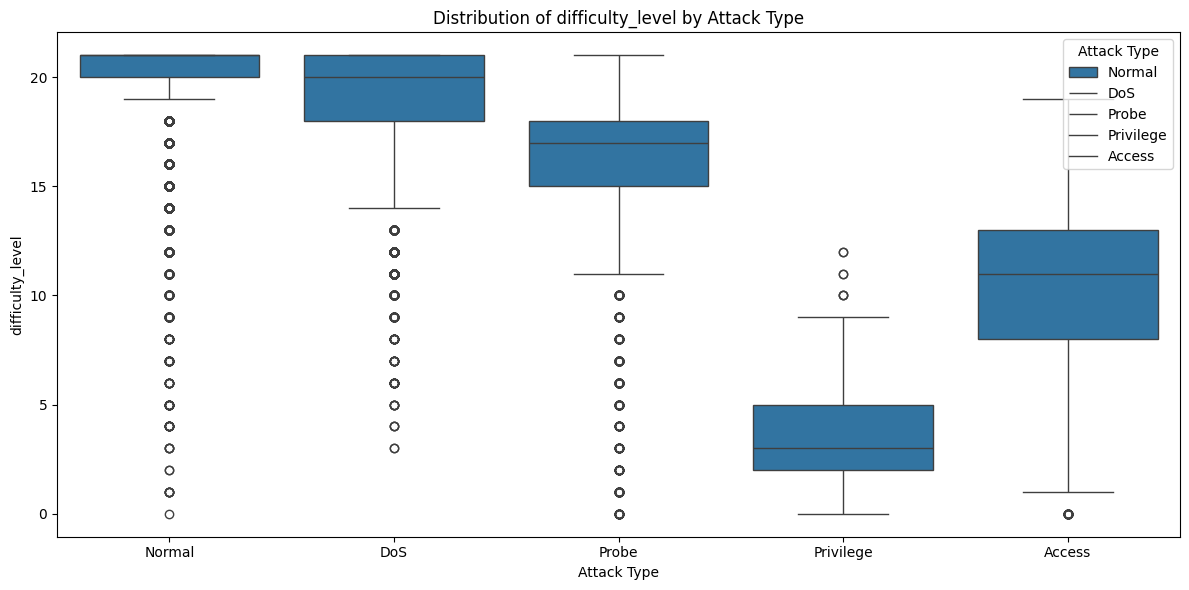

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_feature_distributions(df, features, attack_map):
    attack_types = {0: 'Normal', 1: 'DoS', 2: 'Probe', 3: 'Privilege', 4: 'Access'}

    for feature in features:
        plt.figure(figsize=(12, 6))

        if df[feature].dtype in ['int64', 'float64']:
            sns.boxplot(x='attack_map', y=feature, data=df, order=[0, 1, 2, 3, 4])
            plt.title(f'Distribution of {feature} by Attack Type')
            plt.xlabel('Attack Type')
            plt.ylabel(feature)
        else:
            sns.countplot(x=feature, hue='attack_map', data=df, hue_order=[0, 1, 2, 3, 4])
            plt.title(f'Distribution of {feature} by Attack Type')
            plt.xlabel(feature)
            plt.ylabel('Count')

        plt.xticks(range(5), [attack_types[i] for i in range(5)])
        plt.legend(title='Attack Type', labels=[attack_types[i] for i in range(5)])
        plt.tight_layout()
        plt.show()

features = train_data.columns.tolist()
features.remove('attack_flag')
features.remove('attack_map')

plot_feature_distributions(train_data, features, 'attack_map')

In [21]:
train_data_copy = train_data.copy()

label_encoder = LabelEncoder()
train_data_copy['label_encoded'] = label_encoder.fit_transform(train_data_copy['label'])

train_data_copy.drop(['attack_flag', 'difficulty_level'], axis=1, inplace=True)

numeric_columns = train_data_copy.select_dtypes(include=[np.number]).columns
categorical_columns = train_data_copy.select_dtypes(exclude=[np.number]).columns

scaler = StandardScaler()
train_data_copy[numeric_columns] = scaler.fit_transform(train_data_copy[numeric_columns])

corr_matrix = train_data_copy[numeric_columns].corr()

if 'attack_map' in numeric_columns:
    corr_y = abs(corr_matrix['attack_map'])
elif 'label_encoded' in numeric_columns:
    corr_y = abs(corr_matrix['label_encoded'])
else:
    raise ValueError("Neither 'attack_map' nor 'label_encoded' found in numeric columns")

highest_corr = corr_y[corr_y > 0.356].sort_values(ascending=False)
print("\nHighest correlations with target variable:")
print(highest_corr)


Highest correlations with target variable:
attack_map                  1.000000
dst_host_srv_count          0.604289
logged_in                   0.541073
dst_host_same_srv_rate      0.499194
same_srv_rate               0.481508
dst_host_diff_srv_rate      0.371211
count                       0.364705
dst_host_srv_serror_rate    0.362688
dst_host_serror_rate        0.360176
serror_rate                 0.359405
srv_serror_rate             0.356634
Name: attack_map, dtype: float64


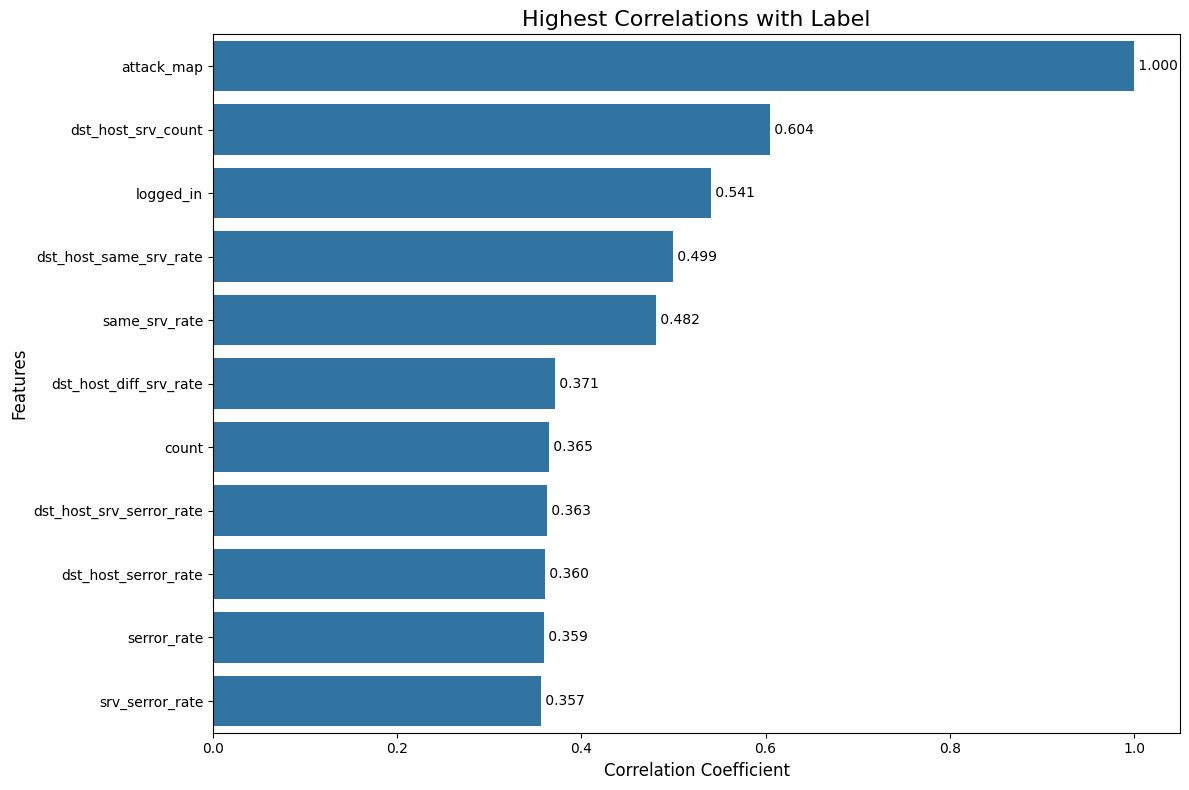

In [12]:
plt.figure(figsize=(12, 8))
sns.barplot(x=highest_corr.values, y=highest_corr.index, orient='h')

plt.title('Highest Correlations with Label', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)

for i, v in enumerate(highest_corr.values):
    plt.text(v, i, f' {v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
categorical_features = ['protocol_type', 'service', 'flag']

numeric_features = ['count', 'logged_in', 'srv_serror_rate', 'serror_rate', 'dst_host_serror_rate',
                    'dst_host_same_srv_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_count', 'same_srv_rate']

all_numeric_features = ["duration","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate"]

preprocessing_pipeline = create_preprocessing_pipeline(categorical_features, numeric_features)
preprocessing_pipeline.fit(train_data)

transformed_data = preprocessing_pipeline.transform(train_data)
transformed_test_data = preprocessing_pipeline.transform(test_data)

feature_names = (preprocessing_pipeline.named_steps['preprocessor']
                  .named_transformers_['categorical_feature_encoder'].get_feature_names_out(categorical_features).tolist() + numeric_features)
transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
transformed_test_df = pd.DataFrame(transformed_test_data, columns=feature_names)


preprocessing_pipeline_all_features = create_preprocessing_pipeline(categorical_features, all_numeric_features)
preprocessing_pipeline_all_features.fit(train_data)

all_features = (preprocessing_pipeline.named_steps['preprocessor']
                  .named_transformers_['categorical_feature_encoder'].get_feature_names_out(categorical_features).tolist() + all_numeric_features)

transformed_data_all_features = preprocessing_pipeline_all_features.transform(train_data)
transformed_test_data_all_features = preprocessing_pipeline_all_features.transform(test_data)
all_features_df = pd.DataFrame(transformed_data_all_features, columns=all_features)
all_features_test_df = pd.DataFrame(transformed_test_data_all_features, columns=all_features)

In [14]:
print(all_features_test_df.shape)

(22544, 122)


In [15]:
print(transformed_test_df.head)

<bound method NDFrame.head of        protocol_type_icmp  protocol_type_tcp  protocol_type_udp  service_IRC  \
0                     0.0                1.0                0.0          0.0   
1                     0.0                1.0                0.0          0.0   
2                     0.0                1.0                0.0          0.0   
3                     1.0                0.0                0.0          0.0   
4                     0.0                1.0                0.0          0.0   
...                   ...                ...                ...          ...   
22539                 0.0                1.0                0.0          0.0   
22540                 0.0                1.0                0.0          0.0   
22541                 0.0                1.0                0.0          0.0   
22542                 0.0                0.0                1.0          0.0   
22543                 0.0                1.0                0.0          0.0   

       se

In [16]:
X_binary_class = transformed_df
Y_binary_class = train_data['attack_flag']
X_binary_class_all_features = all_features_df
Y_binary_class_all_features = train_data['attack_flag']

save_data(X_binary_class, Y_binary_class, 'preprocessed_binary_class_data.joblib')
save_data(X_binary_class_all_features, Y_binary_class_all_features, 'preprocessed_binary_class_all_features_data.joblib')

Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_binary_class_data.joblib
Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_binary_class_all_features_data.joblib


In [20]:
X_binary_class_test = transformed_test_df
Y_binary_class_test = test_data['attack_flag']
X_binary_class_test_all_features = all_features_test_df
Y_binary_class_test_all_features = test_data['attack_flag']

save_data(X_binary_class_test, Y_binary_class_test, 'preprocessed_binary_class_test_data.joblib')
save_data(X_binary_class_test_all_features, Y_binary_class_test_all_features, 'preprocessed_binary_class_all_features_test_data.joblib')

Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_binary_class_test_data.joblib
Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_binary_class_all_features_test_data.joblib


In [31]:
X_multi_class = transformed_df
Y_multi_class = train_data['attack_map']
X_multi_class_all_features = all_features_df
Y_multi_class_all_features = train_data['attack_map']
save_data(X_multi_class, Y_multi_class, 'preprocessed_multi_class_data.joblib')
save_data(X_multi_class_all_features, Y_multi_class_all_features, 'preprocessed_multi_class_all_features_data.joblib')

Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_multi_class_data.joblib
Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_multi_class_all_features_data.joblib


In [32]:
X_multi_class_test = transformed_test_df
Y_multi_class_test = test_data['attack_map']
X_multi_class_all_features_test = all_features_test_df
Y_multi_class_all_features_test = test_data['attack_map']
save_data(X_multi_class_test, Y_multi_class_test, 'preprocessed_multi_class_test_data.joblib')
save_data(X_multi_class_all_features_test, Y_multi_class_all_features_test, 'preprocessed_multi_class_all_features_test_data.joblib')

Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_multi_class_test_data.joblib
Preprocessed data dumped successfully at path: /content/drive/MyDrive/Colab_Notebooks/ALDA-Proj/preprocessed_multi_class_all_features_test_data.joblib
